<img src="http://imgur.com/1ZcRyrc.png" style="float: left; margin: 15px; height: 80px">

# Project 3

### Regression and Classification with the Ames Housing Data

---

You have just joined a new "full stack" real estate company in Ames, Iowa. The strategy of the firm is two-fold:
- Own the entire process from the purchase of the land all the way to sale of the house, and anything in between.
- Use statistical analysis to optimize investment and maximize return.

The company is still small, and though investment is substantial the short-term goals of the company are more oriented towards purchasing existing houses and flipping them as opposed to constructing entirely new houses. That being said, the company has access to a large construction workforce operating at rock-bottom prices.

This project uses the [Ames housing data recently made available on kaggle](https://www.kaggle.com/c/house-prices-advanced-regression-techniques).

In [1]:
import numpy as np
import scipy.stats as stats
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd

sns.set_style('whitegrid')

%config InlineBackend.figure_format = 'retina'
%matplotlib inline

from patsy import dmatrices
import statsmodels.formula.api as sm
from sklearn.feature_selection import SelectKBest, f_regression, mutual_info_regression, chi2, RFECV
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression, ElasticNet, Lasso, Ridge
from sklearn.preprocessing import StandardScaler
from itertools import combinations
import sys
import warnings

if not sys.warnoptions:
    warnings.simplefilter("ignore")

<img src="http://imgur.com/l5NasQj.png" style="float: left; margin: 25px 15px 0px 0px; height: 25px">

## 1. Estimating the value of homes from fixed characteristics.

---

Your superiors have outlined this year's strategy for the company:
1. Develop an algorithm to reliably estimate the value of residential houses based on *fixed* characteristics.
2. Identify characteristics of houses that the company can cost-effectively change/renovate with their construction team.
3. Evaluate the mean dollar value of different renovations.

Then we can use that to buy houses that are likely to sell for more than the cost of the purchase plus renovations.

Your first job is to tackle #1. You have a dataset of housing sale data with a huge amount of features identifying different aspects of the house. The full description of the data features can be found in a separate file:

    housing.csv
    data_description.txt
    
You need to build a reliable estimator for the price of the house given characteristics of the house that cannot be renovated. Some examples include:
- The neighborhood
- Square feet
- Bedrooms, bathrooms
- Basement and garage space

and many more. 

Some examples of things that **ARE renovate-able:**
- Roof and exterior features
- "Quality" metrics, such as kitchen quality
- "Condition" metrics, such as condition of garage
- Heating and electrical components

and generally anything you deem can be modified without having to undergo major construction on the house.

---

**Your goals:**
1. Perform any cleaning, feature engineering, and EDA you deem necessary.
- Be sure to remove any houses that are not residential from the dataset.
- Identify **fixed** features that can predict price.
- Train a model on pre-2010 data and evaluate its performance on the 2010 houses.
- Characterize your model. How well does it perform? What are the best estimates of price?

> **Note:** The EDA and feature engineering component to this project is not trivial! Be sure to always think critically and creatively. Justify your actions! Use the data description file!

In [2]:
# Load the data
house_orig = pd.read_csv('./housing.csv')

house = house_orig.copy()

In [3]:
house.head()

Id  MSSubClass MSZoning  LotFrontage  LotArea Street Alley LotShape  \
0   1          60       RL         65.0     8450   Pave   NaN      Reg   
1   2          20       RL         80.0     9600   Pave   NaN      Reg   
2   3          60       RL         68.0    11250   Pave   NaN      IR1   
3   4          70       RL         60.0     9550   Pave   NaN      IR1   
4   5          60       RL         84.0    14260   Pave   NaN      IR1   

  LandContour Utilities  ... PoolArea PoolQC Fence MiscFeature MiscVal MoSold  \
0         Lvl    AllPub  ...        0    NaN   NaN         NaN       0      2   
1         Lvl    AllPub  ...        0    NaN   NaN         NaN       0      5   
2         Lvl    AllPub  ...        0    NaN   NaN         NaN       0      9   
3         Lvl    AllPub  ...        0    NaN   NaN         NaN       0      2   
4         Lvl    AllPub  ...        0    NaN   NaN         NaN       0     12   

  YrSold  SaleType  SaleCondition  SalePrice  
0   2008        WD         Normal     208500  
1   2007        WD         Normal     181500  
2   2008        WD         Normal     223500  
3   2006        WD        Abnorml     140000  
4   2008        WD         Normal     250000  

[5 rows x 81 columns]

In [4]:
house.MSZoning.unique()

array(['RL', 'RM', 'C (all)', 'FV', 'RH'], dtype=object)

In [5]:
# removing the non-residential houses from the dataset
house.drop(index = list(house.MSZoning[house.MSZoning == 'C (all)'].index), inplace = True)

In [6]:
house.shape

(1450, 81)

In [7]:
house.columns[house.isnull().sum() > 0]

Index(['LotFrontage', 'Alley', 'MasVnrType', 'MasVnrArea', 'BsmtQual',
       'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2',
       'Electrical', 'FireplaceQu', 'GarageType', 'GarageYrBlt',
       'GarageFinish', 'GarageQual', 'GarageCond', 'PoolQC', 'Fence',
       'MiscFeature'],
      dtype='object')

In [8]:
# a list of characteristics in which null means lack of a feature (null does not mean missing value)
# according to data_description
lack_char = ['Alley', 'BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2', 'FireplaceQu',
             'GarageType', 'GarageFinish', 'GarageQual', 'GarageCond', 'PoolQC', 'Fence', 'MiscFeature']

In [9]:
# filling the null values with the word 'lack_[variable name]'
for var in lack_char:
    house[var] = house[var].fillna('lack_' + str(var))

In [10]:
# looking for other columns with null values
house.columns[house.isnull().sum() > 0]

Index(['LotFrontage', 'MasVnrType', 'MasVnrArea', 'Electrical', 'GarageYrBlt'], dtype='object')

As the number of missing values is significant, by imputing missing values we might get false information. So we can just drop all the missing values to avoid wrong results.

In [11]:
# removing all missing values
house.dropna(axis = 0, inplace = True)

In [12]:
house.shape

(1112, 81)

In [13]:
# removing Id from house
house.drop('Id', axis = 1, inplace = True)

In [14]:
# creating a dictionary for fixability of the house characteristics, using the data_description
fixability = {'MSSubClass':'fixed', 'MSZoning':'fixed', 'LotFrontage':'fixed', 'LotArea':'fixed', 'Street':'fixed',
       'LotShape':'fixed', 'LandContour':'fixed', 'Utilities':'fixed', 'LotConfig':'fixed', 'LandSlope':'fixed',
       'Neighborhood':'fixed', 'Condition1':'fixed', 'Condition2':'fixed', 'BldgType':'fixed', 'HouseStyle':'fixed',
       'OverallQual':'renovatable', 'OverallCond':'renovatable', 'YearBuilt':'fixed', 'YearRemodAdd':'fixed', 'RoofStyle':'renovatable',
       'RoofMatl':'renovatable', 'Exterior1st':'renovatable', 'Exterior2nd':'renovatable', 'MasVnrType':'renovatable', 'MasVnrArea':'fixed',
       'ExterQual':'renovatable', 'ExterCond':'renovatable', 'Foundation':'fixed', 'BsmtQual':'renovatable', 'BsmtCond':'renovatable',
       'BsmtExposure':'fixed', 'BsmtFinType1':'renovatable', 'BsmtFinSF1':'renovatable', 'BsmtFinType2':'renovatable',
       'BsmtFinSF2':'renovatable', 'BsmtUnfSF':'renovatable', 'TotalBsmtSF':'fixed', 'Heating':'renovatable', 'HeatingQC':'renovatable',
       'CentralAir':'renovatable', 'Electrical':'renovatable', '1stFlrSF':'fixed', '2ndFlrSF':'fixed', 'LowQualFinSF':'fixed',
       'GrLivArea':'fixed', 'BsmtFullBath':'fixed', 'BsmtHalfBath':'fixed', 'FullBath':'fixed', 'HalfBath':'fixed',
       'BedroomAbvGr':'fixed', 'KitchenAbvGr':'fixed', 'KitchenQual':'renovatable', 'TotRmsAbvGrd':'fixed',
       'Functional':'fixed', 'Fireplaces':'fixed', 'GarageType':'fixed', 'GarageYrBlt':'fixed', 'GarageFinish':'renovatable',
       'GarageCars':'fixed', 'GarageArea':'fixed', 'GarageQual':'renovatable', 'GarageCond':'renovatable',
       'PavedDrive':'renovatable', 'WoodDeckSF':'fixed', 'OpenPorchSF':'fixed', 'EnclosedPorch':'fixed', '3SsnPorch':'fixed',
       'ScreenPorch':'fixed', 'PoolArea':'fixed', 'MiscVal':'fixed', 'MoSold':'fixed', 'YrSold':'fixed', 'SaleType':'fixed',
       'SaleCondition':'fixed'}

In [15]:
# list of fixed characteristics
fixed_char = [k for k, v in fixability.items() if v == 'fixed']

(array([242., 515., 205.,  90.,  38.,  12.,   3.,   4.,   1.,   2.]),
 array([ 58500., 128150., 197800., 267450., 337100., 406750., 476400.,
        546050., 615700., 685350., 755000.]),
 <a list of 10 Patch objects>)

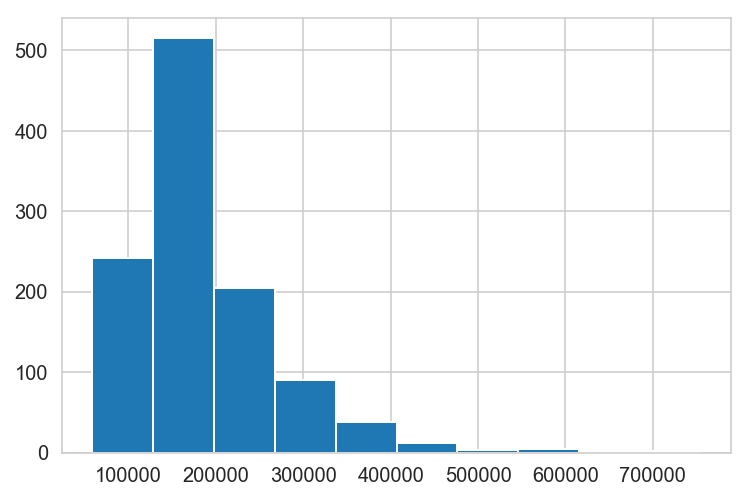

In [16]:
plt.hist(house.SalePrice)

In [17]:
# creating a dictionary for type of characteristics of the house using the data_description
char_type = {'MSSubClass':'categorical', 'MSZoning':'categorical', 'LotFrontage':'numerical', 'LotArea':'numerical', 'Street':'categorical',
       'LotShape':'categorical', 'LandContour':'categorical', 'Utilities':'categorical', 'LotConfig':'categorical', 'LandSlope':'categorical',
       'Neighborhood':'categorical', 'Condition1':'categorical', 'Condition2':'categorical', 'BldgType':'categorical', 'HouseStyle':'categorical',
       'OverallQual':'categorical', 'OverallCond':'categorical', 'YearBuilt':'categorical', 'YearRemodAdd':'categorical', 'RoofStyle':'categorical',
       'RoofMatl':'categorical', 'Exterior1st':'categorical', 'Exterior2nd':'categorical', 'MasVnrType':'categorical', 'MasVnrArea':'numerical',
       'ExterQual':'categorical', 'ExterCond':'categorical', 'Foundation':'categorical', 'BsmtQual':'categorical', 'BsmtCond':'categorical',
       'BsmtExposure':'categorical', 'BsmtFinType1':'categorical', 'BsmtFinSF1':'numerical', 'BsmtFinType2':'categorical',
       'BsmtFinSF2':'numerical', 'BsmtUnfSF':'numerical', 'TotalBsmtSF':'numerical', 'Heating':'categorical', 'HeatingQC':'categorical',
       'CentralAir':'categorical', 'Electrical':'categorical', '1stFlrSF':'numerical', '2ndFlrSF':'numerical', 'LowQualFinSF':'numerical',
       'GrLivArea':'numerical', 'BsmtFullBath':'categorical', 'BsmtHalfBath':'categorical', 'FullBath':'categorical', 'HalfBath':'categorical',
       'BedroomAbvGr':'categorical', 'KitchenAbvGr':'categorical', 'KitchenQual':'categorical', 'TotRmsAbvGrd':'categorical',
       'Functional':'categorical', 'Fireplaces':'categorical', 'GarageType':'categorical', 'GarageYrBlt':'categorical', 'GarageFinish':'categorical',
       'GarageCars':'categorical', 'GarageArea':'numerical', 'GarageQual':'categorical', 'GarageCond':'categorical',
       'PavedDrive':'categorical', 'WoodDeckSF':'numerical', 'OpenPorchSF':'numerical', 'EnclosedPorch':'numerical', '3SsnPorch':'numerical',
       'ScreenPorch':'numerical', 'PoolArea':'numerical', 'MiscVal':'numerical', 'MoSold':'categorical', 'YrSold':'categorical', 'SaleType':'categorical',
       'SaleCondition':'categorical'}

In [18]:
# making seperate lists for numerical and categorical characteristics
cat_char = [k for k, v in char_type.items() if v == 'categorical']
num_char = [k for k, v in char_type.items() if v == 'numerical']

In [19]:
print("The characteristics which we want to consider categorical but are represented as numbers:")
cat_but_num = []
for i in house.iloc[:, 0:house.columns.shape[0]-1]._get_numeric_data().columns:
    if not i in num_char:
        cat_but_num.append(i)
print(cat_but_num)

The characteristics which we want to consider categorical but are represented as numbers:
['MSSubClass', 'OverallQual', 'OverallCond', 'YearBuilt', 'YearRemodAdd', 'BsmtFullBath', 'BsmtHalfBath', 'FullBath', 'HalfBath', 'BedroomAbvGr', 'KitchenAbvGr', 'TotRmsAbvGrd', 'Fireplaces', 'GarageYrBlt', 'GarageCars', 'MoSold', 'YrSold']


In the first part, we want to estimate the price only based on the fixed characteristics.

In [20]:
num_char_fixed = [char for char in fixed_char if char in num_char]
cat_char_fixed = [char for char in fixed_char if char in cat_char]

At this stage we start looking for important characteristics. We start with the numerical variables first.

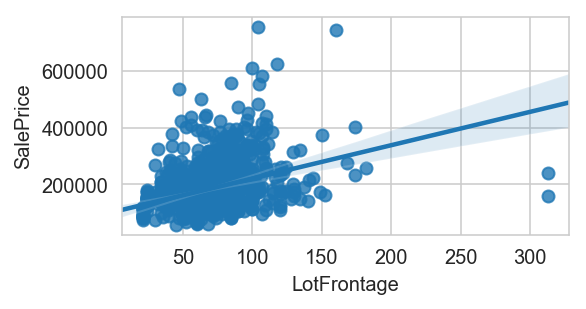

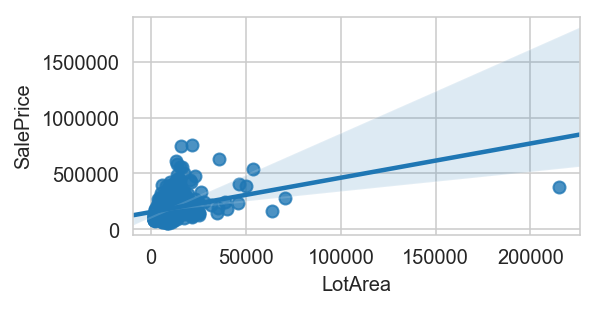

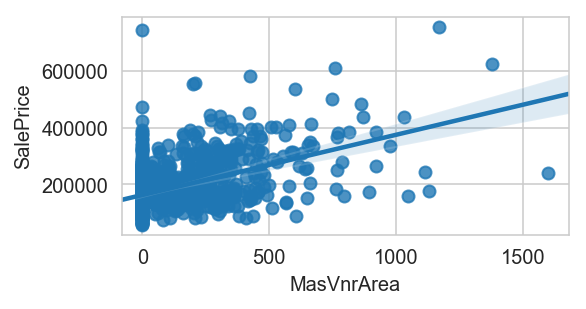

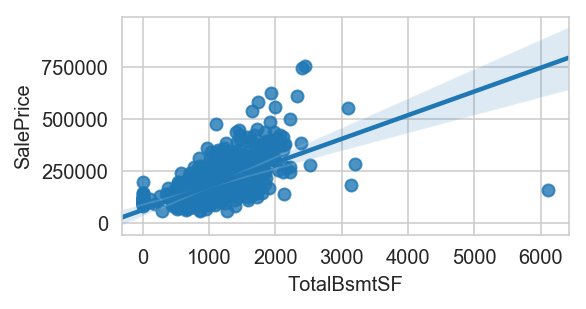

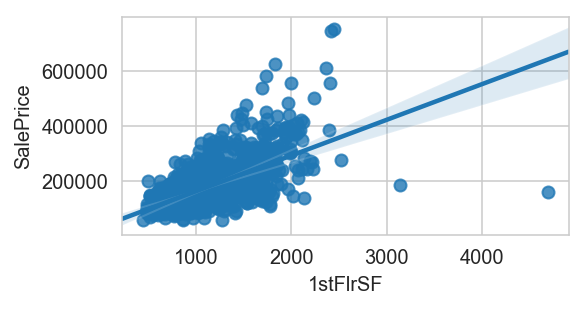

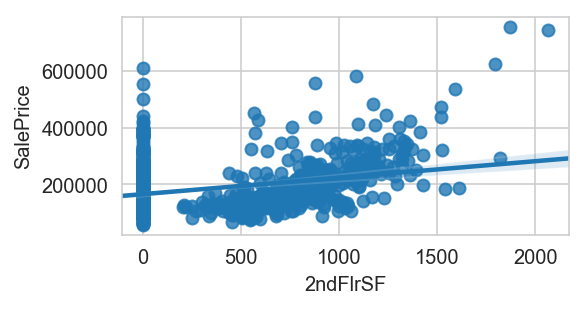

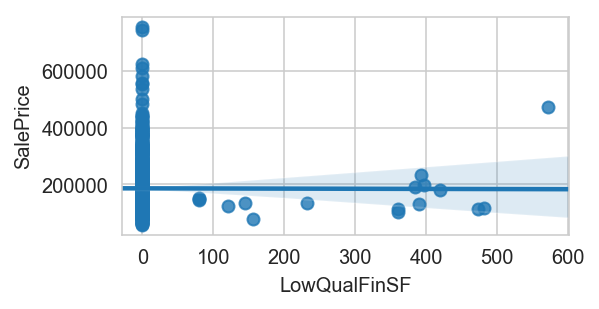

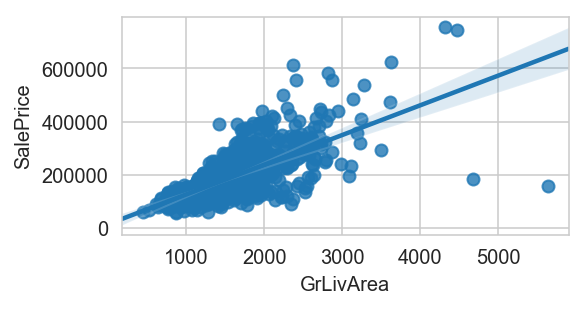

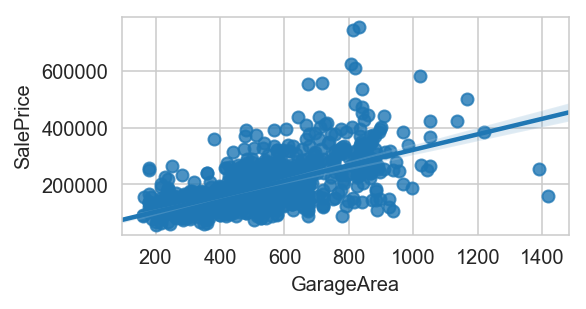

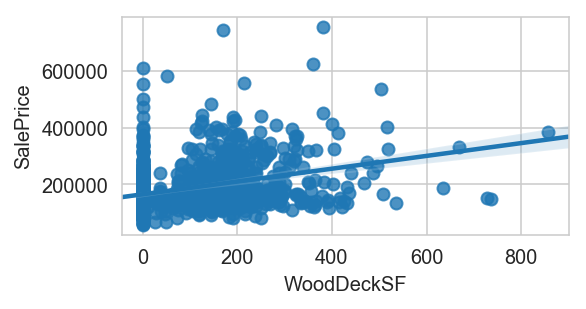

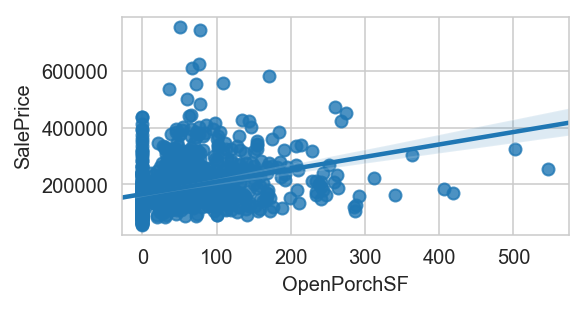

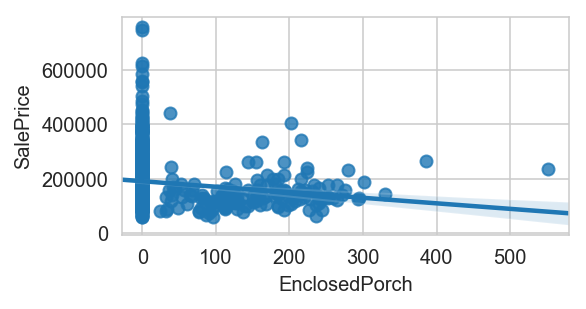

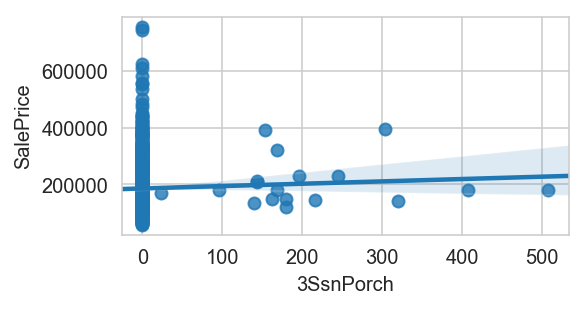

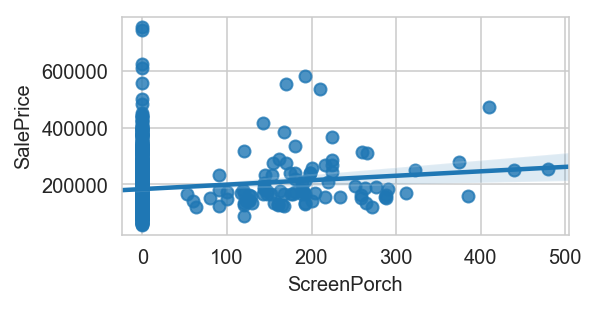

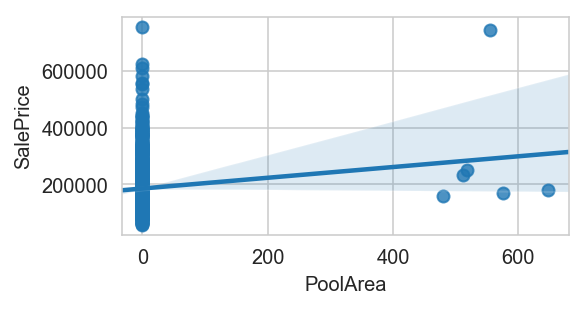

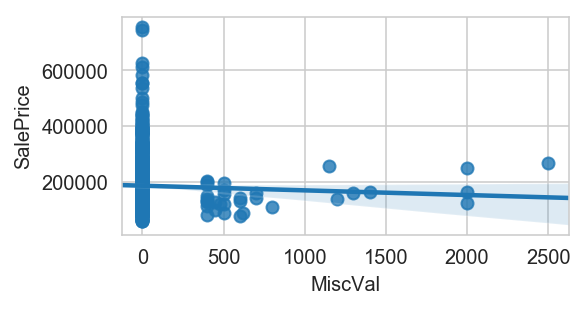

In [21]:
# checking the relation between the price and each of the fixed numerical characteristics
for i in num_char_fixed:
    fig, ax = plt.subplots(figsize = (4,2))
    sns.regplot(x = house[i], y = house.SalePrice, ax = ax)

We should remove the outliers since we are going to have a linear model. We plot SalePrice against each numercial variable, make a linear model for that and remove the datapoint that are far from the line. But how do we define far?
We find the distance of true data from the regressor line, find the distribution of residuals and define outlier as a number out of this range:
[Q1 - k*(Q3 - Q1), Q3 + K*(Q3 - Q1)]; k=3, Q1: lower quartile, Q3: upper quartile

In [22]:
# keeping the house data with outliers for later use
house_with_outliers = house.copy()

LotFrontage
number of upper range outliers: 9
number of lower range outliers: 1

number of data points if we remove only outliers corresponding to LotFrontage : 1102
------------------------
LotArea
number of upper range outliers: 9
number of lower range outliers: 1

number of data points if we remove only outliers corresponding to LotArea : 1102
------------------------
MasVnrArea
number of upper range outliers: 8
number of lower range outliers: 0

number of data points if we remove only outliers corresponding to MasVnrArea : 1104
------------------------
TotalBsmtSF
number of upper range outliers: 8
number of lower range outliers: 1

number of data points if we remove only outliers corresponding to TotalBsmtSF : 1103
------------------------
1stFlrSF
number of upper range outliers: 7
number of lower range outliers: 1

number of data points if we remove only outliers corresponding to 1stFlrSF : 1104
------------------------
2ndFlrSF
number of upper range outliers: 10
number of lower r

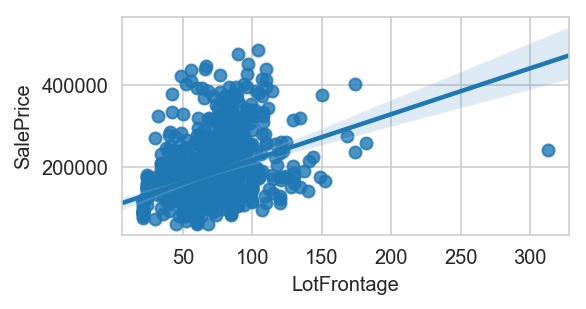

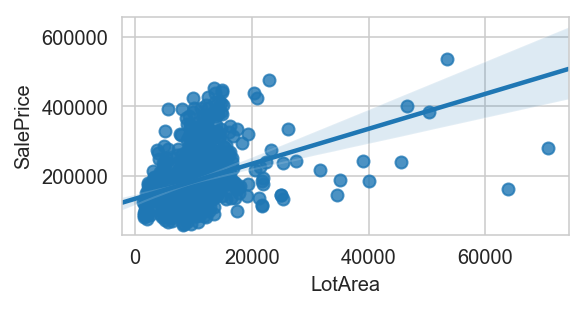

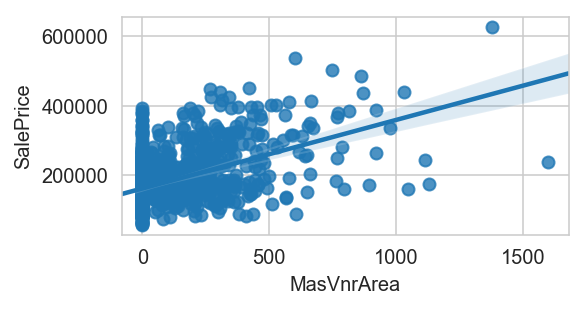

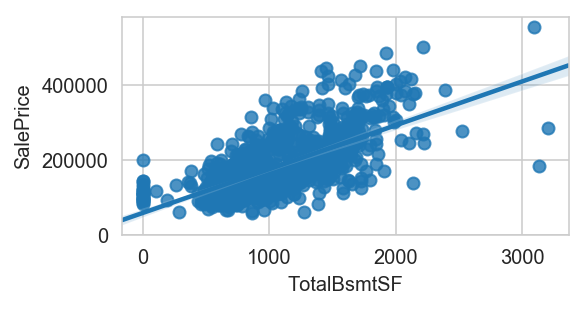

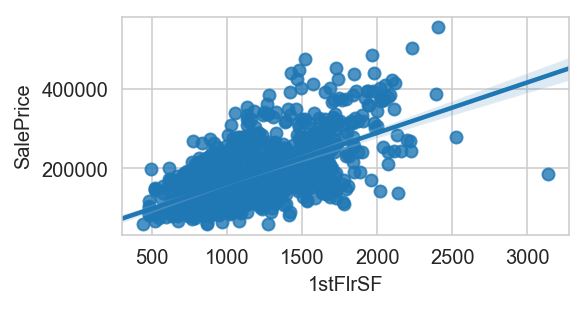

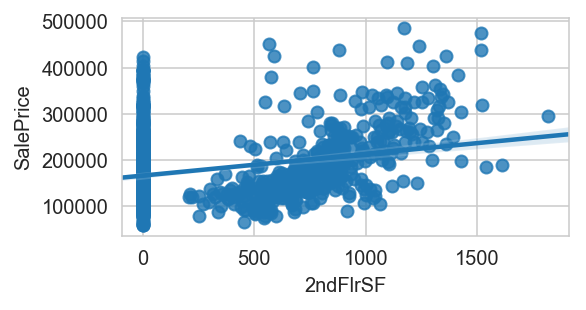

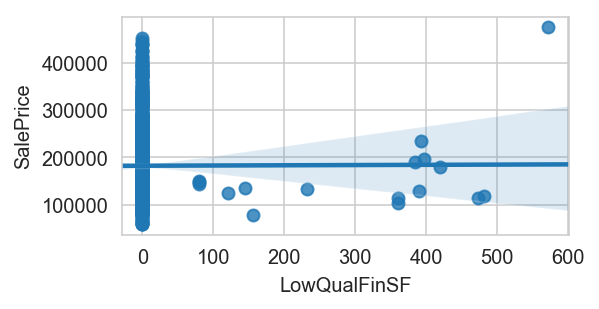

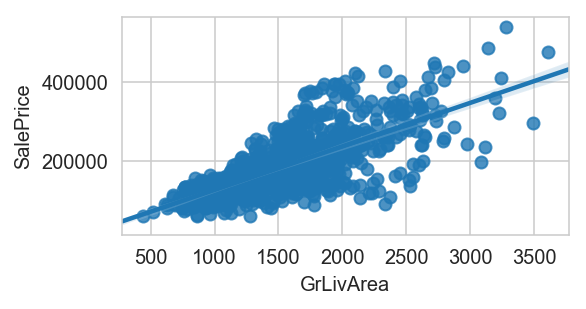

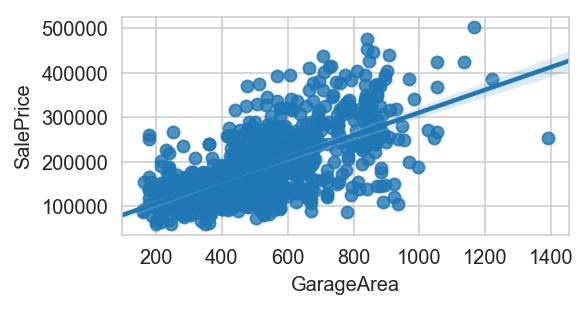

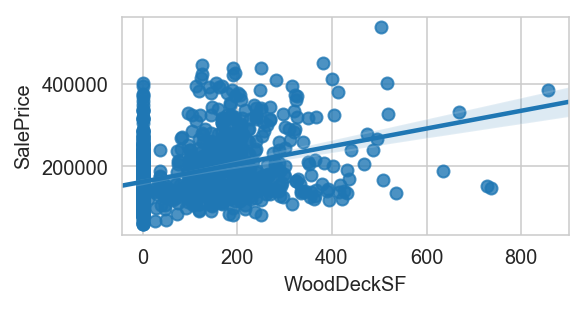

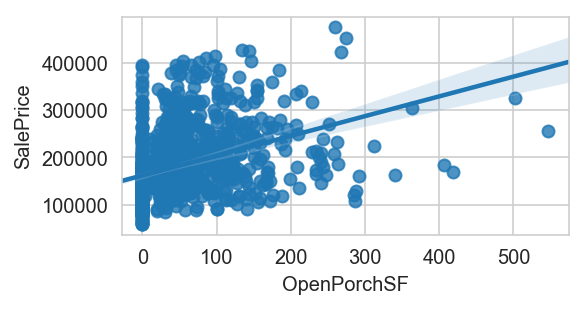

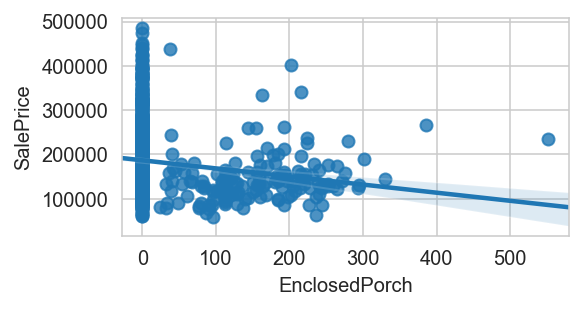

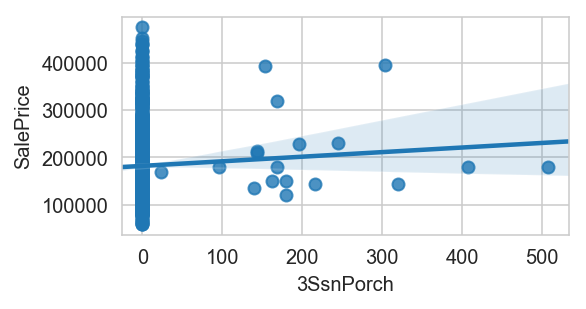

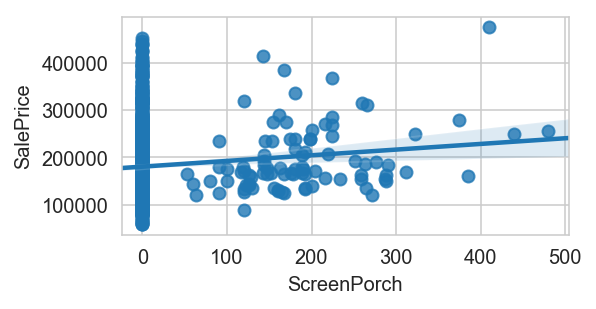

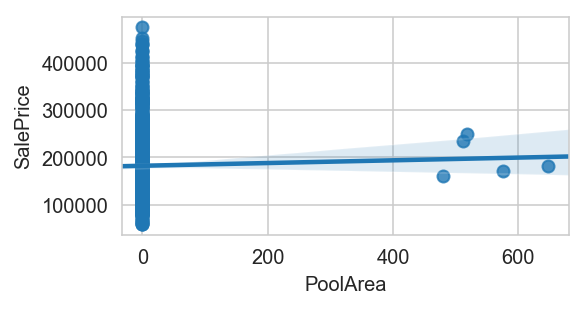

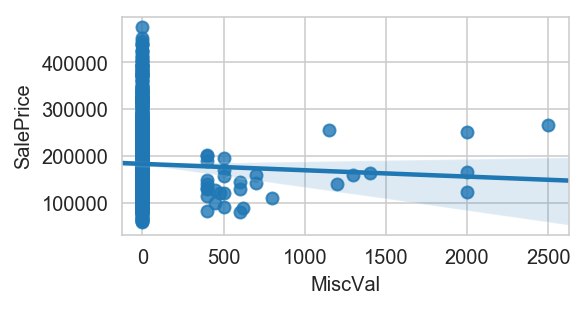

In [23]:
for char in num_char_fixed:
    X = pd.DataFrame(house[char])
    y = house.SalePrice

    lr = LinearRegression()
    lr.fit(X, y)

    y_hat = lr.predict(X)
    residual = y - y_hat

    # lower and upper quartiles
    Q1, Q3 = residual.quantile([0.25, 0.75])
    k = 3
    print(char)
    print("number of upper range outliers:", (residual > (Q3 + k*(Q3-Q1))).sum())
    print("number of lower range outliers:", (residual < (Q1 - k*(Q3-Q1))).sum())
    
    upper_range = residual[(residual > (Q3 + k*(Q3-Q1)))]
    lower_range = residual[(residual < (Q1 - k*(Q3-Q1)))]
    
    house = house[~house.isin(house.loc[upper_range.index, :]).iloc[:,0]]
    house = house[~house.isin(house.loc[lower_range.index, :]).iloc[:,0]]
    
    print("\nnumber of data points if we remove only outliers corresponding to", char,":", house.shape[0])
    print("------------------------")
    
    fig, ax = plt.subplots(figsize = (4,2))
    sns.regplot(x = house[char], y = house.SalePrice, ax = ax)
    
    house = house_with_outliers.copy()

A datapoint that is an outliers with respect to one variable, might not be an outlier with respect to another one. So we do not remove outliers yet until we find out which variables are more likely to be the predictors and then we remove their corresponding outliers.

We start by checking the correlation of variables. Knowing the highly correlated variables will help us to avoid selecting them together as features.

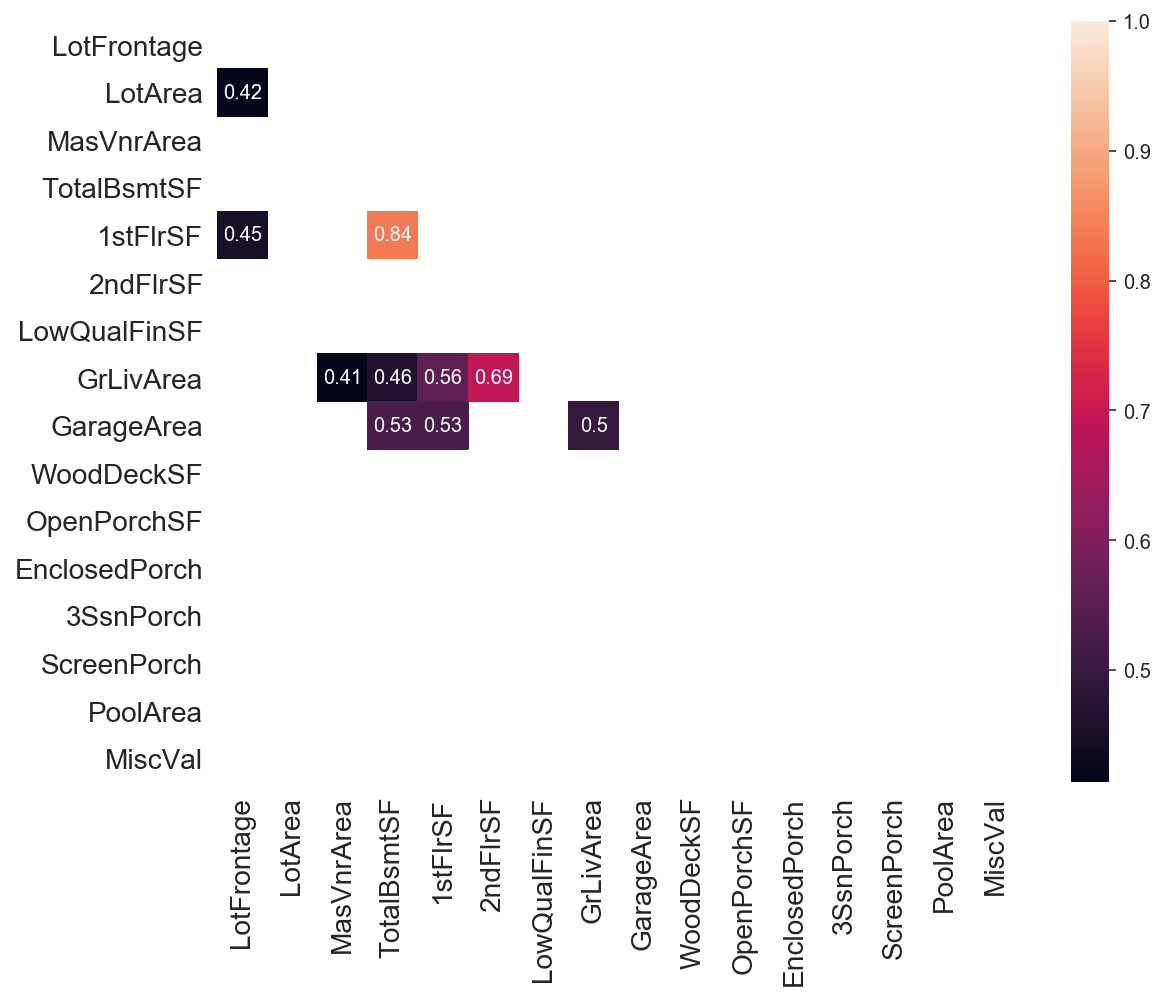

In [24]:
# correlation matrix for the numerical characteristics based on Pearson method (only highly correlated ones are shown)
corrPear = house[num_char_fixed].corr()

fig, ax = plt.subplots(figsize = (9,7))

mask = np.zeros_like(corrPear, dtype = np.bool)
mask[np.triu_indices_from(mask)] = True

ax = sns.heatmap(corrPear[np.abs(corrPear) > 0.4], mask = mask, ax = ax, annot = True)

ax.set_xticklabels(ax.xaxis.get_ticklabels(), fontsize = 14)
ax.set_yticklabels(ax.yaxis.get_ticklabels(), fontsize = 14)

plt.show()

GarageArea and TotalBsmtSF have high correlation with other characteristics, so we might not use them as predictors so it is better not to remove their corresponding outliers.
Also it seems that there is no linear relation between some characteristics and SalePrice so we might not consider them as predictors and it is better to keep their corresponding outliers. These characteristics are: LowQualFinSF, 3SsnPorch,PoolArea, MiscVal

LotFrontage
number of upper range outliers: 9
number of lower range outliers: 1

number of data points after removing outliers: 1102
------------------------
LotArea
number of upper range outliers: 1
number of lower range outliers: 1

number of data points after removing outliers: 1100
------------------------
MasVnrArea
number of upper range outliers: 1
number of lower range outliers: 0

number of data points after removing outliers: 1099
------------------------
1stFlrSF
number of upper range outliers: 0
number of lower range outliers: 0

number of data points after removing outliers: 1099
------------------------
2ndFlrSF
number of upper range outliers: 1
number of lower range outliers: 0

number of data points after removing outliers: 1098
------------------------
GrLivArea
number of upper range outliers: 6
number of lower range outliers: 1

number of data points after removing outliers: 1091
------------------------
WoodDeckSF
number of upper range outliers: 1
number of lower rang

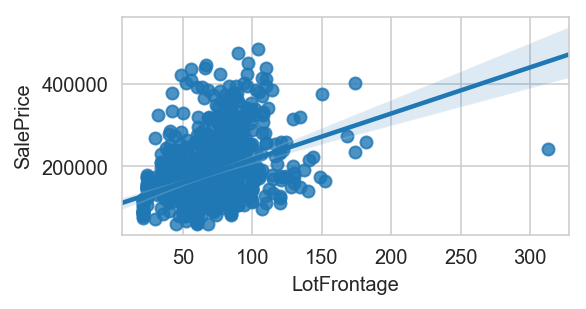

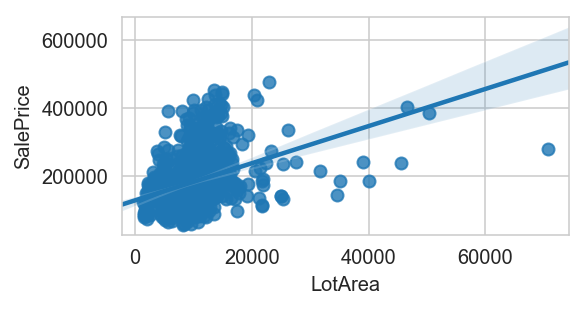

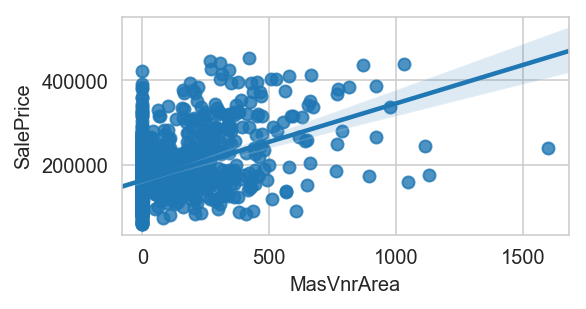

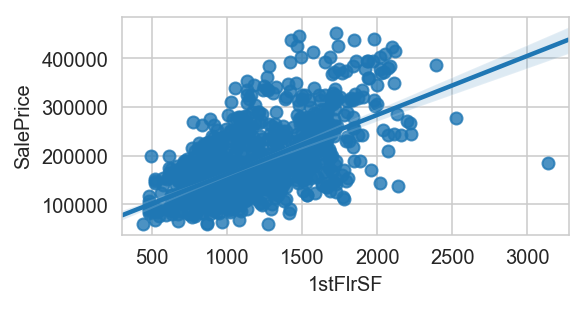

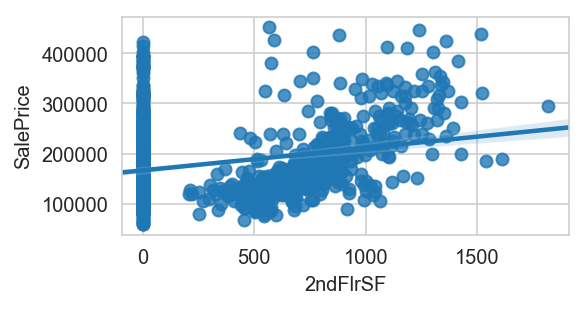

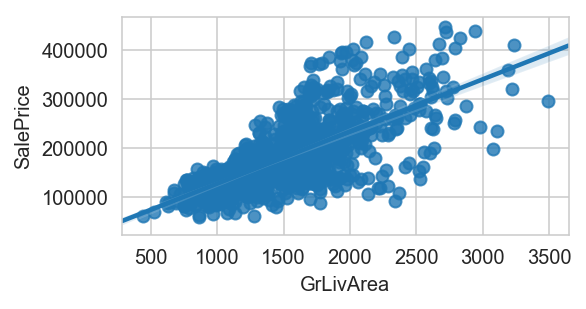

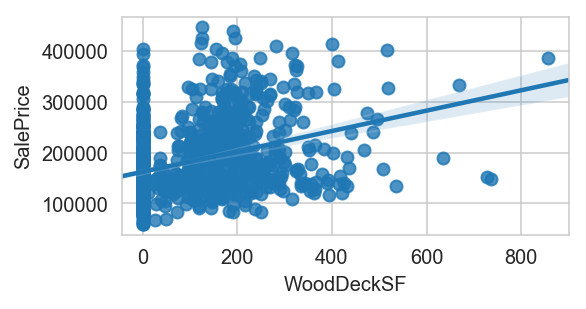

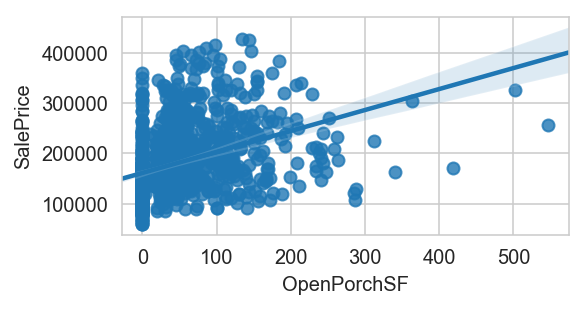

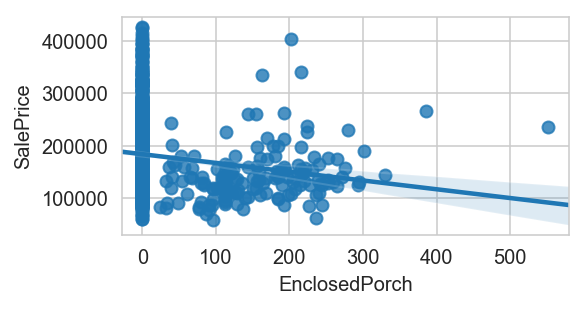

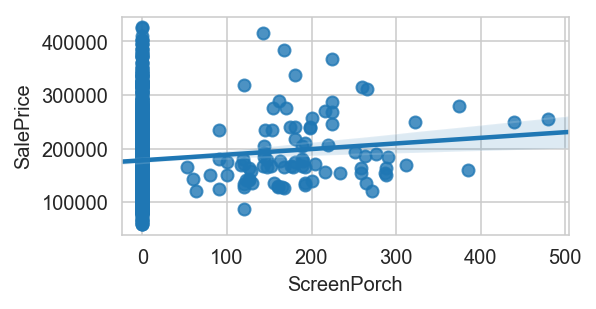

In [25]:
for char in [char for char in num_char_fixed if not char in
             ['GarageArea','TotalBsmtSF','LowQualFinSF', '3SsnPorch','PoolArea', 'MiscVal']]:
    
    X = pd.DataFrame(house[char])
    y = house.SalePrice

    lr = LinearRegression()
    lr.fit(X, y)

    y_hat = lr.predict(X)
    residual = y - y_hat

    # lower and upper quartiles
    Q1, Q3 = residual.quantile([0.25, 0.75])
    k = 3
    print(char)
    print("number of upper range outliers:", (residual > (Q3 + k*(Q3-Q1))).sum())
    print("number of lower range outliers:", (residual < (Q1 - k*(Q3-Q1))).sum())
    
    upper_range = residual[(residual > (Q3 + k*(Q3-Q1)))]
    lower_range = residual[(residual < (Q1 - k*(Q3-Q1)))]
    
    house = house[~house.isin(house.loc[upper_range.index, :]).iloc[:,0]]
    house = house[~house.isin(house.loc[lower_range.index, :]).iloc[:,0]]
    
    print("\nnumber of data points after removing outliers:", house.shape[0])
    print("------------------------")
    
    fig, ax = plt.subplots(figsize = (4,2))
    sns.regplot(x = house[char], y = house.SalePrice, ax = ax)

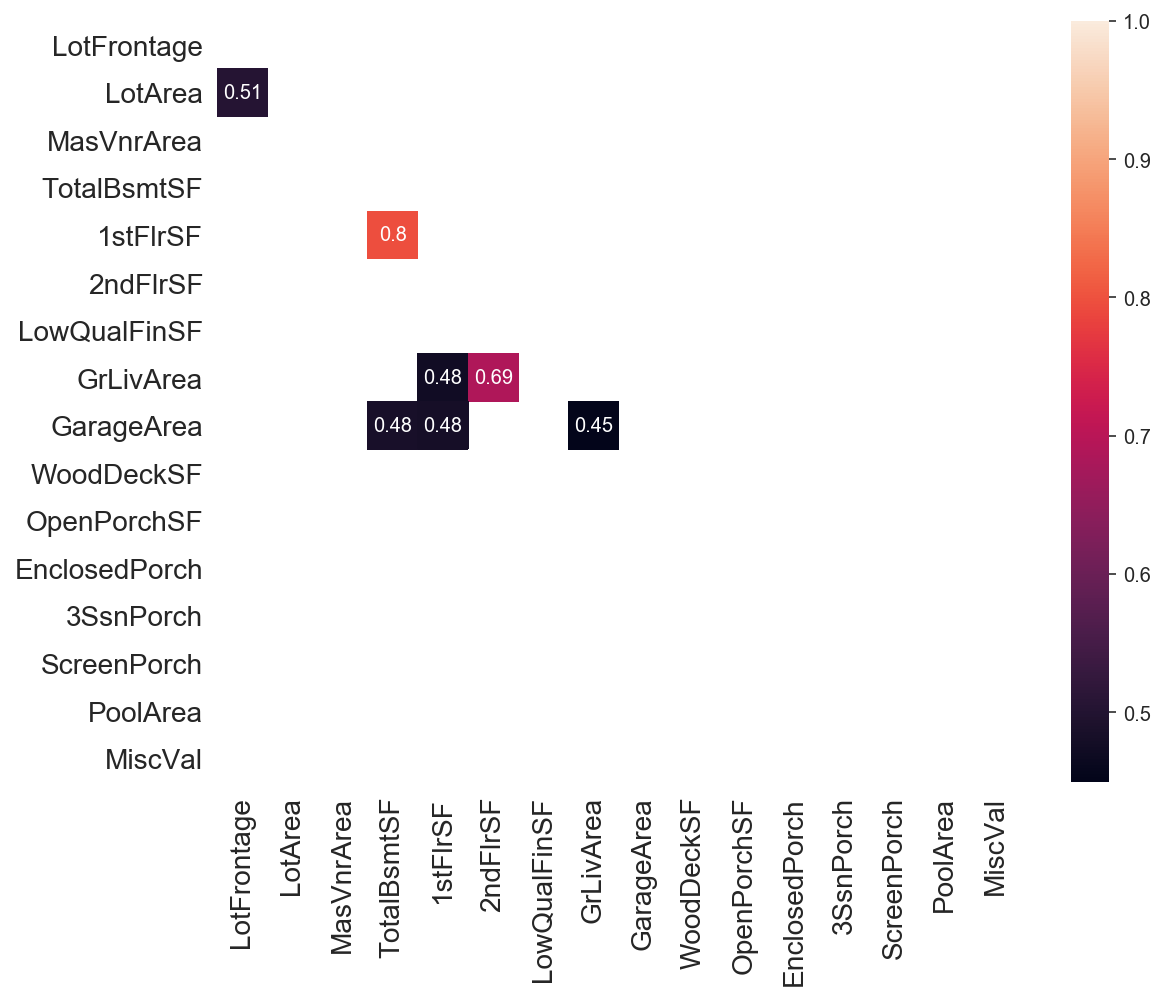

In [26]:
# correlation matrix for the numerical characteristics based on Pearson method (only highly correlated ones are shown)
corrPear = house[num_char_fixed].corr()

fig, ax = plt.subplots(figsize = (9,7))

mask = np.zeros_like(corrPear, dtype = np.bool)
mask[np.triu_indices_from(mask)] = True

ax = sns.heatmap(corrPear[np.abs(corrPear) > 0.4], mask = mask, ax = ax, annot = True)

ax.set_xticklabels(ax.xaxis.get_ticklabels(), fontsize = 14)
ax.set_yticklabels(ax.yaxis.get_ticklabels(), fontsize = 14)

plt.show()

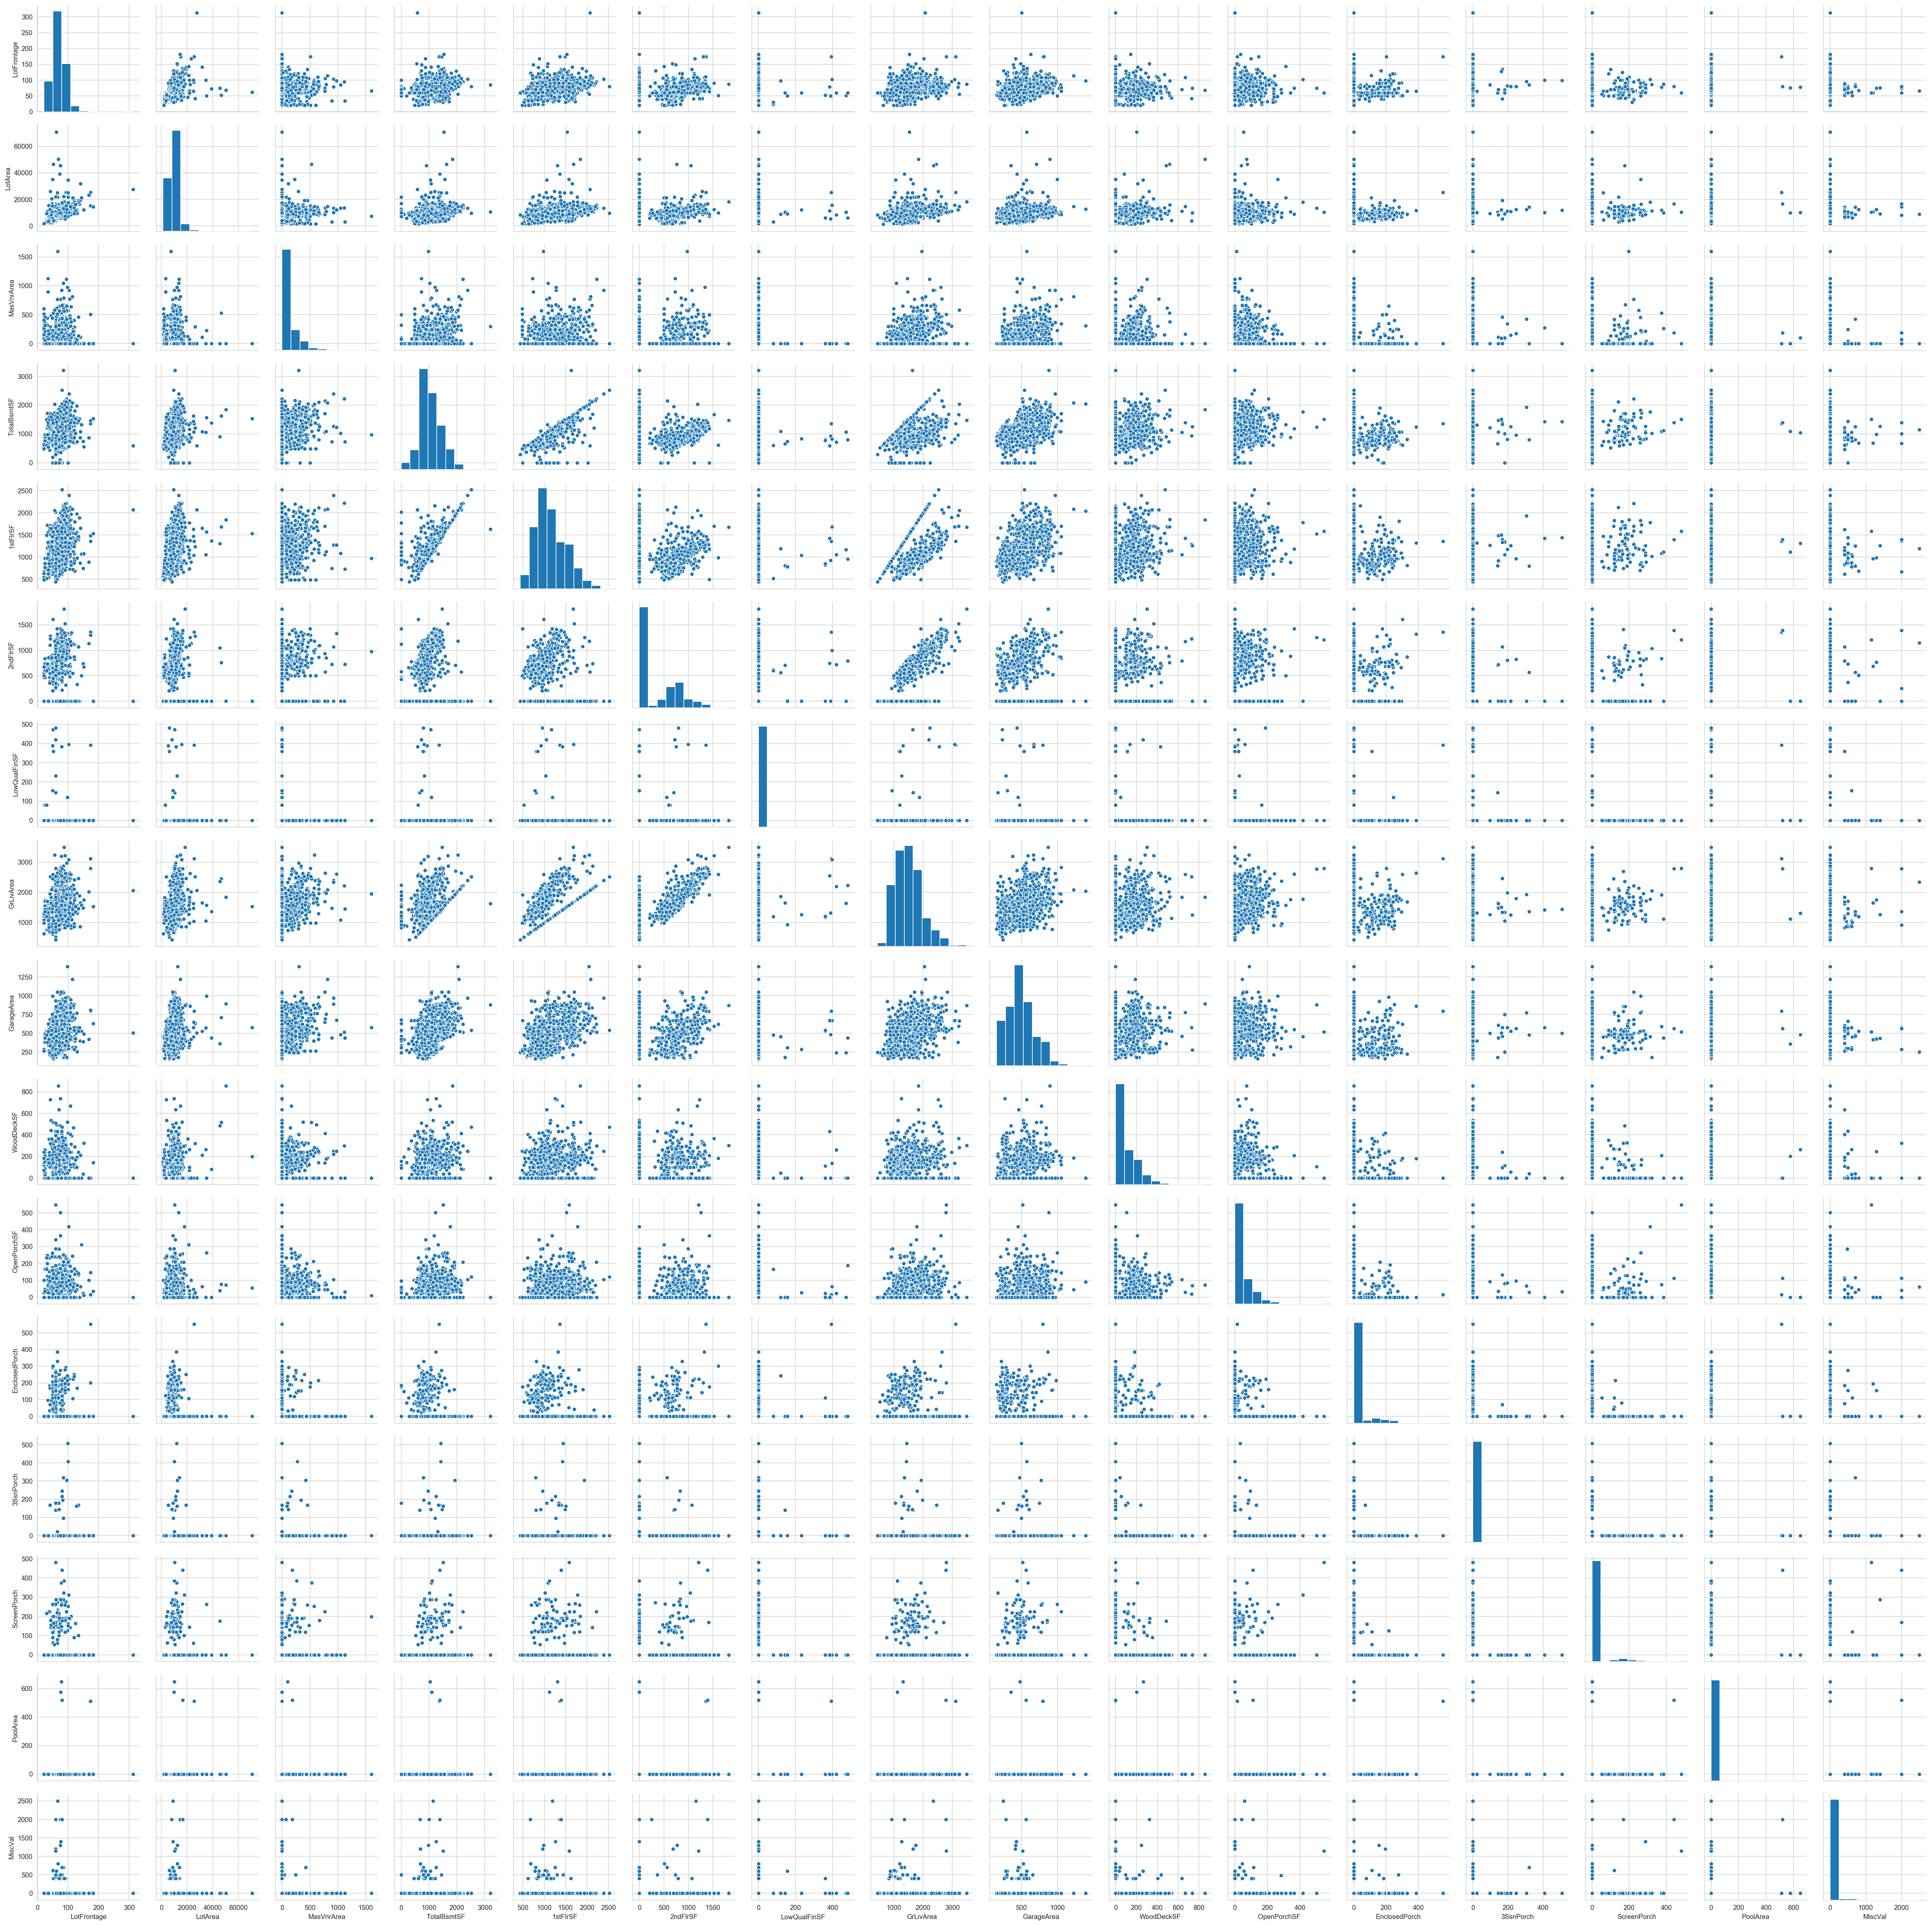

In [27]:
# checking the relation of fixed numerical characteristics with each other
sns.pairplot(house[num_char_fixed])

The plots give us an overview of the relations  between variables and might be useful later for feature selection.
It is seen that some variables seem almost independent from each other. In addition, the distributions of variables are different and some of them are more variant. The ones that take on a narrow range of values are less useful for estimating the price.

We start our feature selection process, using some procedures with different metrics for selection.

In [28]:
# selection based on mutual information regression scores
X = house[num_char_fixed]
y = house.SalePrice

# standardizing data
Xs = StandardScaler().fit_transform(X)

selector = SelectKBest(mutual_info_regression, k = 5)
selector.fit(Xs,y)

feature_by_mutualinf_numvar = pd.DataFrame(selector.scores_, num_char_fixed, columns = ['score'])
feature_by_mutualinf_numvar.sort_values(by = 'score', ascending = False, inplace = True)
feature_by_mutualinf_numvar

score
GrLivArea      0.441357
TotalBsmtSF    0.370873
GarageArea     0.285139
1stFlrSF       0.282843
LotFrontage    0.207851
2ndFlrSF       0.193753
OpenPorchSF    0.186721
LotArea        0.174983
WoodDeckSF     0.110281
MasVnrArea     0.082495
ScreenPorch    0.025874
EnclosedPorch  0.016005
3SsnPorch      0.012520
LowQualFinSF   0.001933
PoolArea       0.000833
MiscVal        0.000000

In [29]:
# selection based on F-regression scores
X = house[num_char_fixed]
y = house.SalePrice

# standardizing data
Xs = StandardScaler().fit_transform(X)

selector = SelectKBest(f_regression, k = 5)
selector.fit(Xs,y)

feature_by_freg_numvar = pd.DataFrame(selector.scores_, num_char_fixed, columns = ['score'])
feature_by_freg_numvar.sort_values(by = 'score', ascending = False, inplace = True)
feature_by_freg_numvar

score
GrLivArea      1063.989141
GarageArea      768.201563
TotalBsmtSF     735.062666
1stFlrSF        629.137354
MasVnrArea      252.672605
OpenPorchSF     183.656125
LotFrontage     161.536336
LotArea         158.694920
WoodDeckSF      146.224470
2ndFlrSF         84.390313
EnclosedPorch    25.287119
ScreenPorch       8.172170
LowQualFinSF      2.787122
3SsnPorch         1.209693
MiscVal           0.820728
PoolArea          0.609780

It seems these two metrics give us a similar result.

Using the first few features resulted from the metrics of mutual information regression and F-regression, we can make a linear regression model to test how these features are successful to estimate the prices compared to the baseline.
We train a model on pre-2010 data and evaluate its performance on the 2010 houses.

In [30]:
# making a model based on different number of featres, starting from 1 and stopping at 10 features
for num_feat in range(1, 11):
    predictors = [feature_by_mutualinf_numvar.index[0:num_feat], feature_by_freg_numvar.index[0:num_feat]]

    print("\nUsing", num_feat, "features the scores are:")
    for pred in predictors:
        X_train = house[house.YrSold != 2010][pred]
        X_test = house[house.YrSold == 2010][pred]
        y_train = house[house.YrSold != 2010].SalePrice
        y_test = house[house.YrSold == 2010].SalePrice

        lr = LinearRegression()
        lr.fit(X_train, y_train)
        print(lr.score(X_test, y_test))


Using 1 features the scores are:
0.524347450564172
0.524347450564172

Using 2 features the scores are:
0.7322456076309846
0.6283993157149759

Using 3 features the scores are:
0.7709492345494361
0.7709492345494362

Using 4 features the scores are:
0.7733924826735202
0.7733924826735201

Using 5 features the scores are:
0.7729962783702727
0.7742156423992459

Using 6 features the scores are:
0.7715159977292125
0.7829264625142437

Using 7 features the scores are:
0.7806070982763836
0.7832744682495081

Using 8 features the scores are:
0.7827178735825531
0.7852206967557779

Using 9 features the scores are:
0.7794046271880625
0.7857370801267531

Using 10 features the scores are:
0.7833244226682746
0.7833244226682746


As it is seen, by increasing the number of features after 3, the scores do not change significantly. To avoid overfitting, we can choose 3 of the features for our first guess.
Since the first 3 best features are correlated, we need other metrics to select features.

Now we can try RFECV and Lasso, rank the features and compare the results with what we have so far.

In [31]:
# RFECV
X = house[num_char_fixed]
y = house.SalePrice

# standardizing data
Xs = StandardScaler().fit_transform(X)

rfecv = RFECV(estimator = LinearRegression(), step = 1, cv = 5)
rfecv.fit(Xs, y)

RFECV(cv=5,
      estimator=LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None,
                                 normalize=False),
      min_features_to_select=1, n_jobs=None, scoring=None, step=1, verbose=0)

In [32]:
print("Optimal number of features according to RFECV is %d" % rfecv.n_features_)

Optimal number of features according to RFECV is 11


In [33]:
# a list of best features according to RFECV (all of them are ranked 1 so there is no priority here)
feature_by_rfecv_numvar = [val for ind, val in enumerate(num_char_fixed) if rfecv.ranking_[ind] == 1]

Since there are many features selected as rank 1 through RFECV, we can rank these selected ones through another model such as Lasso.

In [34]:
# using Lasso to rank the features selected through RFECV
X = house[feature_by_rfecv_numvar]
y = house.SalePrice

# standardizing data
Xs = StandardScaler().fit_transform(X)

lasso = Lasso(alpha = 0.025)
lasso.fit(X, y)


# a list of ranked features according to Lasso
feature_by_rfecv_ranked_numvar = pd.DataFrame(abs(lasso.coef_), feature_by_rfecv_numvar,
                                columns = ['coefficient']).sort_values(by = 'coefficient', ascending = False)
feature_by_rfecv_ranked_numvar

coefficient
OpenPorchSF      91.541024
GarageArea       84.045089
EnclosedPorch    65.502552
LowQualFinSF     58.629709
TotalBsmtSF      55.549693
WoodDeckSF       51.043370
2ndFlrSF         50.986321
1stFlrSF         40.694007
MasVnrArea       37.368603
GrLivArea        11.100318
LotArea           0.978308

Now we select features from all the numerical characteristics through Lasso.

In [35]:
# Lasso
X = house[num_char_fixed]
y = house.SalePrice

# standardizing data
Xs = StandardScaler().fit_transform(X)

lasso = Lasso(alpha = 0.025)
lasso.fit(X, y)


# a list of best features according to Lasso
feature_by_lasso_numvar = pd.DataFrame(abs(lasso.coef_), num_char_fixed,
                                columns = ['coefficient']).sort_values(by = 'coefficient', ascending = False)
feature_by_lasso_numvar

coefficient
OpenPorchSF      91.747284
GarageArea       83.012673
LotFrontage      69.711574
EnclosedPorch    64.628147
LowQualFinSF     57.302190
TotalBsmtSF      55.646264
WoodDeckSF       53.815976
2ndFlrSF         50.772001
1stFlrSF         39.330102
MasVnrArea       36.586007
3SsnPorch        28.951423
ScreenPorch      13.317359
GrLivArea        11.052248
PoolArea          6.440590
MiscVal           5.950246
LotArea           0.827588

Using the above feature rankings and taking the correlation matrix into account, we should be able to choose important characteristics better.
Although we should use the categorical characteristics as well, at this stage we use our domain knowledge and the above results to choose a few characteristics as the features of our model:

### - GrLivArea
It is in all the rankings. Its distribution resembles the distribution of price more than other characteristics and it is variant (not limited to a narrow range).
Since tere is some correlation between this variable and some other high ranked variables, we should avoid selecting those high ranked ones as the features (e.g. GarageArea).
### - TotalBsmtSF
It has appeared as one of the high rankings. This variables is correlated with GarageArea and 1stFlrSF so we should probably avoid selecting those as the features.
### - OpenPorchSF
If we skip the first few characteristics in some of the rankings due to high correlation, OpenPorchSF seems to be a good choice. The relation with the price and what we know from reality makes sense.
### - MasVnrArea
It is one of the high ranked ones that is not correlated with other characteristics.
### - LotFrontage
It is one of the high ranked ones that is not correlated with other characteristics.

We test our guess:

In [36]:
# making a model based on the above features
for num_feat in range(1, 6):
    predictors = ['GrLivArea', 'TotalBsmtSF', 'OpenPorchSF', 'MasVnrArea', 'LotFrontage'][0:num_feat]

    print("\nUsing", num_feat, "features the scores are:")
    
    X_train = house[house.YrSold != 2010][predictors]
    X_test = house[house.YrSold == 2010][predictors]
    y_train = house[house.YrSold != 2010].SalePrice
    y_test = house[house.YrSold == 2010].SalePrice

    lr = LinearRegression()
    lr.fit(X_train, y_train)
    print(lr.score(X_test, y_test))


Using 1 features the scores are:
0.524347450564172

Using 2 features the scores are:
0.7322456076309846

Using 3 features the scores are:
0.7484199643449345

Using 4 features the scores are:
0.747451318925697

Using 5 features the scores are:
0.7512058005020108


Now we look at the categorical variables. We will check:
    - how many datapoints we have for each unique values of each categorical variable.
    - the percentage of the data corresponding to each category to find out if each category has an effect on the result.
    - define useful categories for each categorical variable before encoding them.

We define a dataframe to which we add the categorical characteristics after we encode them. We devote the first two column to SalePrice and YrSold.

In [37]:
features = pd.DataFrame()
features['SalePrice'] = house.SalePrice
features['YrSold'] = house.YrSold

Let's start with the variables that are represented by numbers but we want them to be categorical. These variables are:
MSSubClass, OverallQual, OverallCond, YearBuilt, YearRemodAdd, BsmtFullBath, BsmtHalfBath, FullBath, HalfBath, BedroomAbvGr, KitchenAbvGr, TotRmsAbvGrd, Fireplaces, GarageYrBlt, GarageCars, MoSold, YrSold

In [38]:
# checking the unique values of each variable
for var in cat_but_num:
    print(var, ":", house[var].unique())

MSSubClass : [ 60  20  70  50 190  45  90 120  30  80 160  75 180  40  85]
OverallQual : [ 7  6  8  5  9  4  3 10  2]
OverallCond : [5 8 6 7 4 3 9 2]
YearBuilt : [2003 1976 2001 1915 2000 1993 2004 1931 1939 1965 2005 2006 1929 1967
 1958 1930 2002 2007 1951 1957 1927 1959 1994 1954 1953 1966 1934 1963
 1981 1955 1964 1999 1972 1920 1921 1945 1973 1982 1998 1948 1910 1968
 1960 1991 2009 1950 1961 1997 1985 1979 1885 1977 1990 1970 1988 1952
 1975 1923 1926 1987 1986 1908 1916 1932 1918 1924 1947 1962 1995 1925
 1971 2008 1900 1980 1956 1940 1989 1992 1949 1984 1880 1941 1928 1996
 1936 1978 1946 1913 1937 1942 1938 1974 1983 1922 1893 1935 1969 1906
 1890 1914 1898 1904 1912 1882 1917 1919 1892 1905]
YearRemodAdd : [2003 1976 2002 1970 2000 1995 2005 1950 1965 2006 2007 2001 1967 2004
 2008 1997 1959 1990 1966 1963 1987 1955 1964 1972 1996 1953 1973 1998
 1981 1968 1960 1992 2009 1961 1999 1985 1979 1977 1958 1993 1991 1989
 1952 1975 2010 1986 1994 1962 1971 1980 1988 1954 1957 1956 

Let's see how we can categorize YearBuilt

In [39]:
# The mean SalePrice across all YearBuilt
house.groupby('YearBuilt')['SalePrice'].describe()['mean'].mean()

165799.9649199503

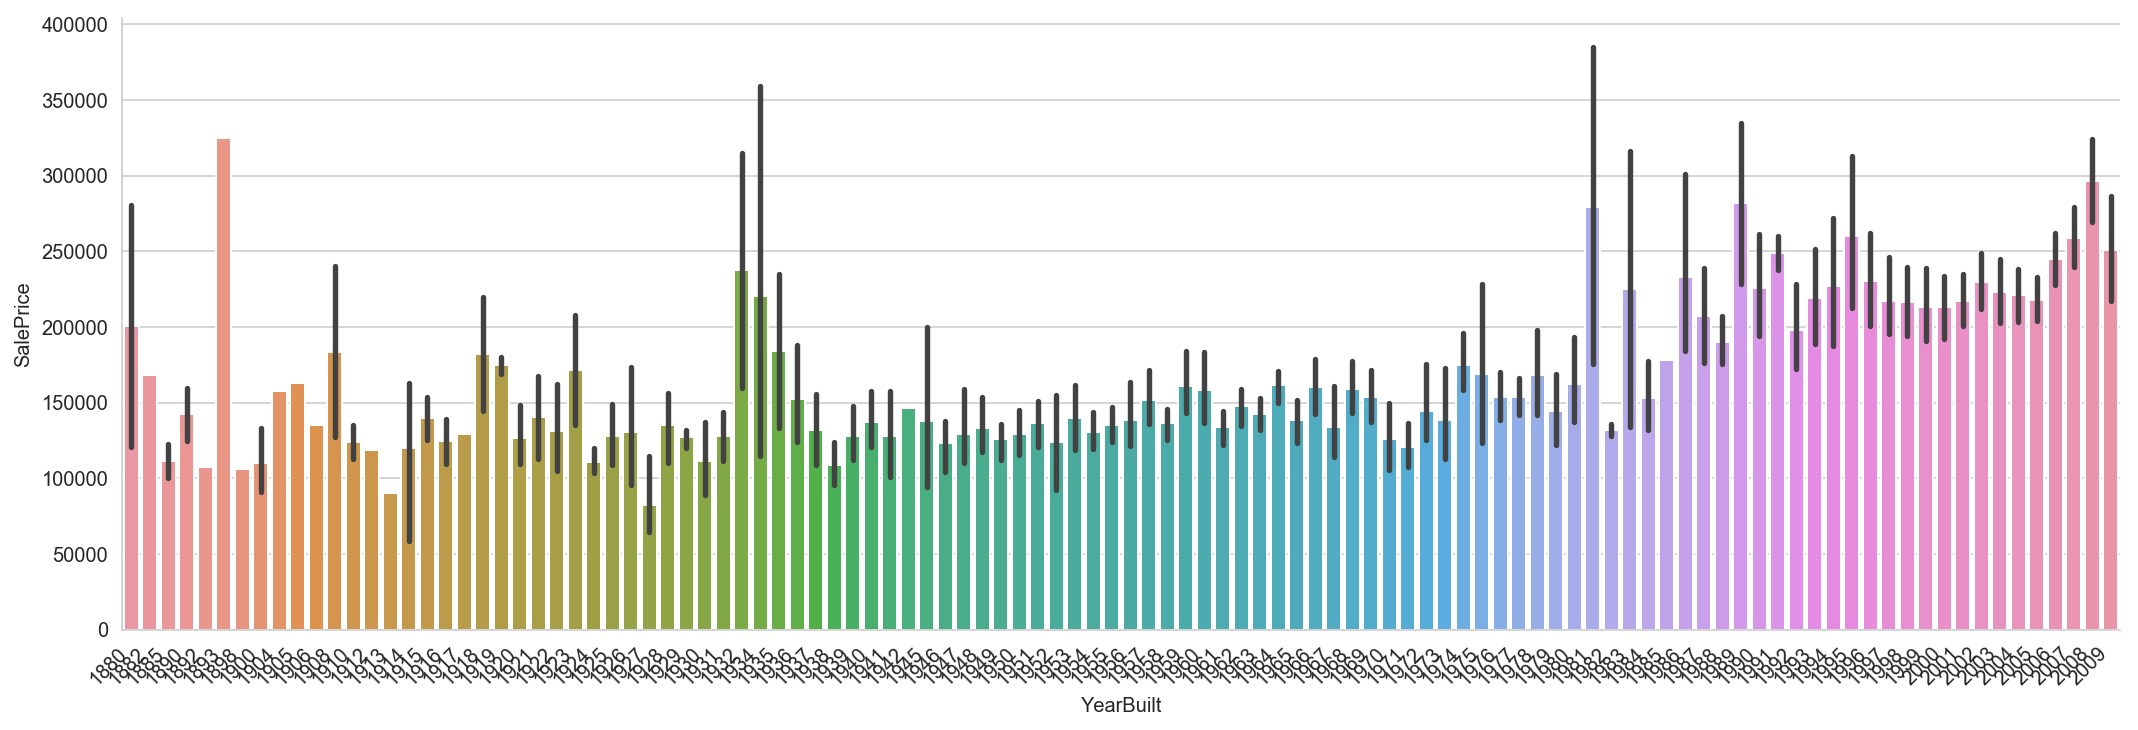

In [40]:
sns.catplot(x = 'YearBuilt', y = 'SalePrice', data = house, kind = 'bar',
            aspect = 3).set_xticklabels(rotation = 45, horizontalalignment = 'right')

It seems that we can devide all the values into 3 categories: 1880-1927, 1928-1980, 1981-2009

In [41]:
# deviding the years into non-uniform ranges
features['YearBuilt_binned'] = pd.cut(house['YearBuilt'], bins = np.array([1879, 1927, 1980, 2009]))

# converting the binned YearBuilt into dummy variable
YearBuilt_dummies = pd.get_dummies(features[['YearBuilt_binned']], drop_first = True)

# dropping the other columns related to YearBuilt
features.drop(['YearBuilt_binned'], axis = 1, inplace = True)

# adding the dummy variable to the dataframe
features = features.merge(YearBuilt_dummies, left_index = True, right_index = True, how = 'outer')

Let's see how we can categorize YearRemodAdd

In [42]:
# The mean SalePrice across all YearRemodAdd
house.groupby('YearRemodAdd')['SalePrice'].describe()['mean'].mean()

169189.95264623393

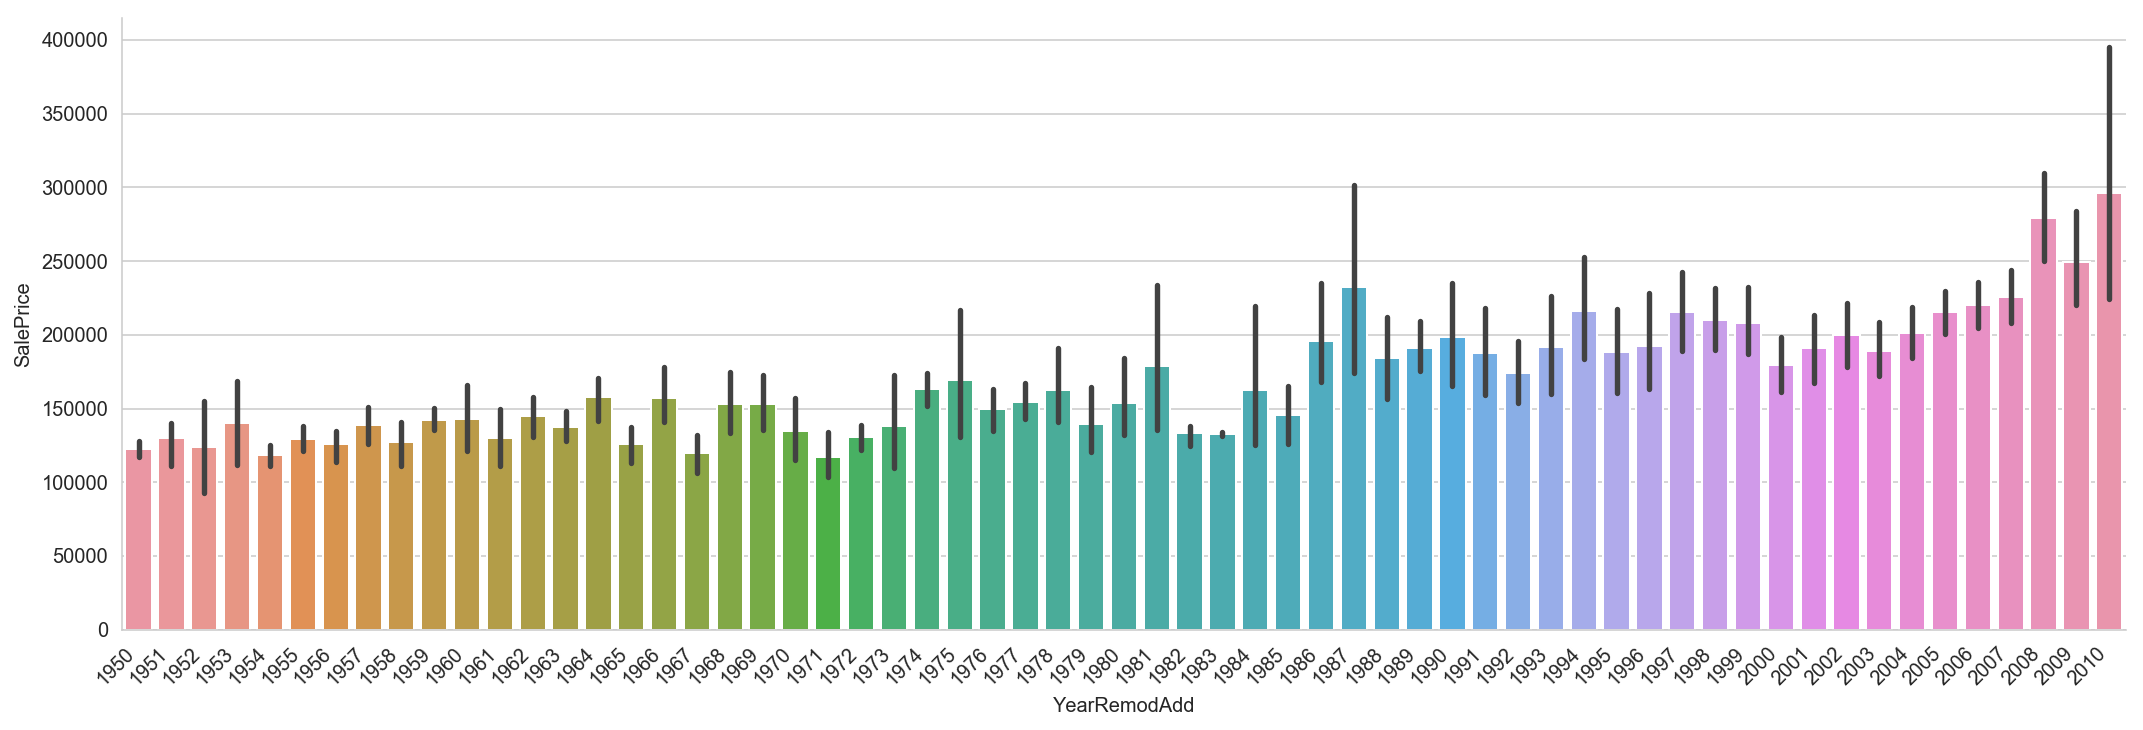

In [43]:
sns.catplot(x = 'YearRemodAdd', y = 'SalePrice', data = house, kind = 'bar',
            aspect = 3).set_xticklabels(rotation = 45, horizontalalignment = 'right')

It seems that we can devide all the values into 2 categories: 1950-1985, 1986-2010

In [44]:
# deviding the years into non-uniform ranges
features['YearRemodAdd_binned'] = pd.cut(house['YearRemodAdd'], bins = np.array([1949, 1985, 2010]))

# converting the binned YearRemodAdd into dummy variable
YearRemodAdd_dummies = pd.get_dummies(features[['YearRemodAdd_binned']], drop_first = True)

# dropping the other columns related to YearRemodAdd
features.drop(['YearRemodAdd_binned'], axis = 1, inplace = True)

# adding the dummy variable to the dataframe
features = features.merge(YearRemodAdd_dummies, left_index = True, right_index = True, how = 'outer')

Let's see how we can categorize GarageYrBlt

In [45]:
# The mean SalePrice across all GarageYrBlt
house.groupby('GarageYrBlt')['SalePrice'].describe()['mean'].mean()

164841.31407477232

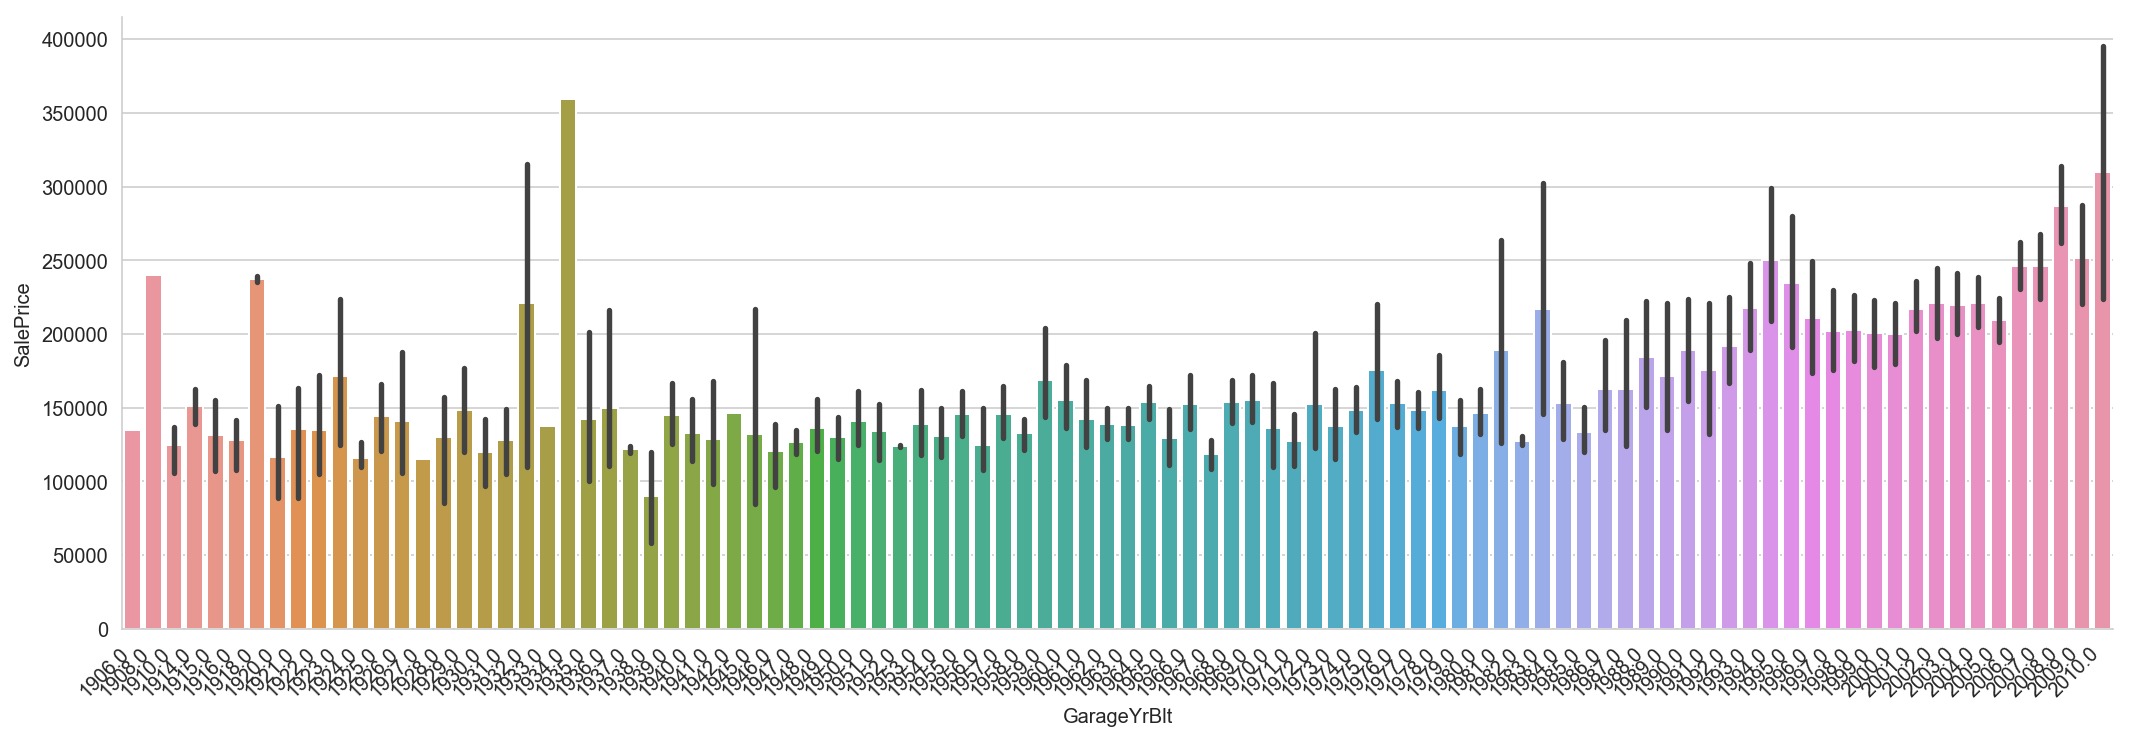

In [46]:
sns.catplot(x = 'GarageYrBlt', y = 'SalePrice', data = house, kind = 'bar',
            aspect = 3).set_xticklabels(rotation = 45, horizontalalignment = 'right')

It seems that we can devide all the values into 2 categories: 1906-1985, 1986-2010

In [47]:
# deviding the years into non-uniform ranges
features['GarageYrBlt_binned'] = pd.cut(house['GarageYrBlt'], bins = np.array([1906, 1985, 2010]))

# converting the binned GarageYrBlt into dummy variable
GarageYrBlt_dummies = pd.get_dummies(features[['GarageYrBlt_binned']], drop_first = True)

# dropping the other columns related to GarageYrBlt
features.drop(['GarageYrBlt_binned'], axis = 1, inplace = True)

# adding the dummy variable to the dataframe
features = features.merge(GarageYrBlt_dummies, left_index = True, right_index = True, how = 'outer')

By plotting the mean of SalePrice for each class of a categorical variable, we decide if that variable has an effect on SalePrice. For instance, if the means of SalePrice for most of the classes of a categorical variable are the same, that variable cannot help us with estimating SalePrice.
So we plot the mean of SalePrice for the categorical variables and decide if we want to select them as features.

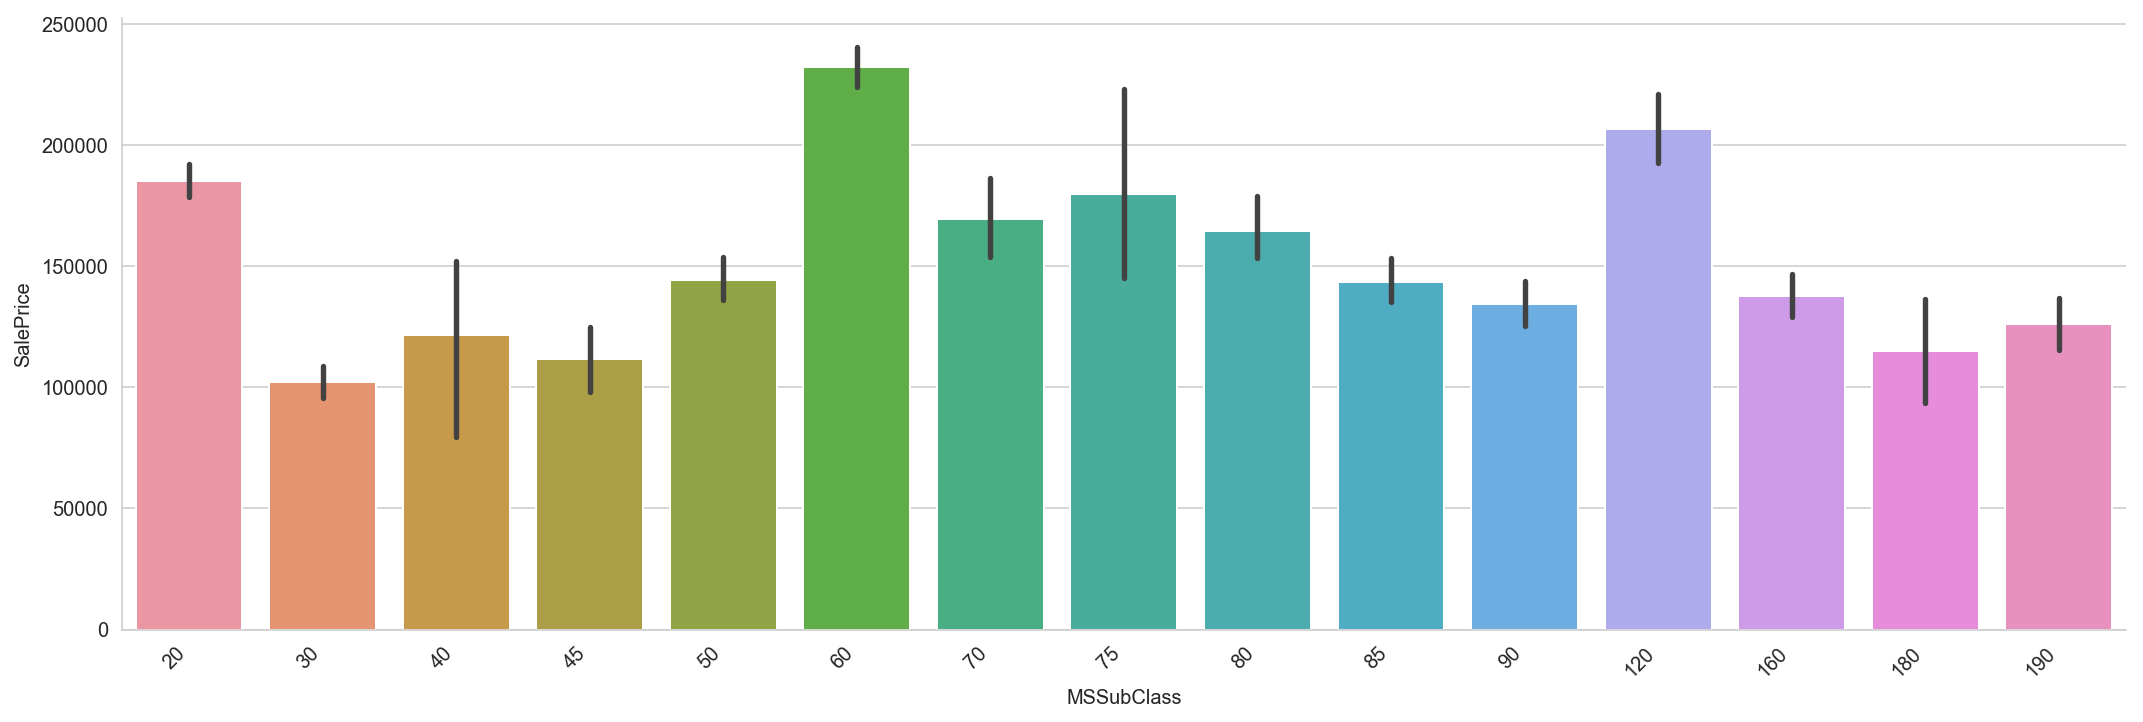

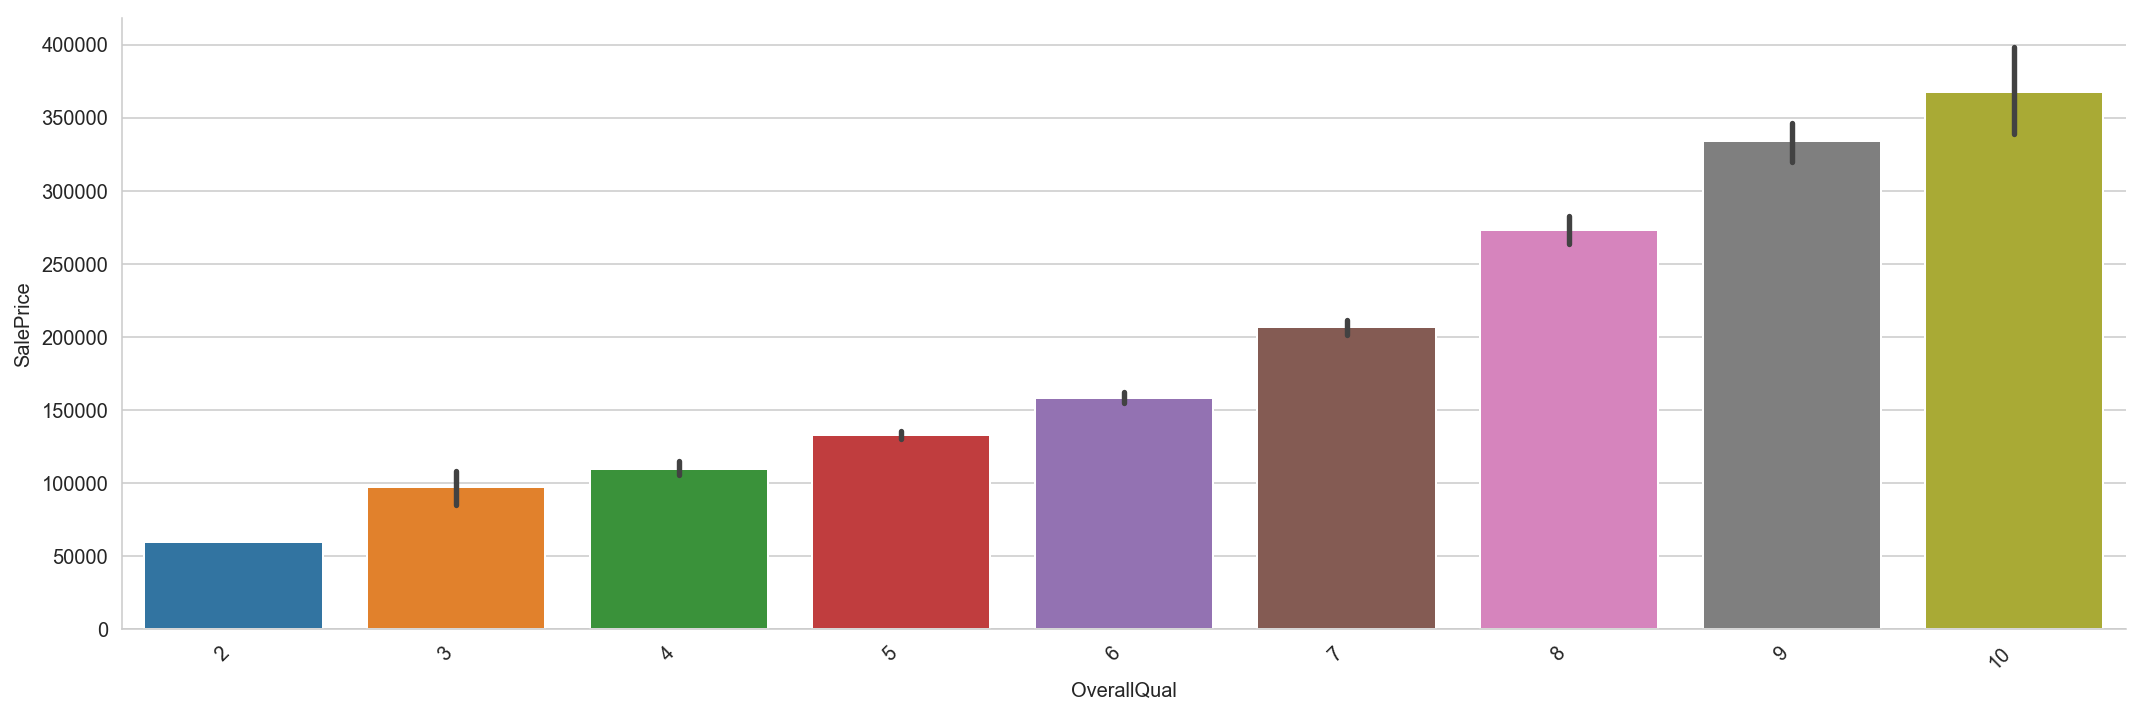

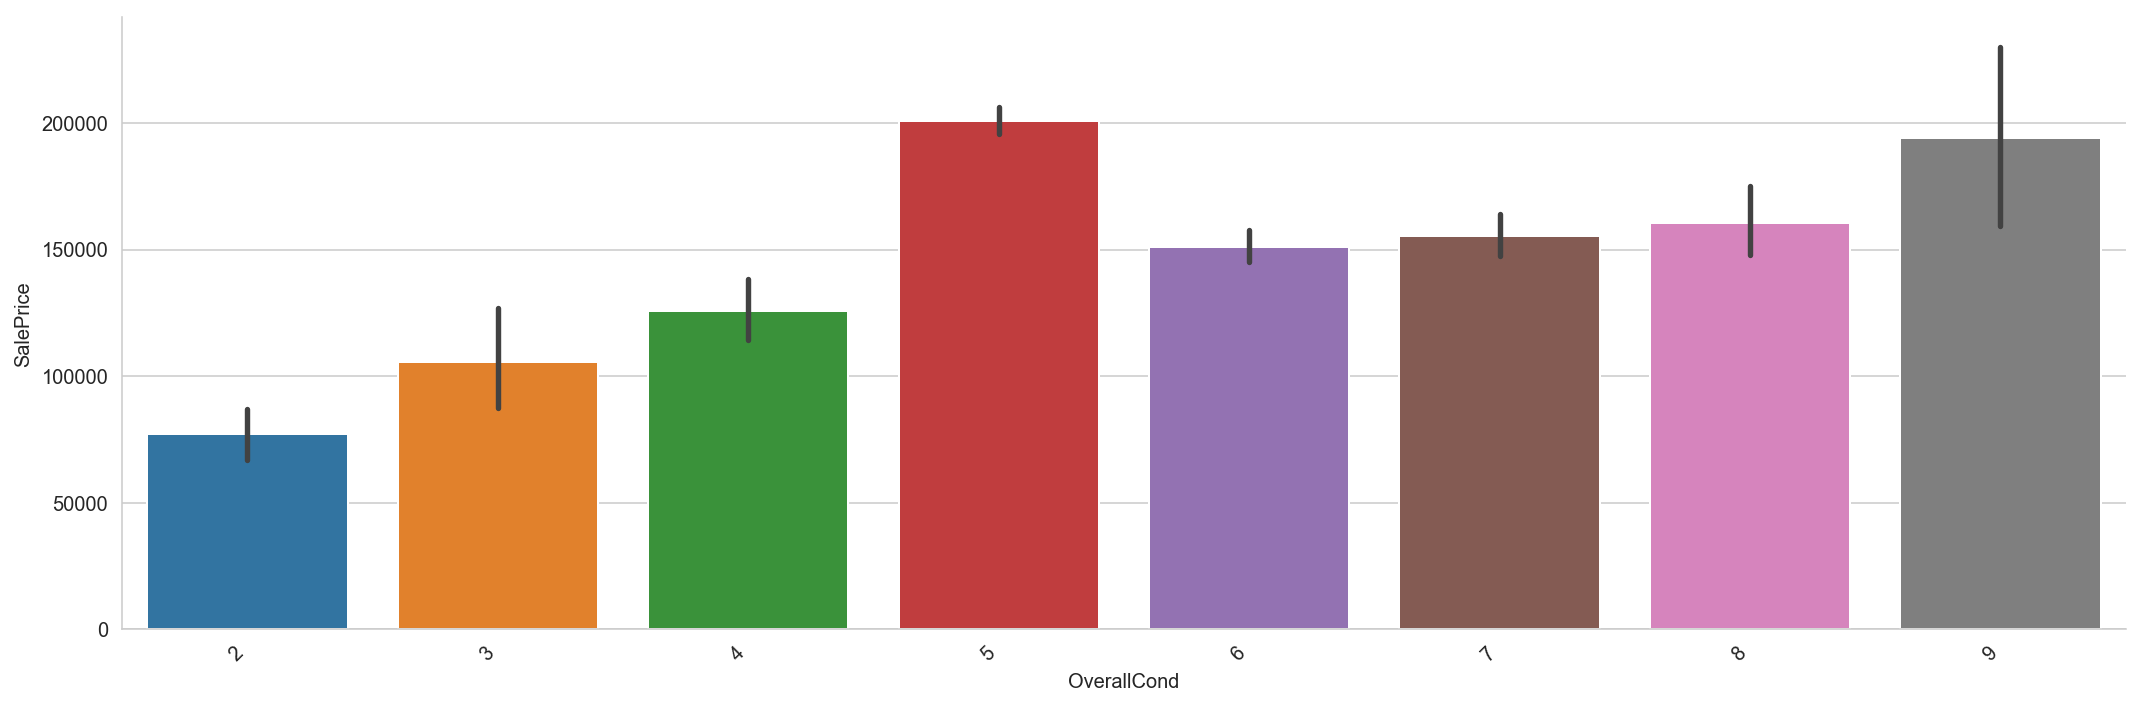

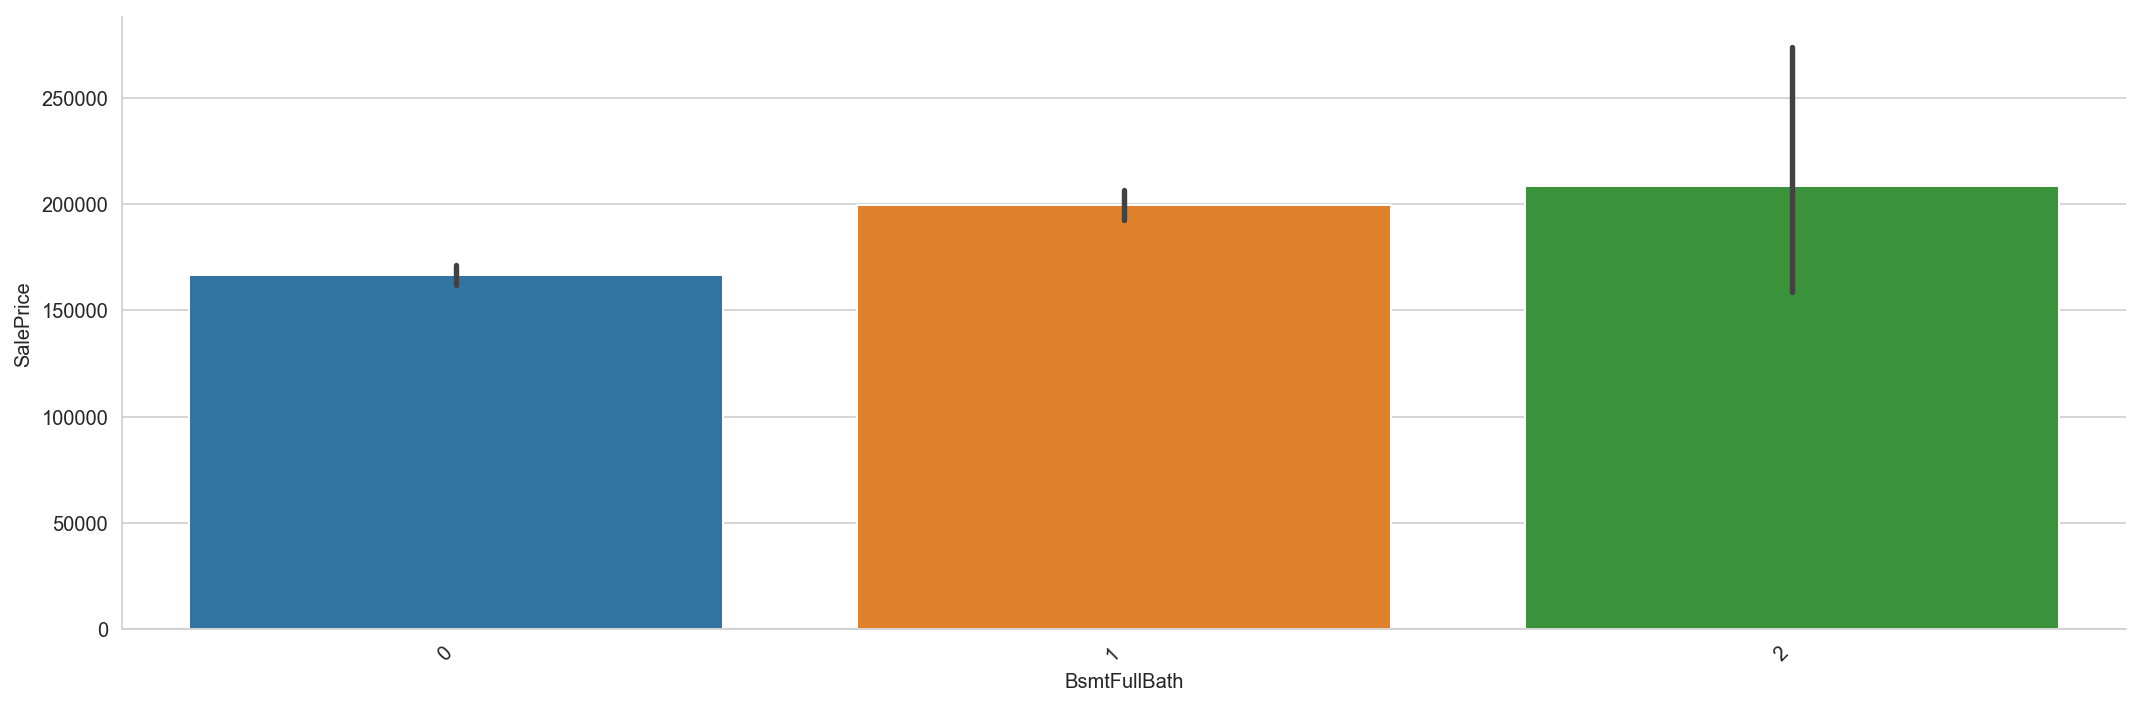

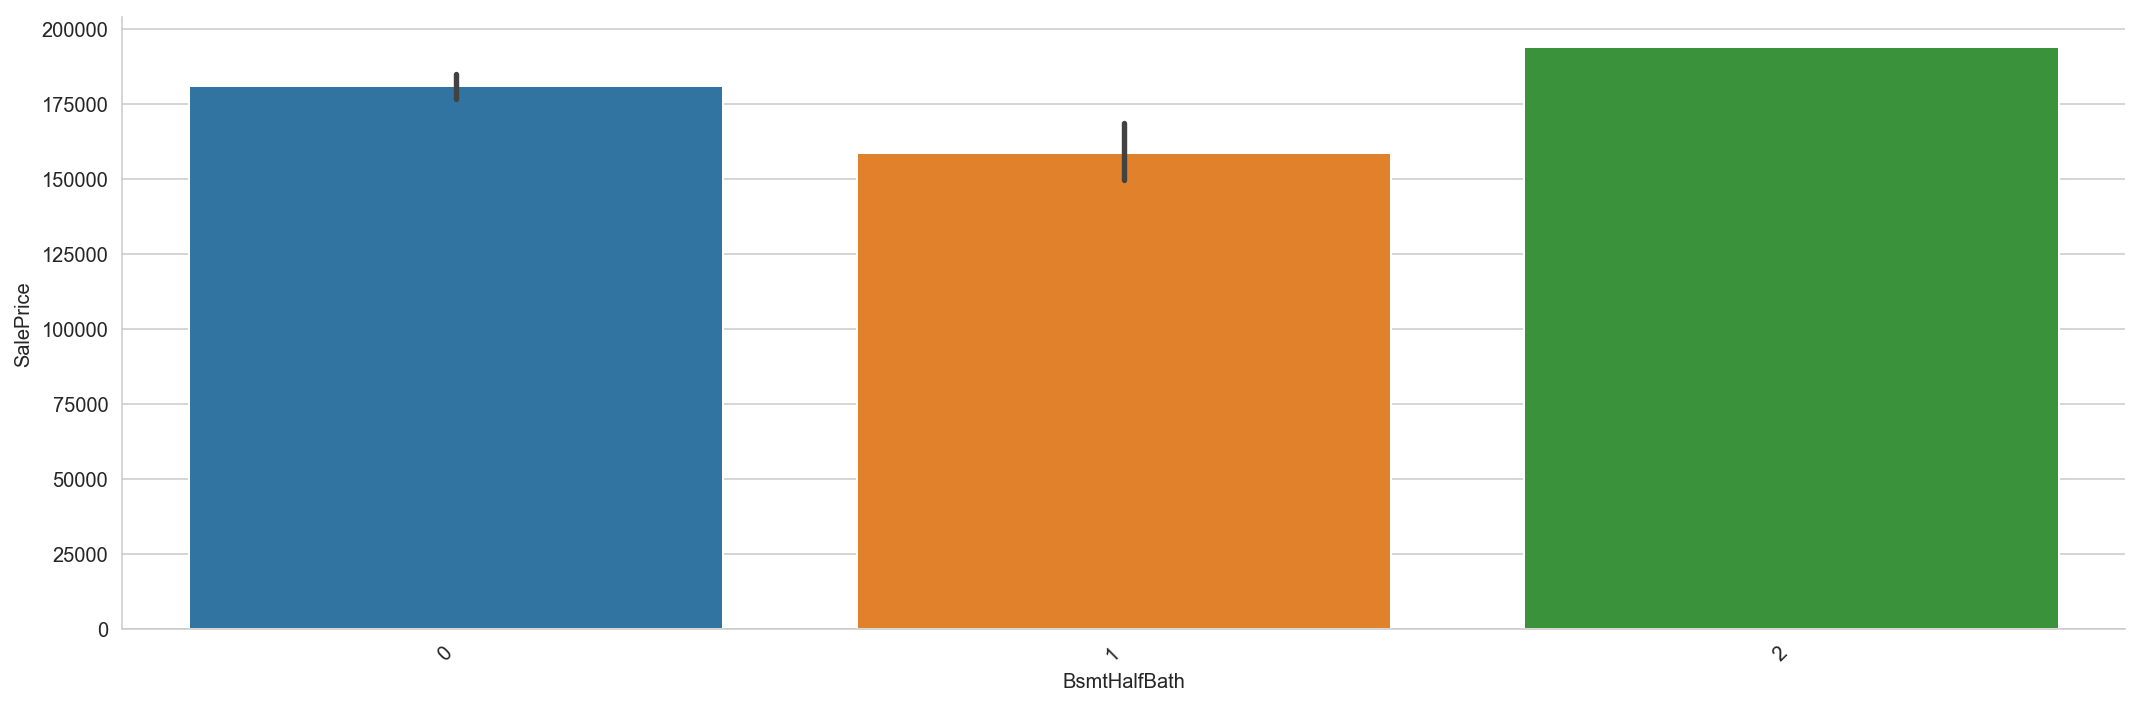

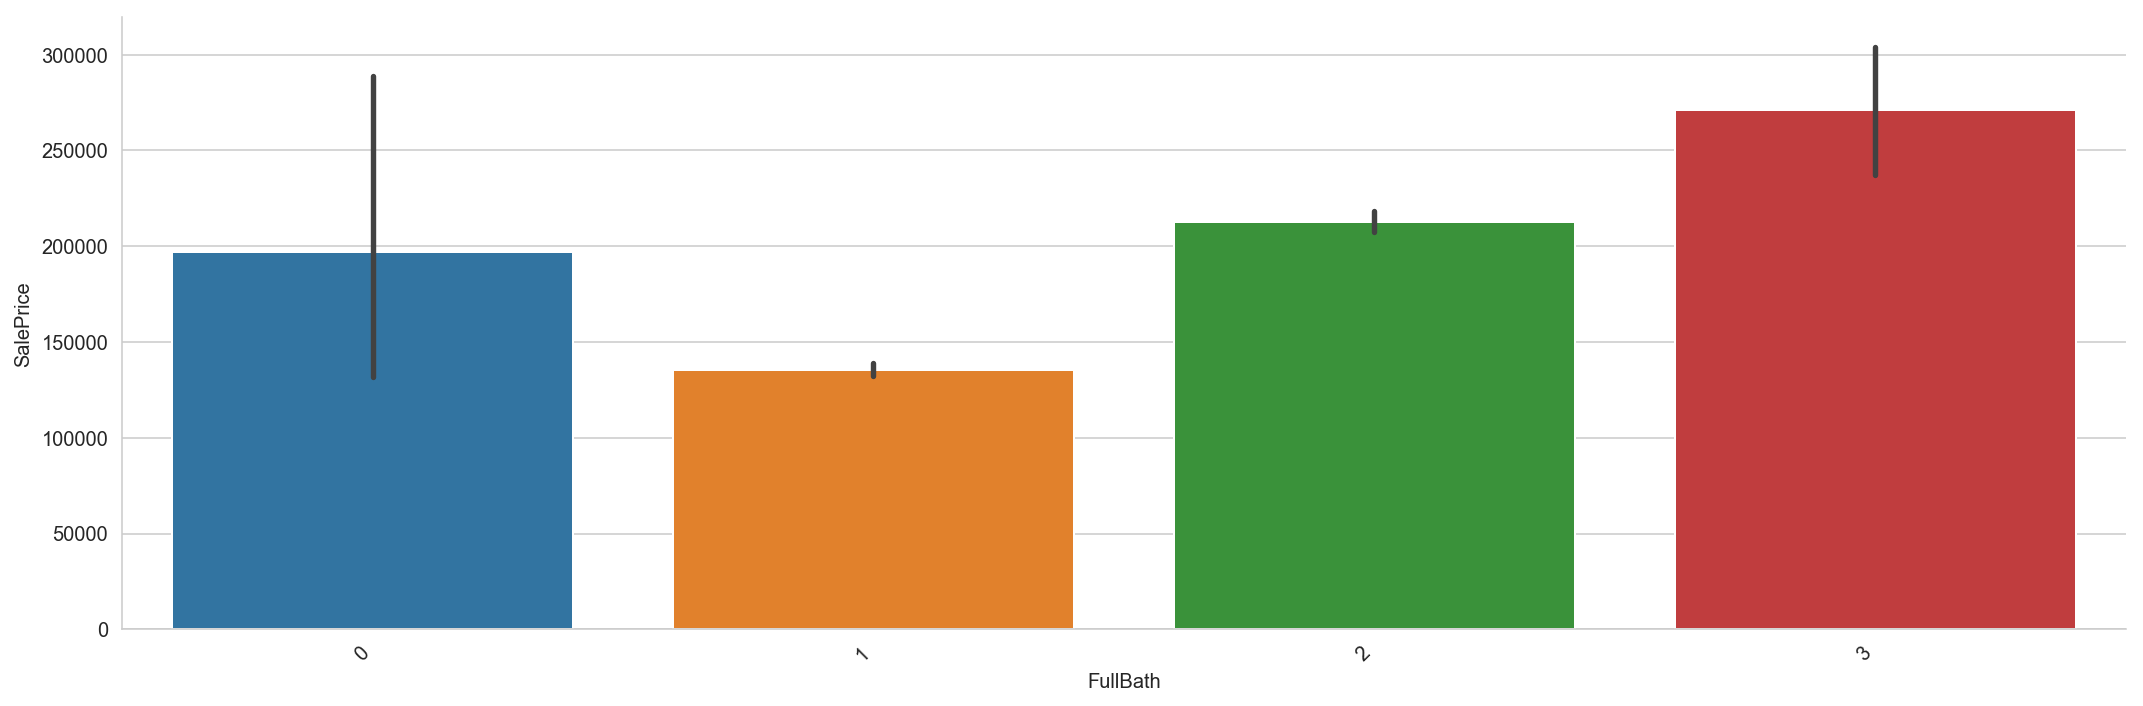

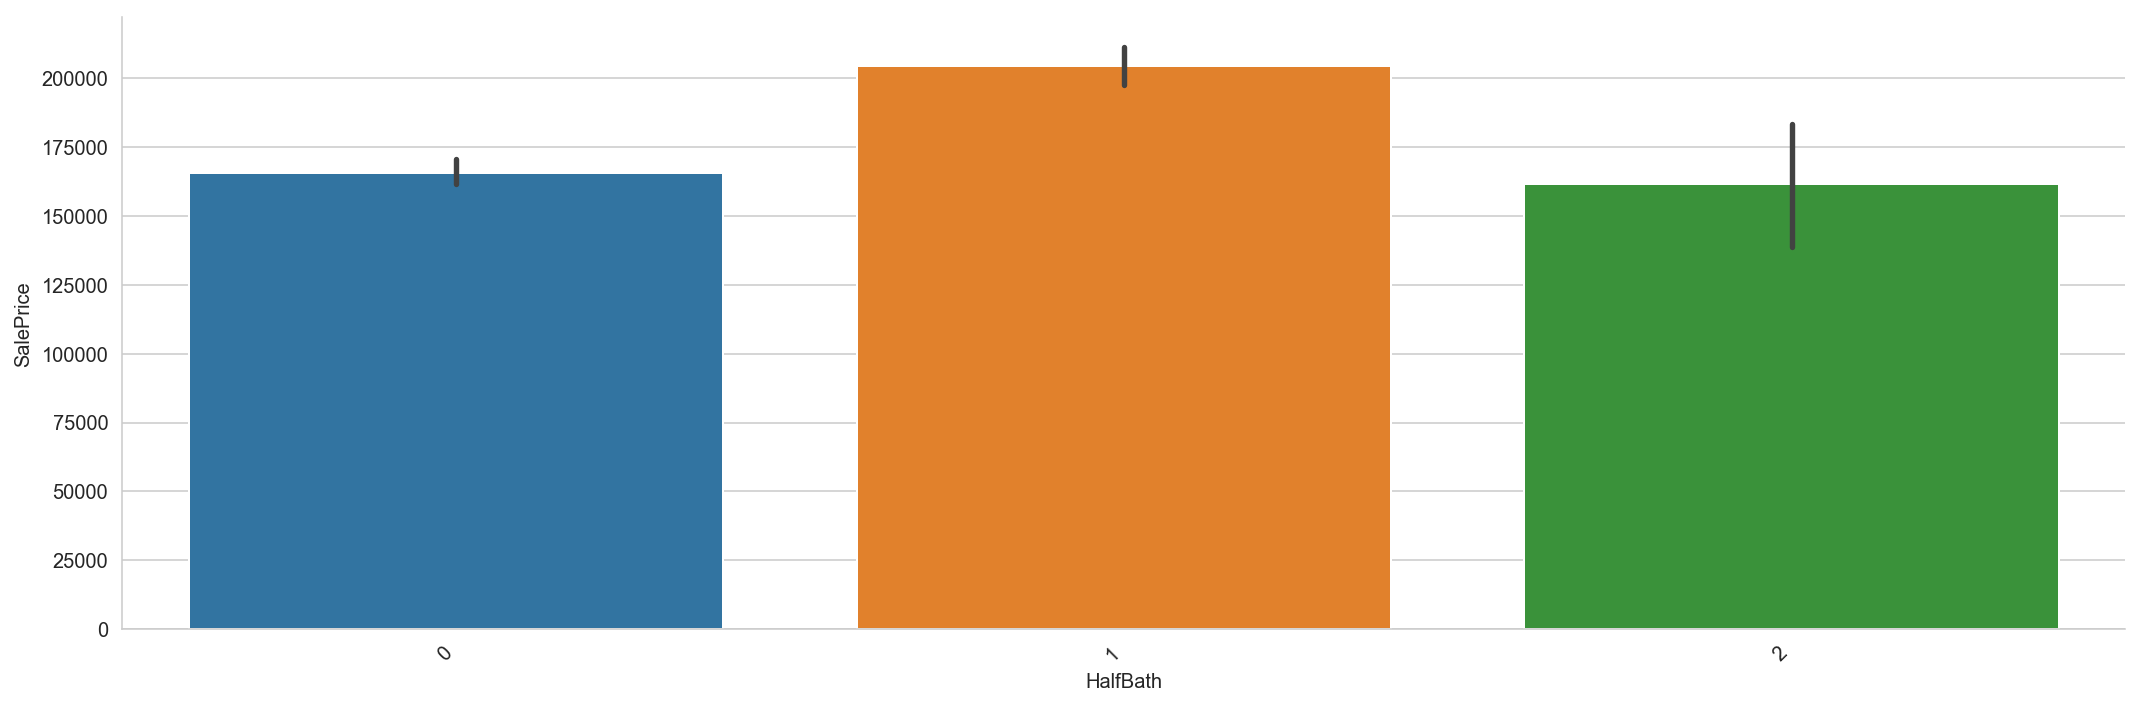

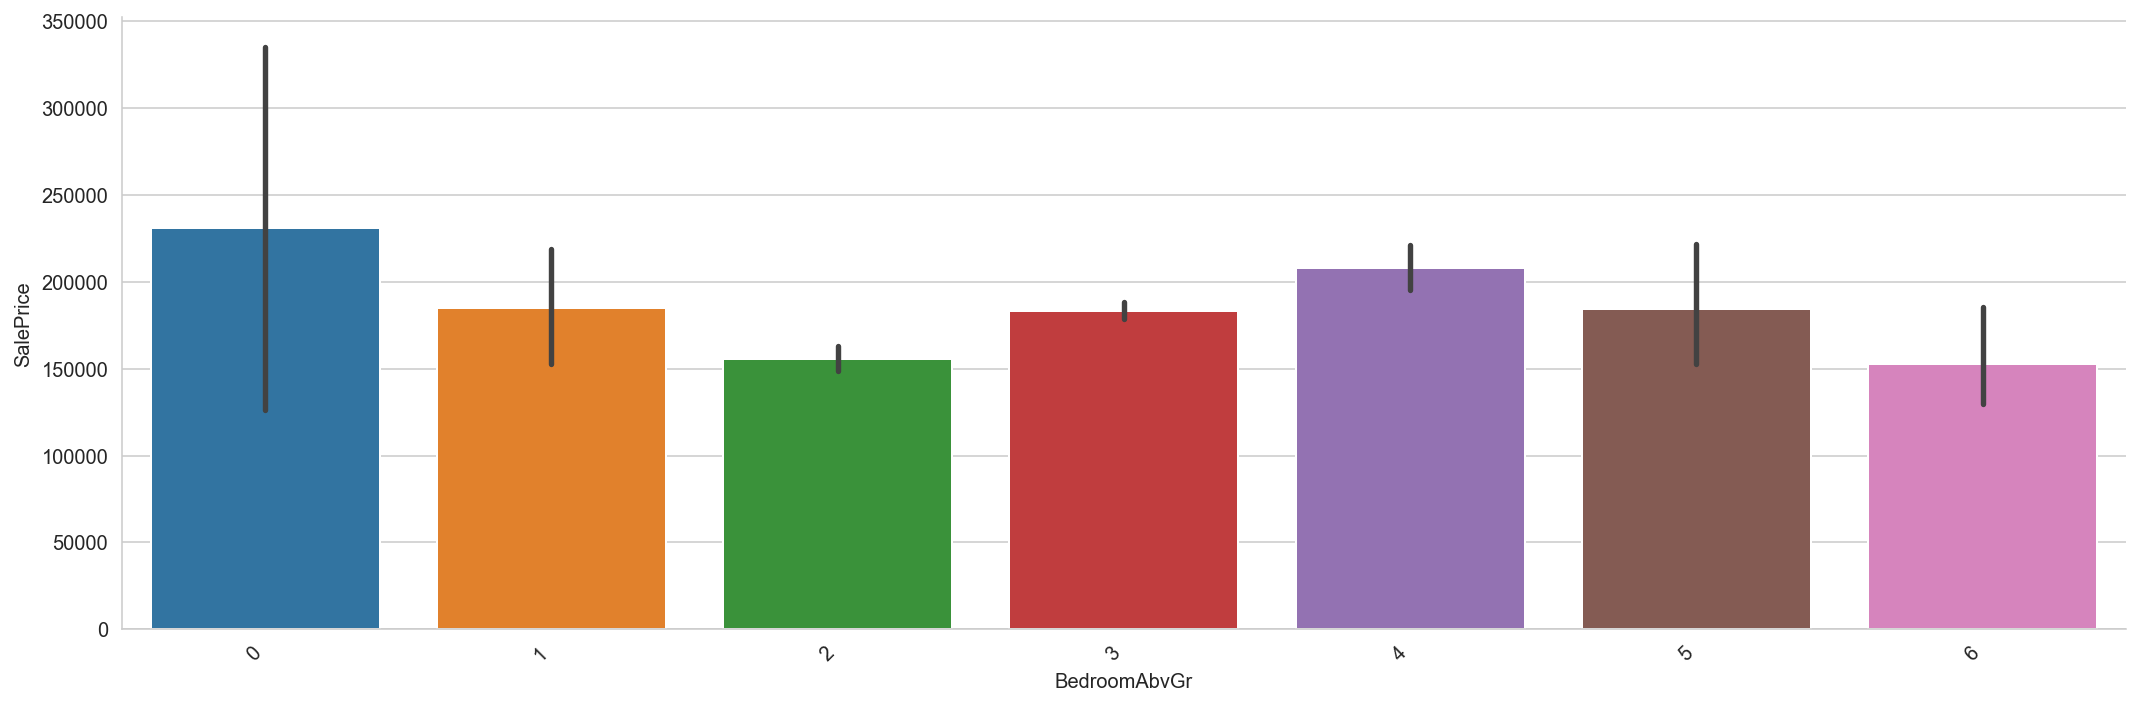

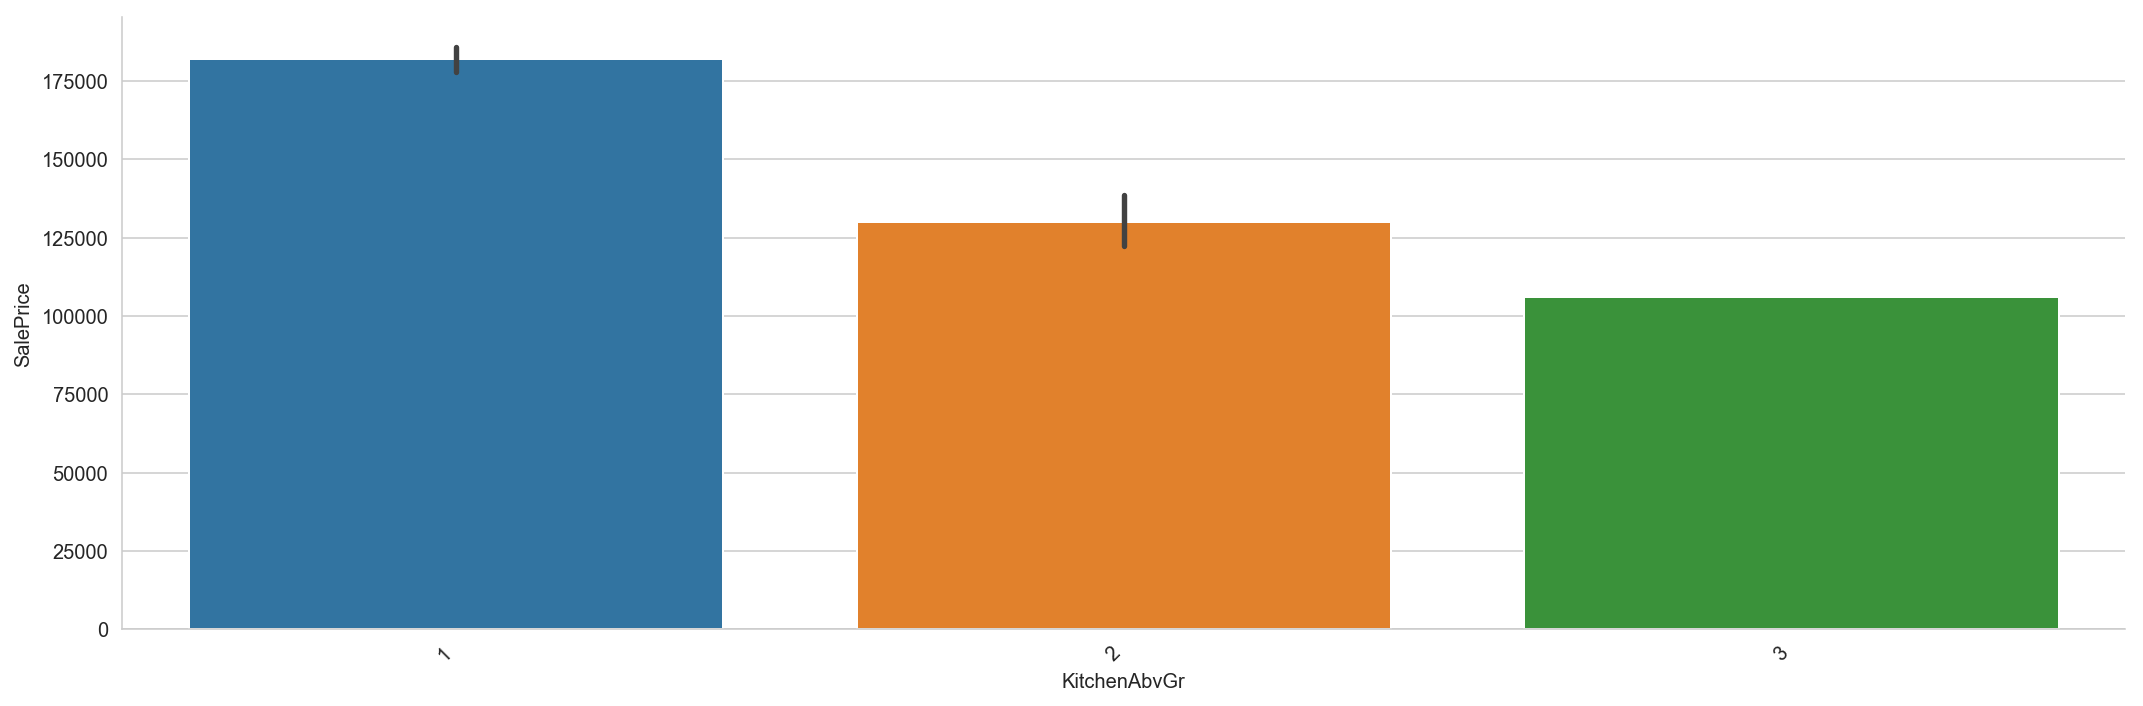

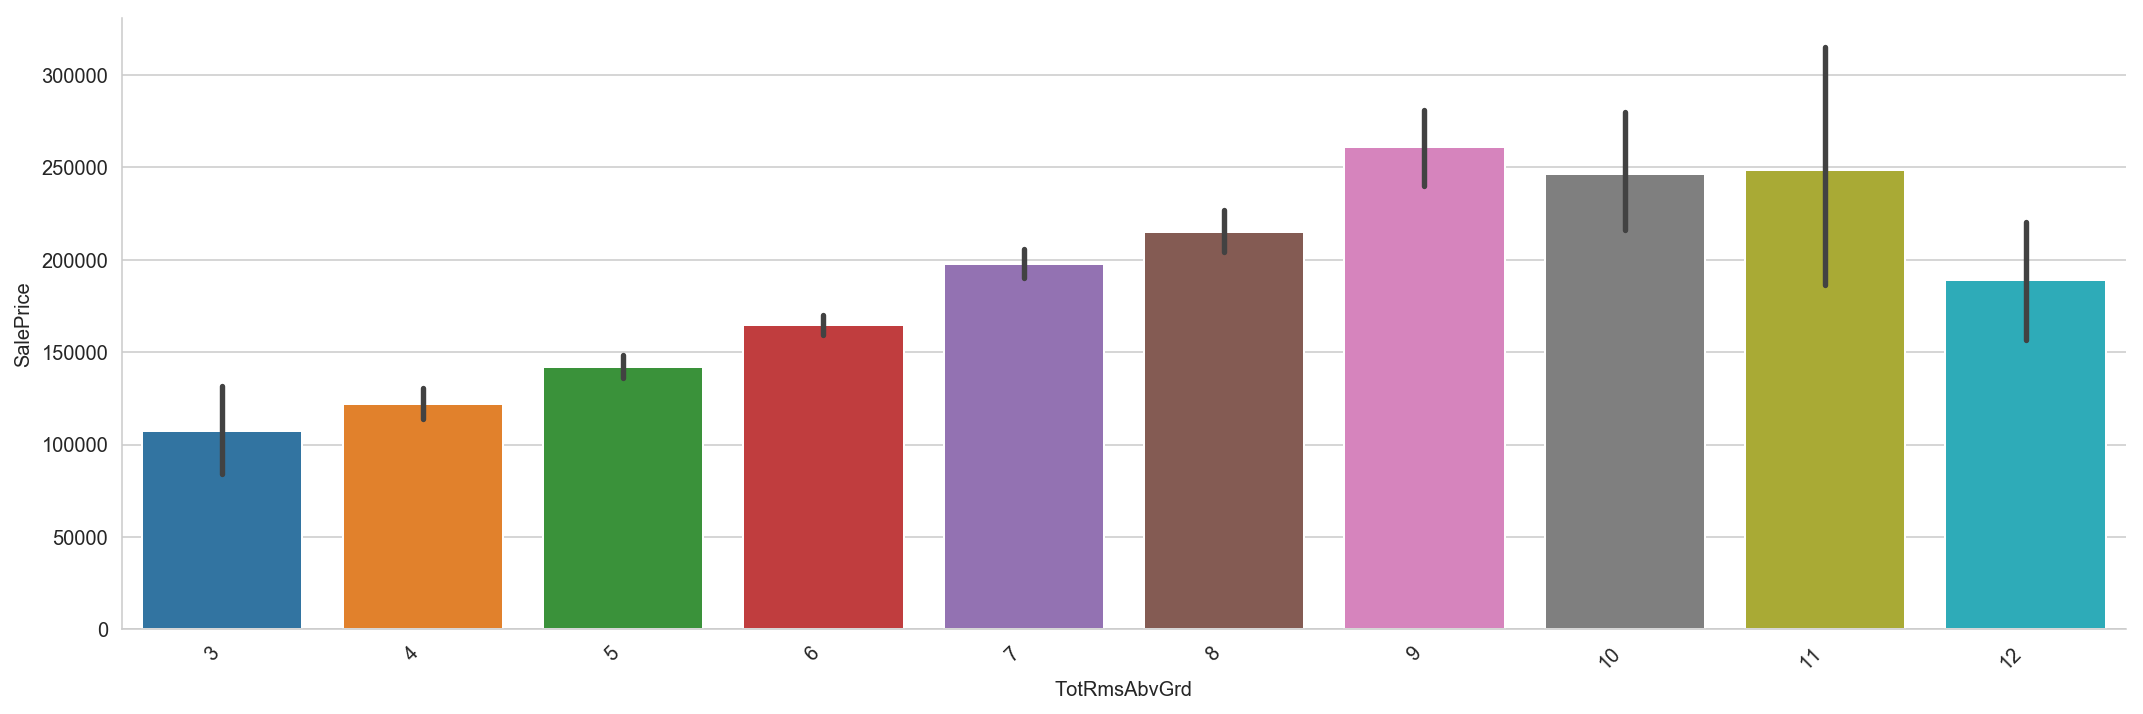

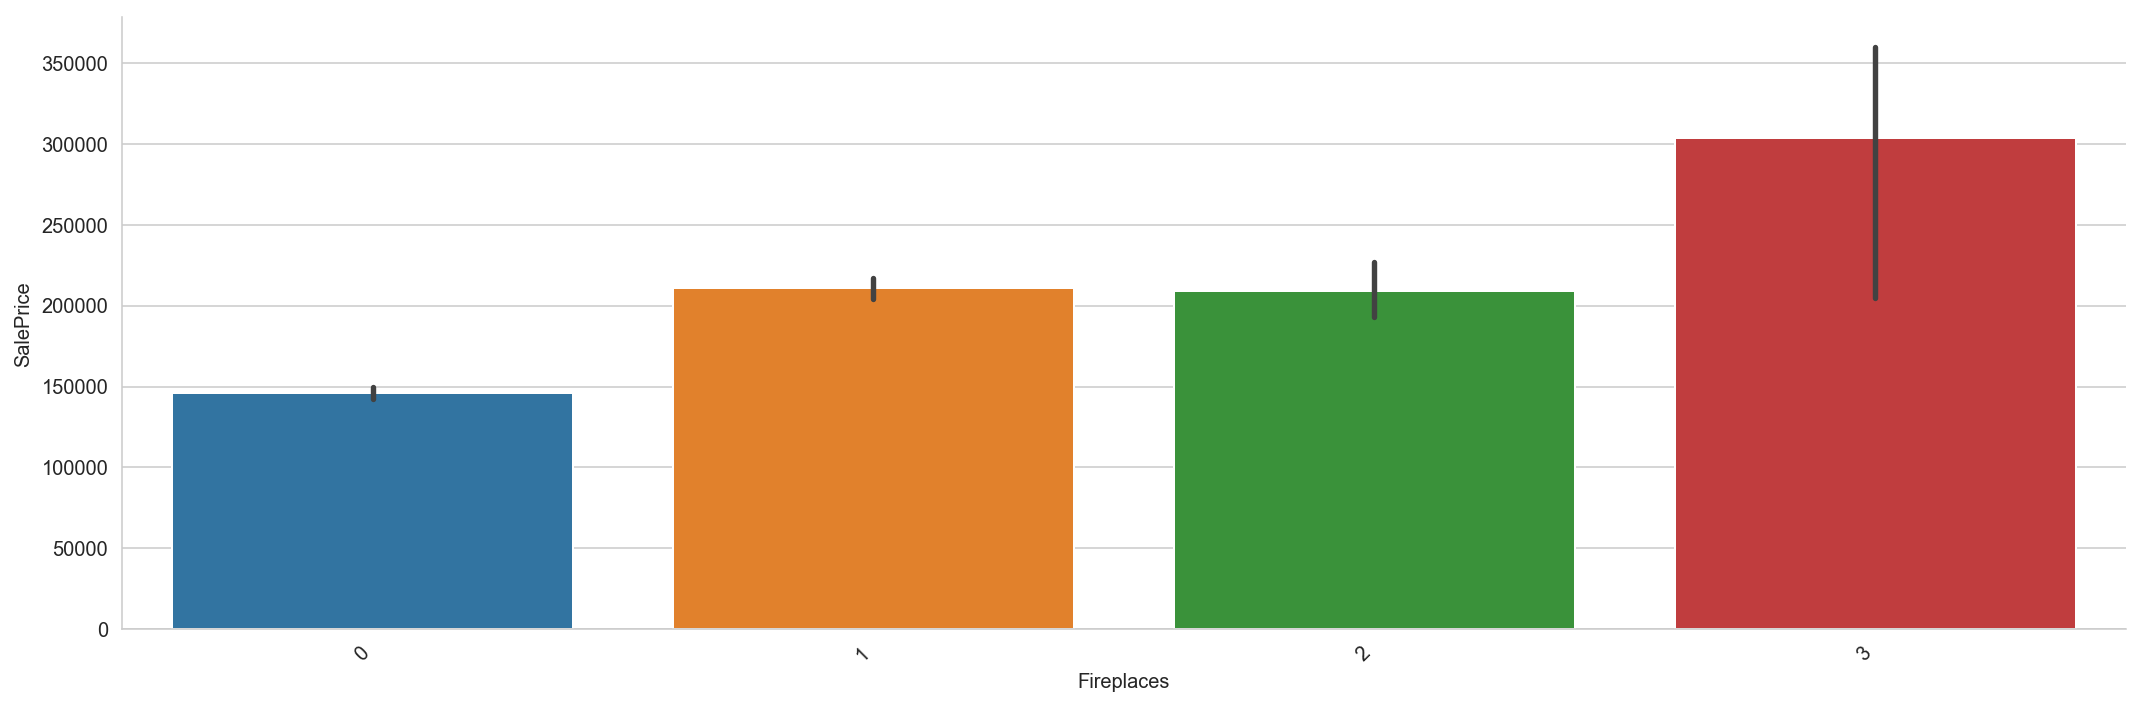

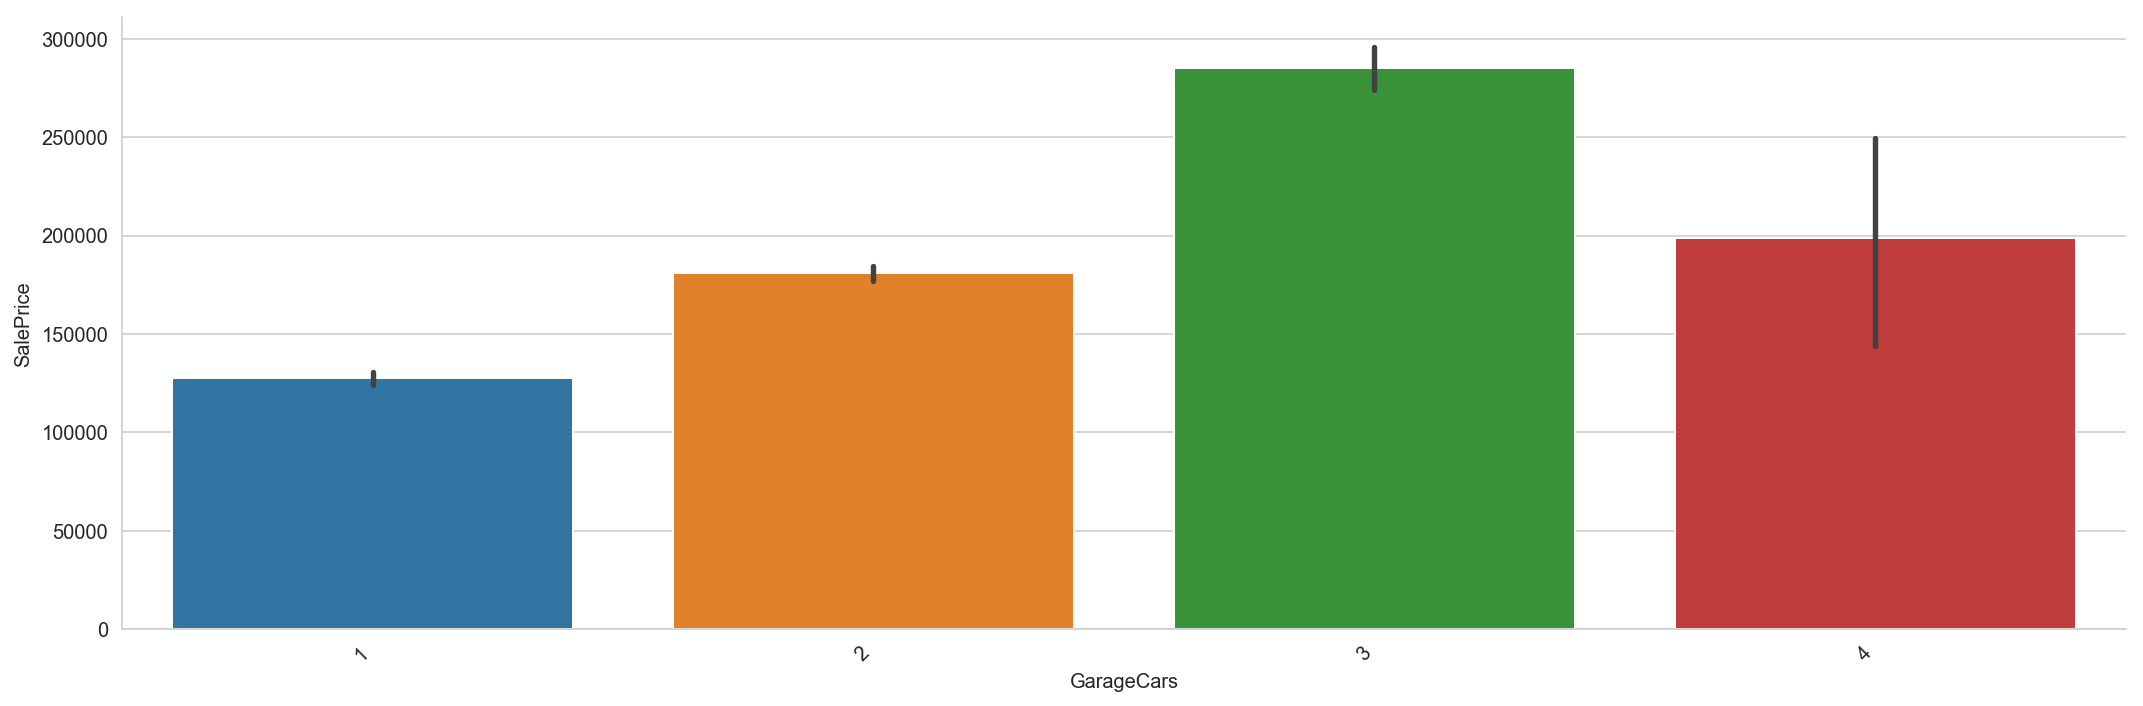

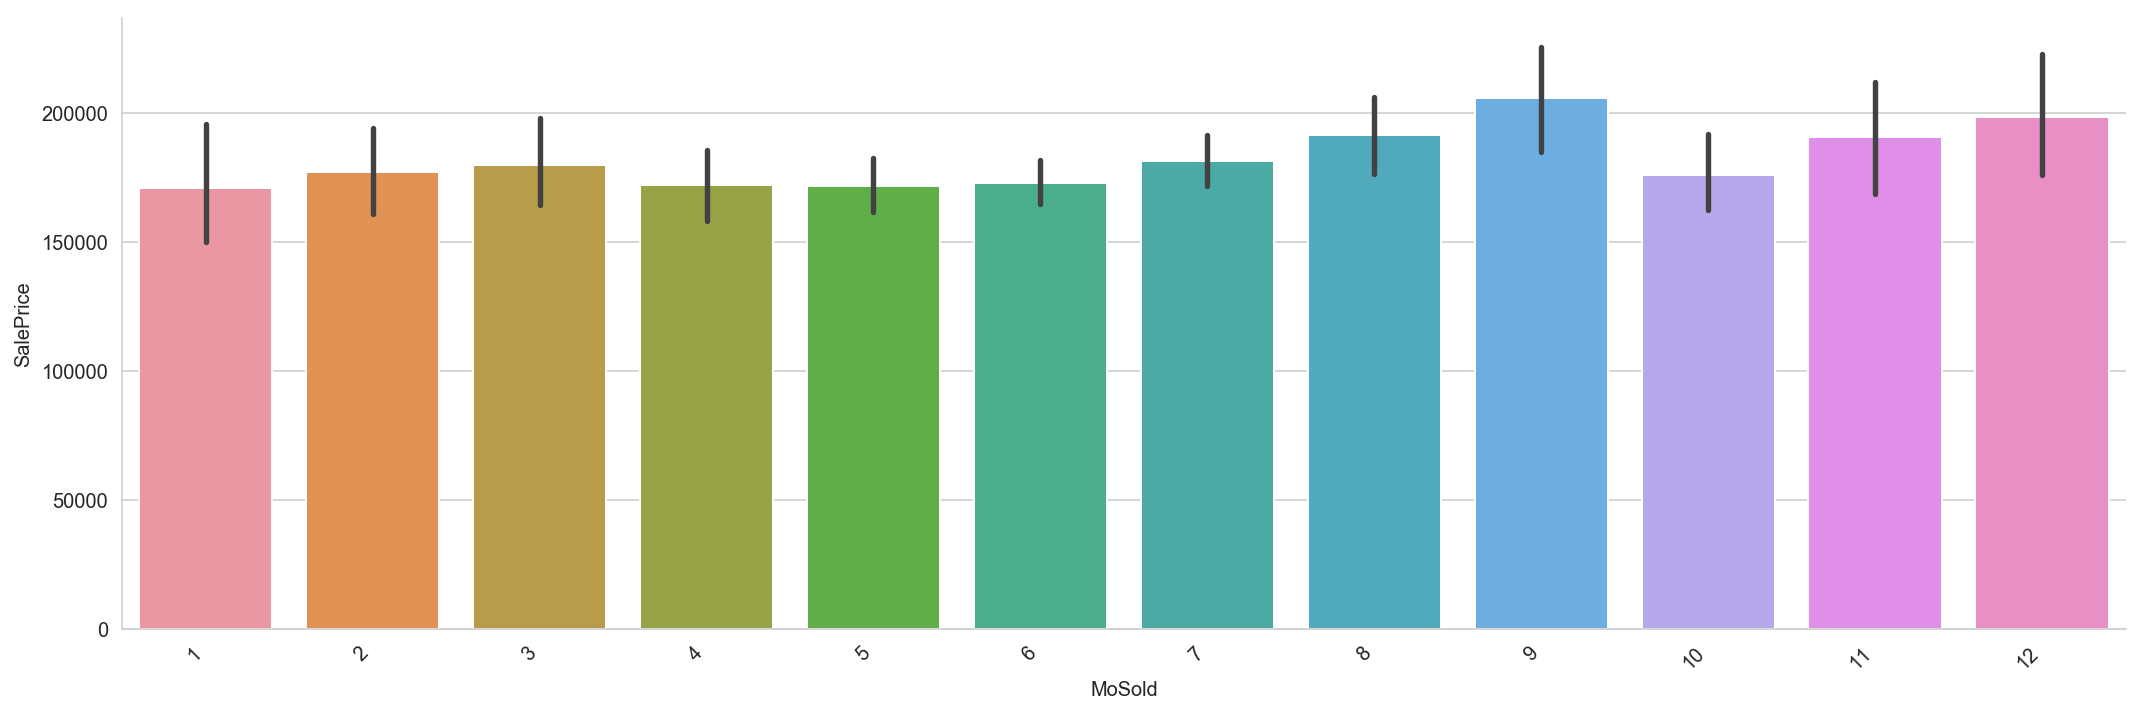

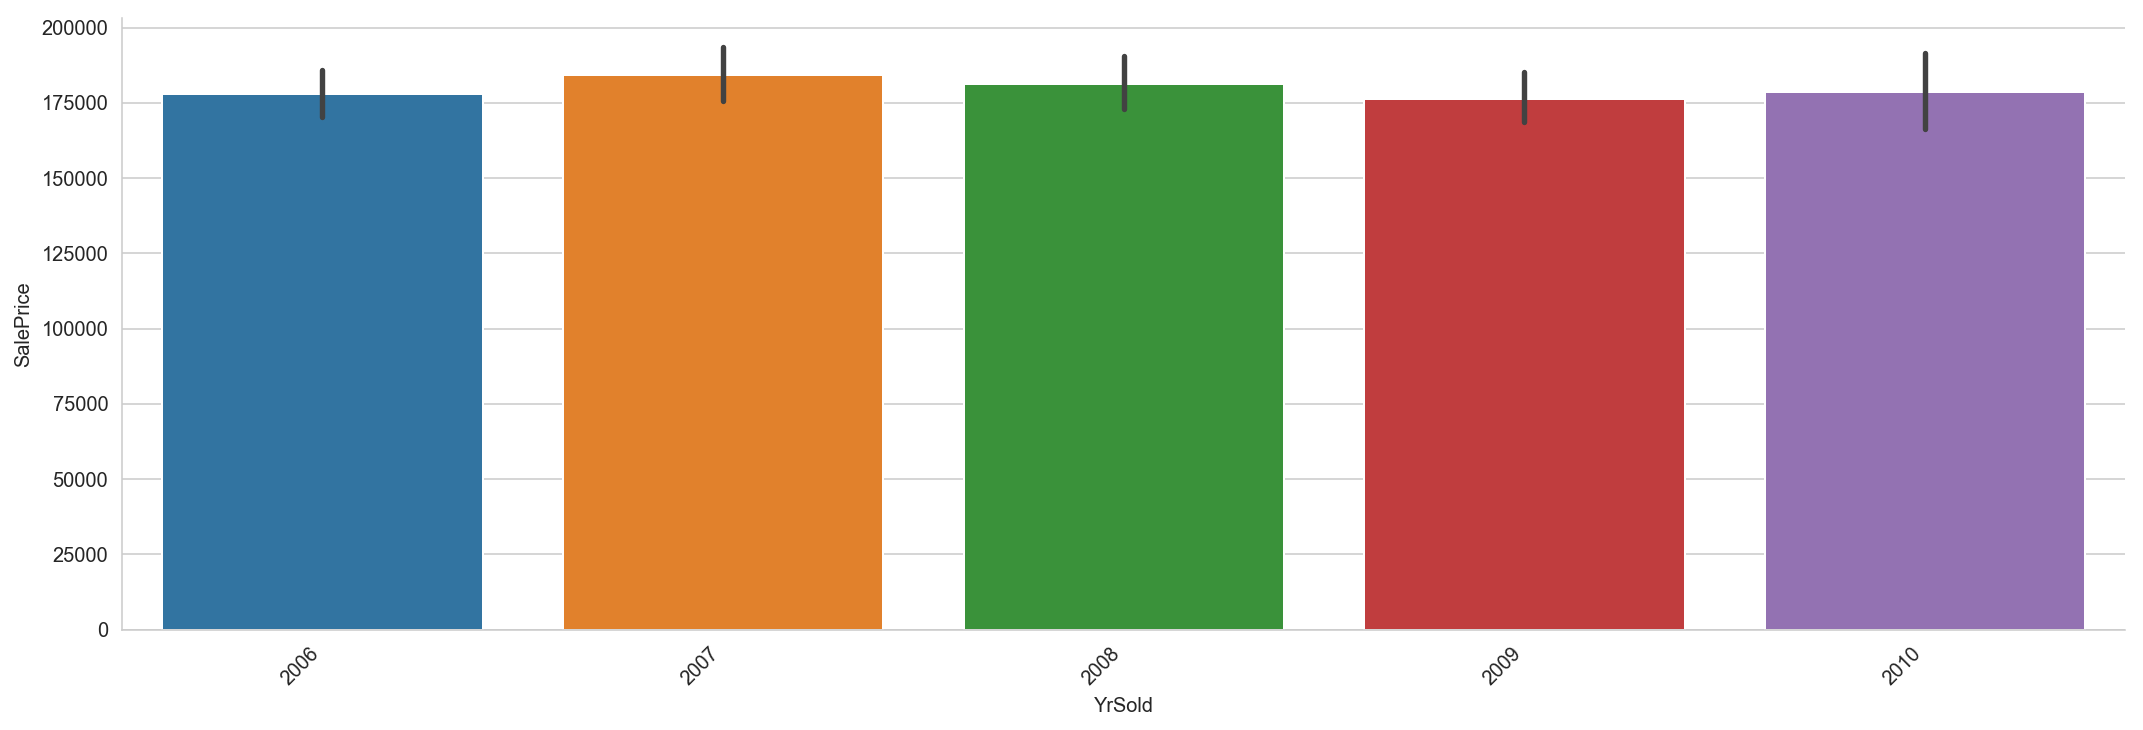

In [48]:
for var in cat_but_num:
    if var not in ['YearBuilt', 'YearRemodAdd', 'GarageYrBlt']:
        sns.catplot(x = var, y = 'SalePrice', data = house, kind = 'bar',
            aspect = 3).set_xticklabels(rotation = 45, horizontalalignment = 'right')

We choose the variables that have more variance in the mean SalePrice across different classes, since they can give us more information about SalePrice.
With this logic, we can just focus on these variables:
    - MSSubClass
    - OverallQual
    - OverallCond
    - FullBath
    - KitchenAbvGr
    - TotRmsAbvGrd

In [49]:
# defining the classes of MSSubClass differently
features['MSSubClass_[20, 60, 75, 120]'] = house.MSSubClass.map(lambda x: 1 if x in [20, 60, 75, 120] else 0)

In [50]:
# checking how many houses exist in each class of FullBath
house.FullBath.value_counts()

2    587
1    477
3     18
0      5
Name: FullBath, dtype: int64

In [51]:
# since there are few houses of class 0, we put them in the same class with class 1
features['FullBath_[(0,1), 2, 3]'] = house.FullBath.map(lambda x: 1 if x == 0 else x)

We leave OverallQual, OverallCond, KitchenAbvGr and TotRmsAbvGrd as they are since they are already well-defined.
We are not going to choose OverallQual and OverallCond as features now since they are not fixed characteristics, but in case we want to use them later, they are ready.

Up to this point we have checked the numerical variables, including the ones that we consider categorical and are expressed in terms of numbers.
Now it is time to check other fixed categorical characteristics.

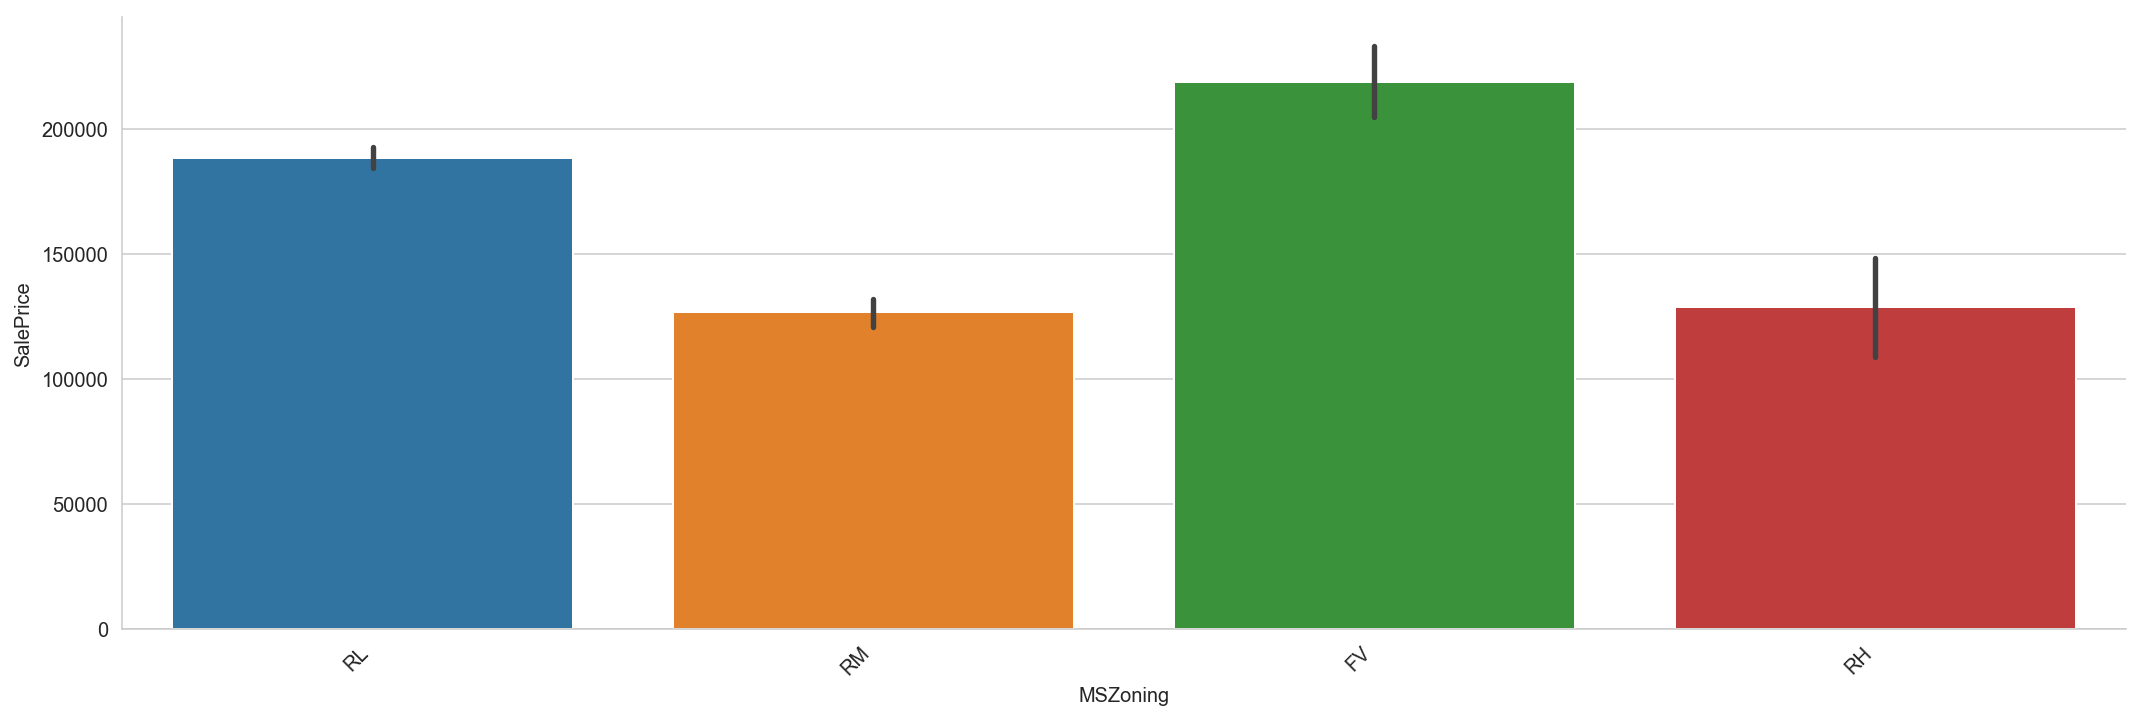

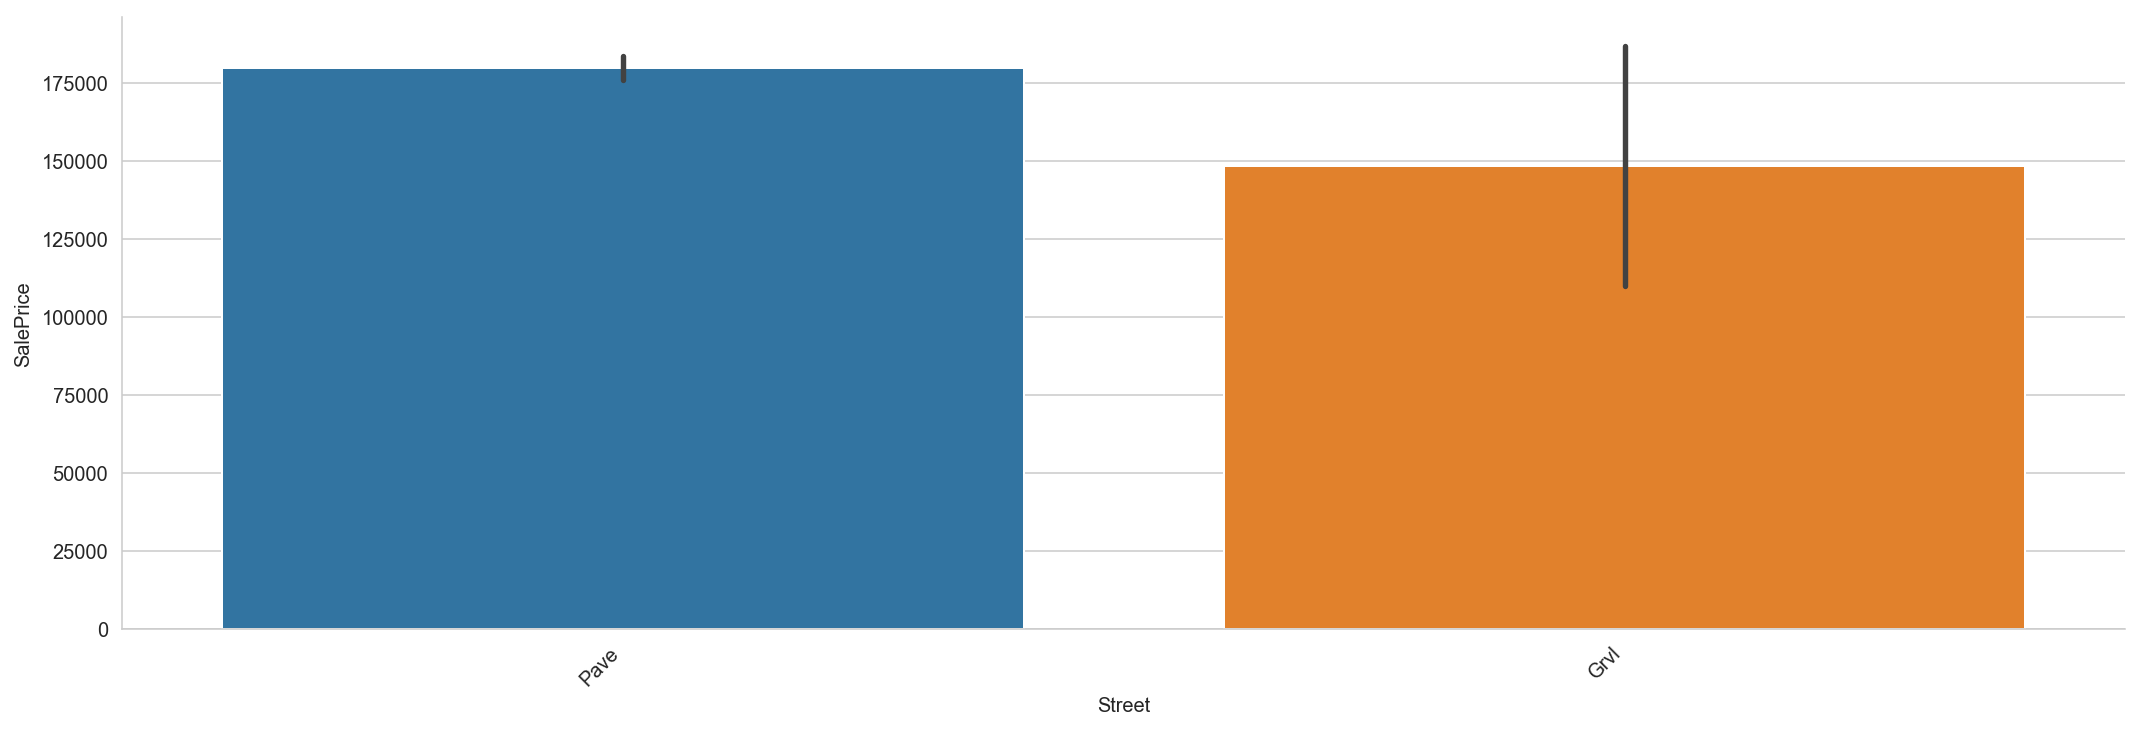

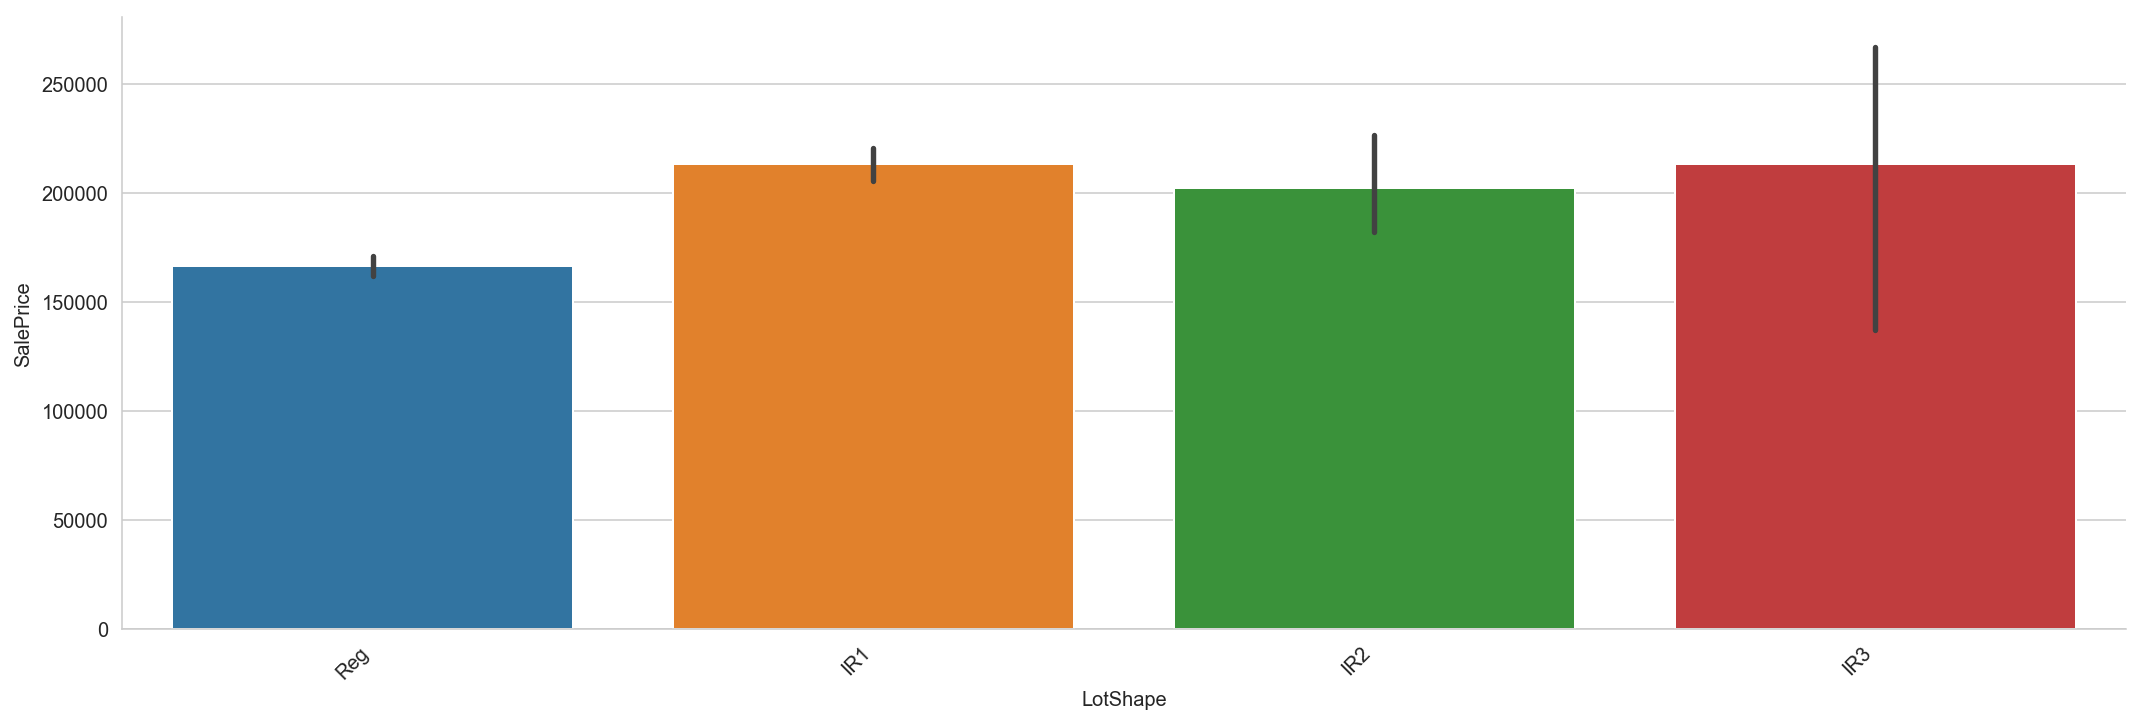

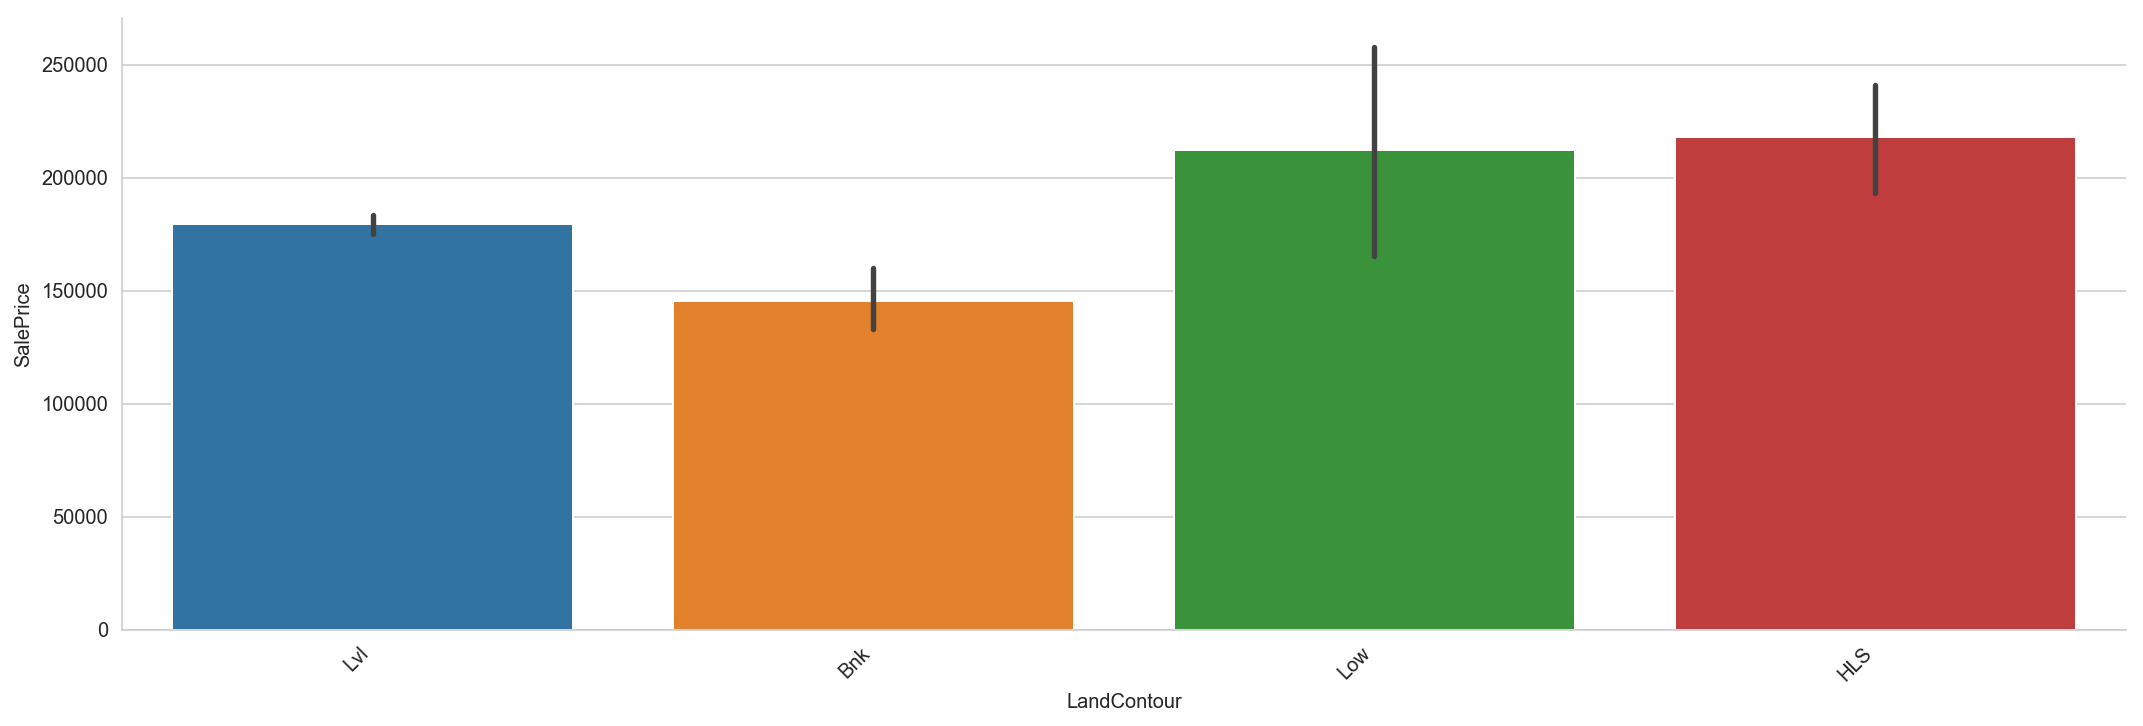

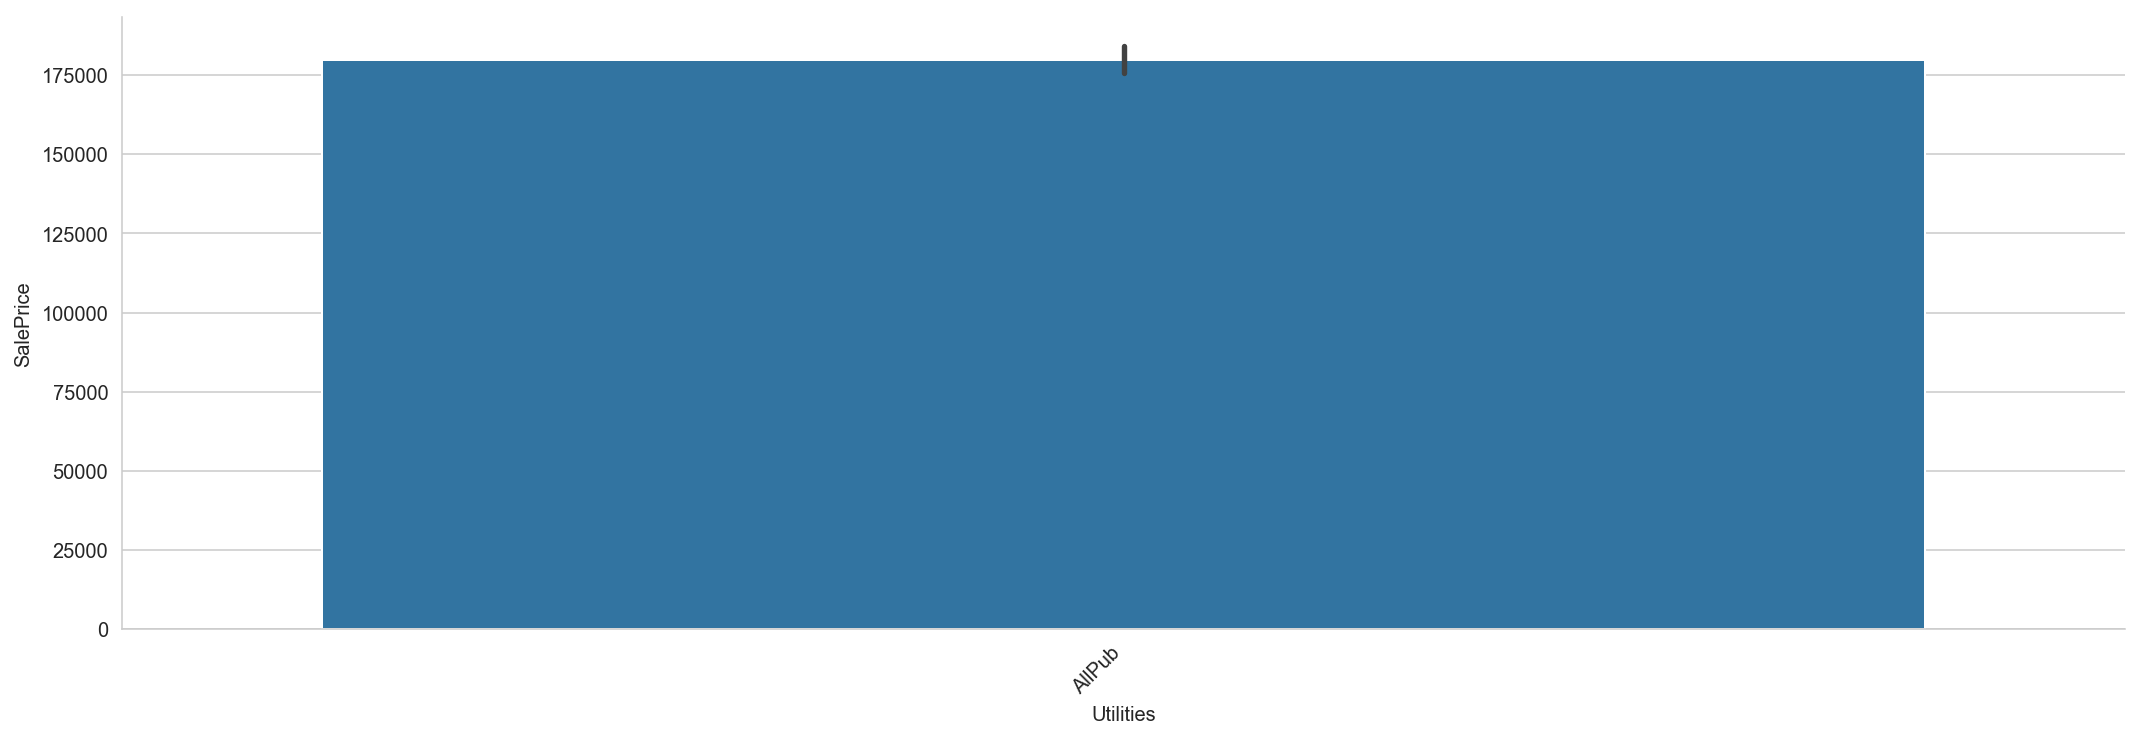

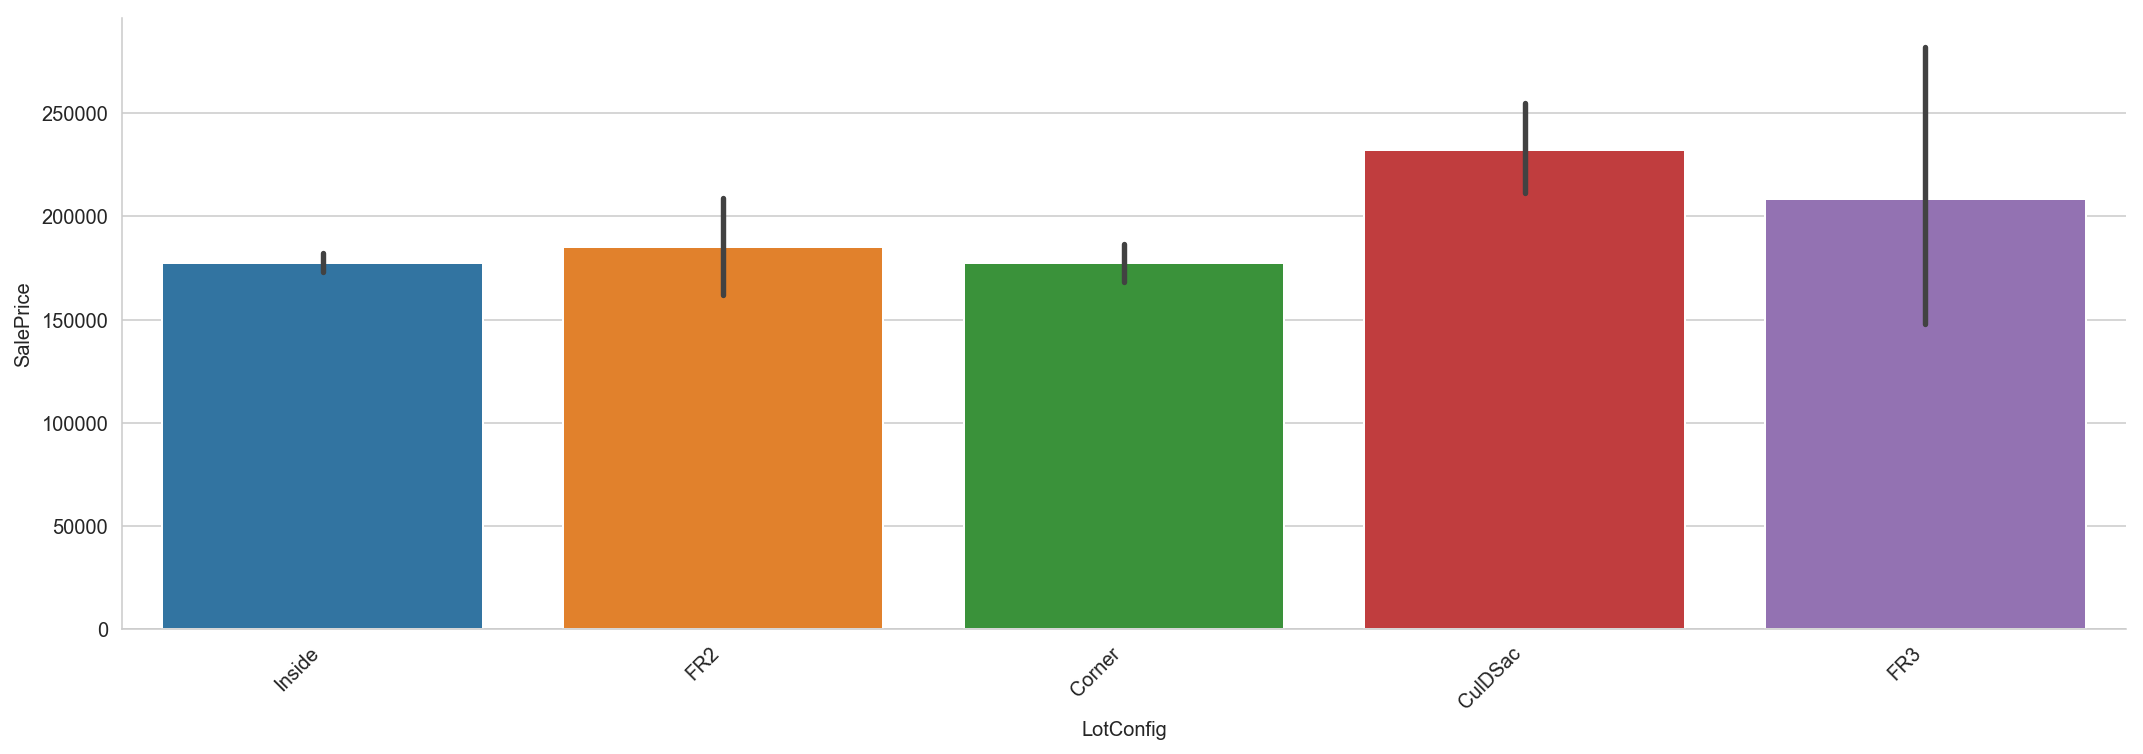

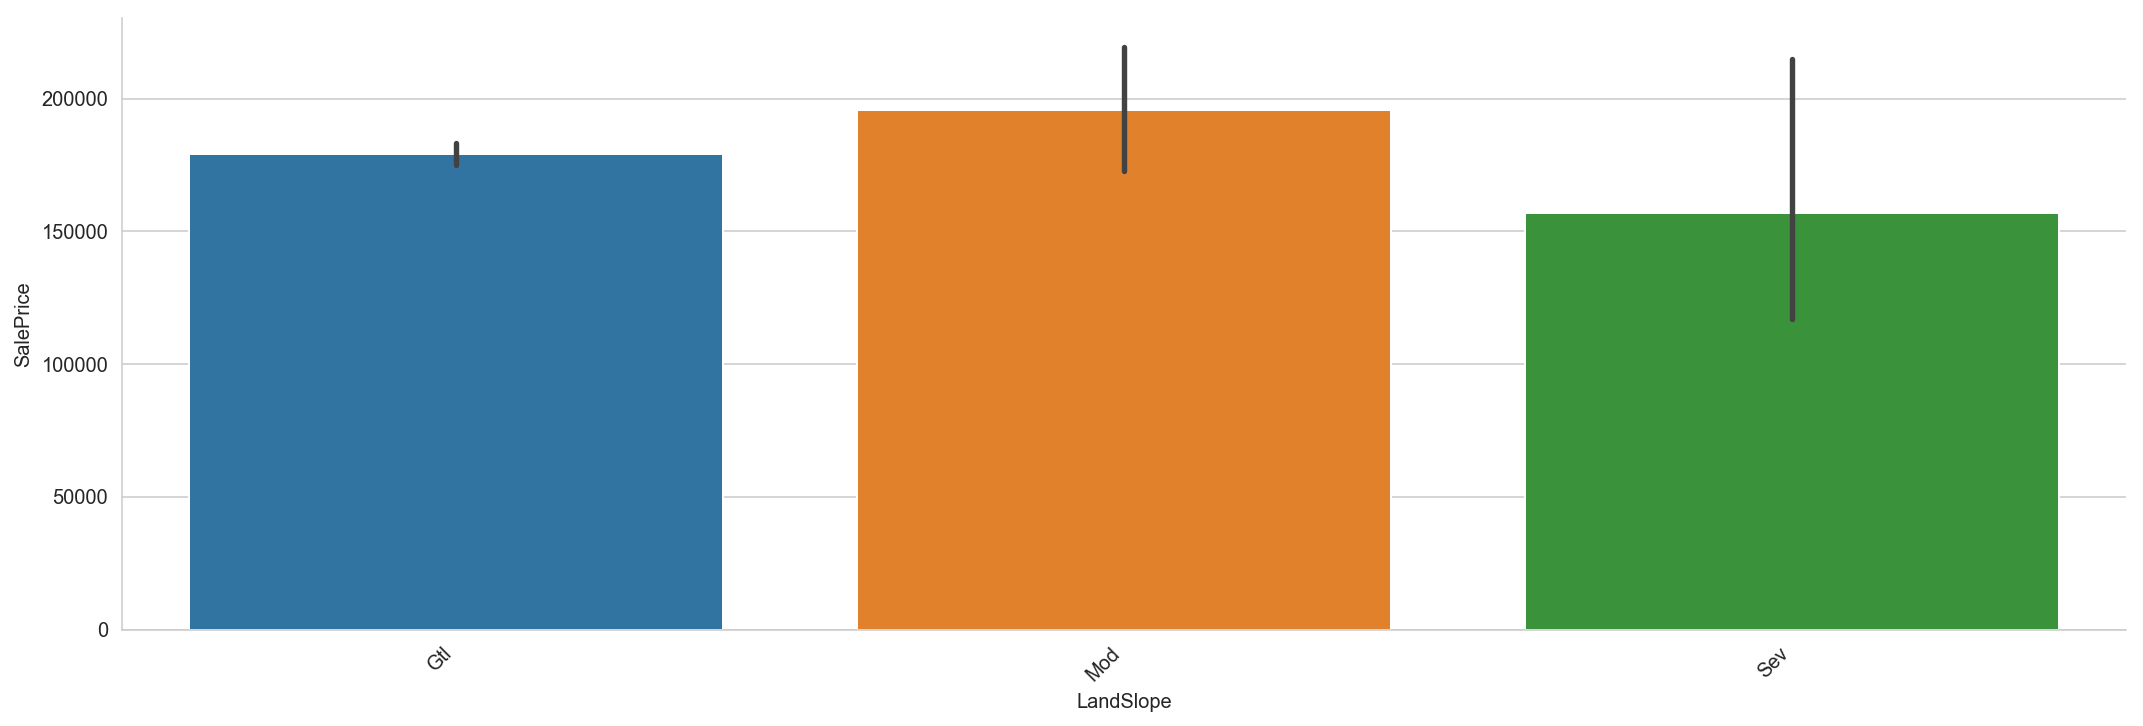

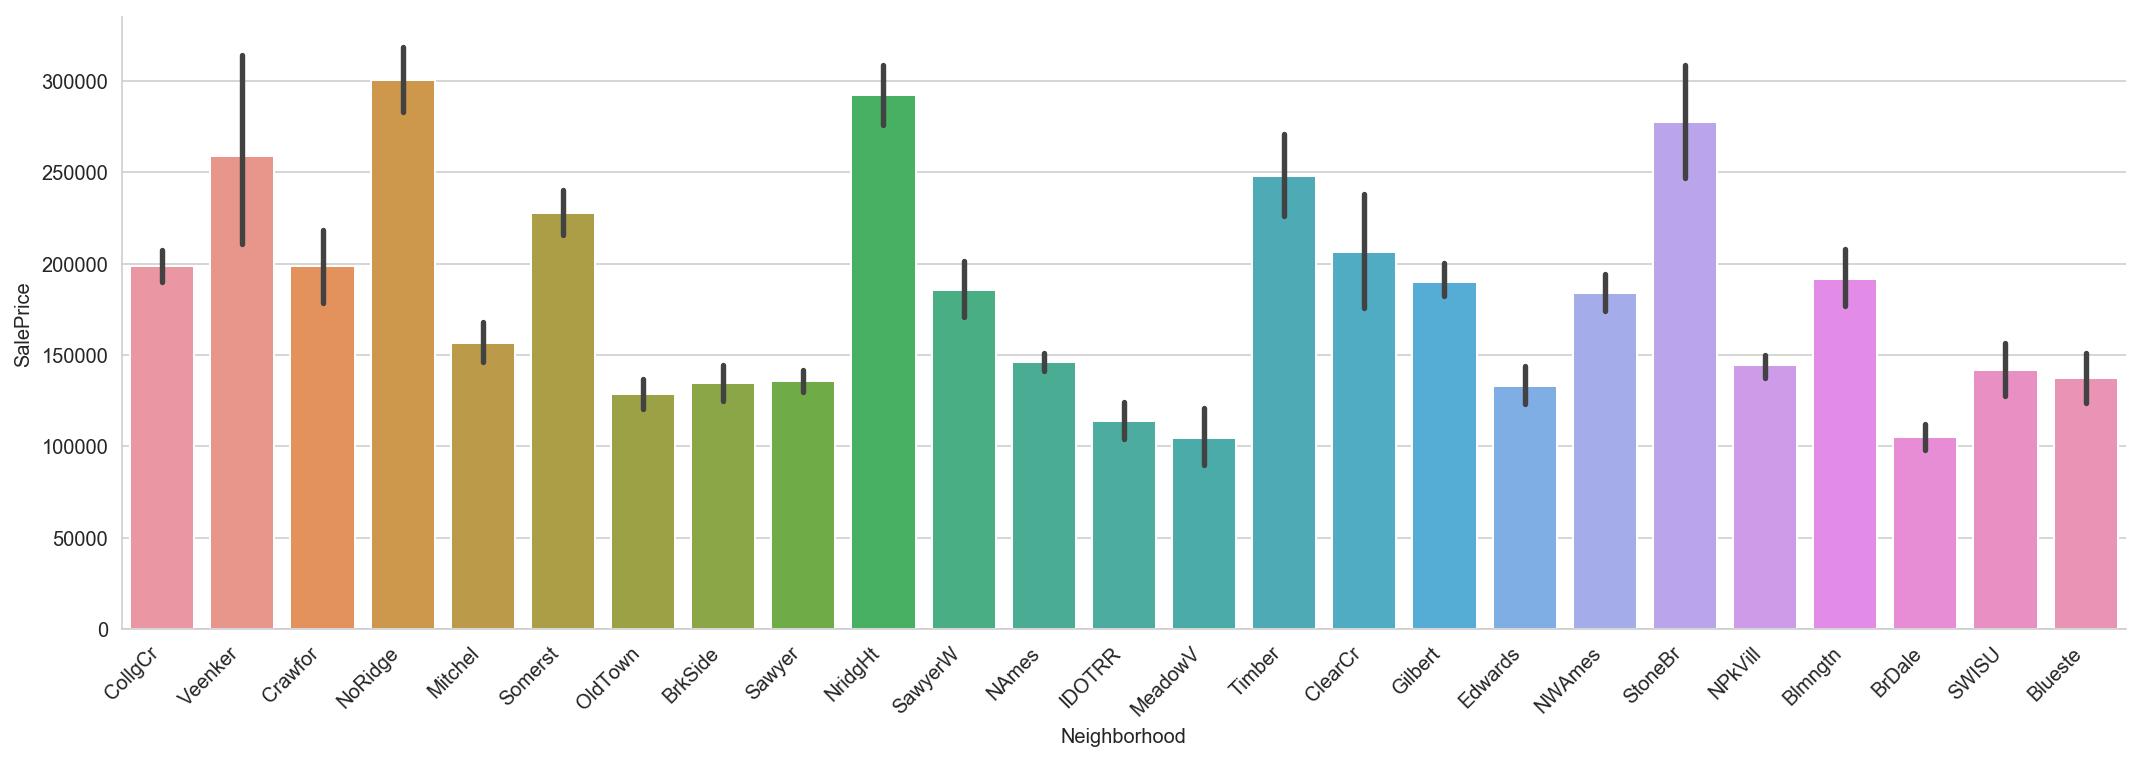

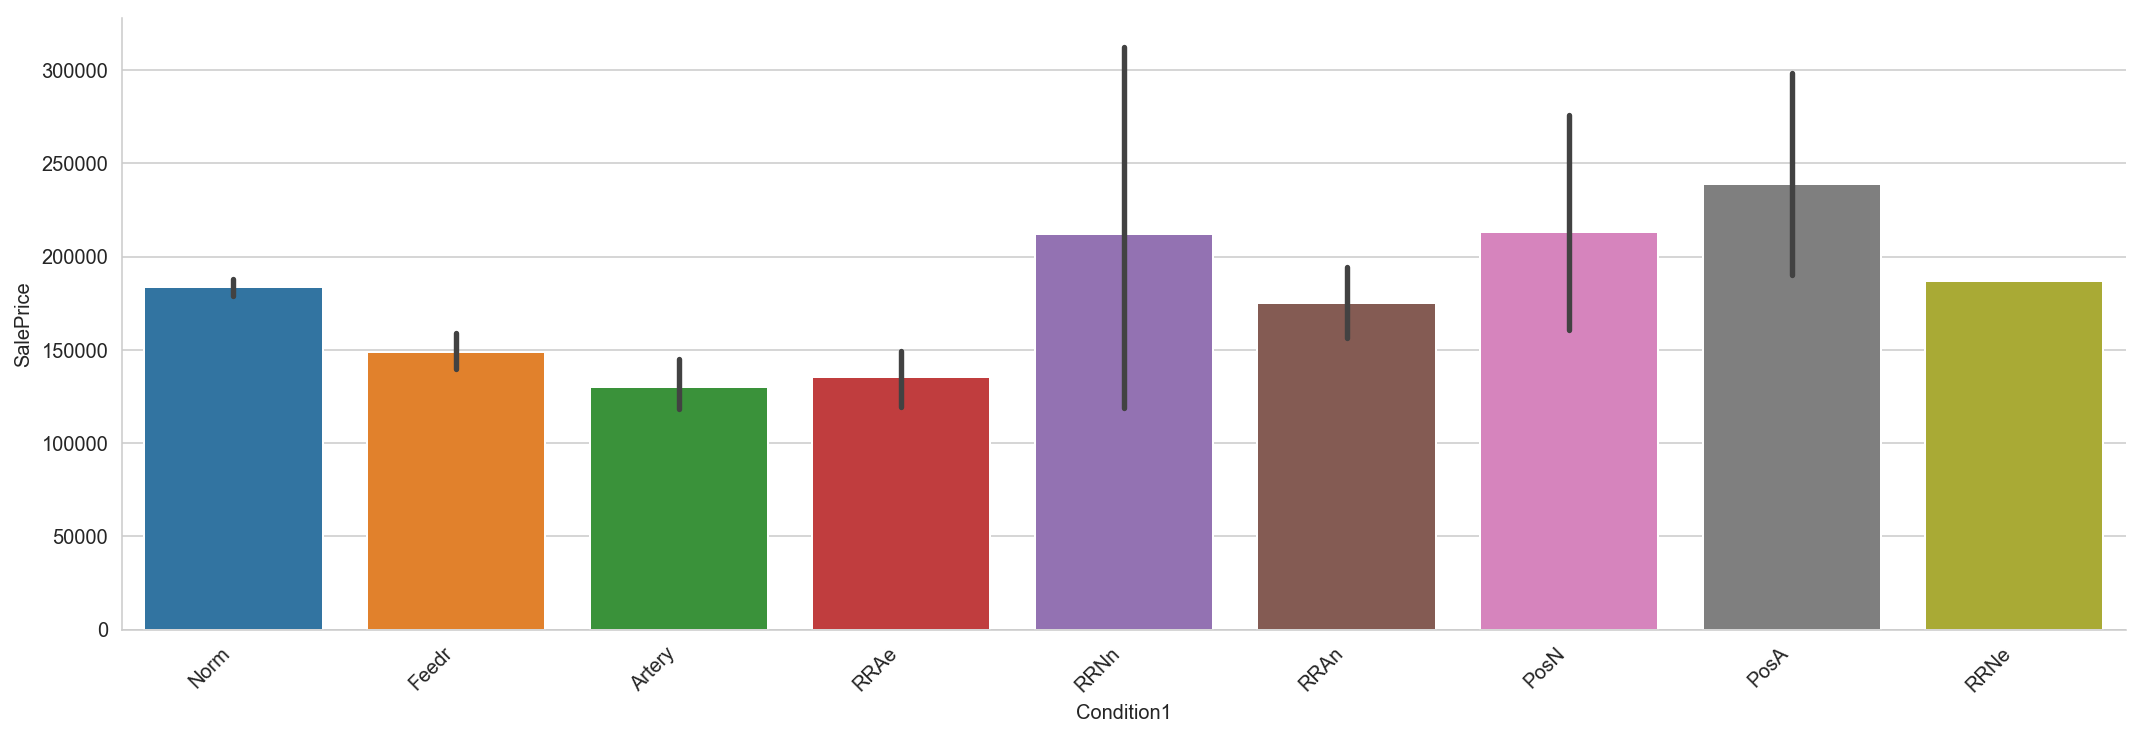

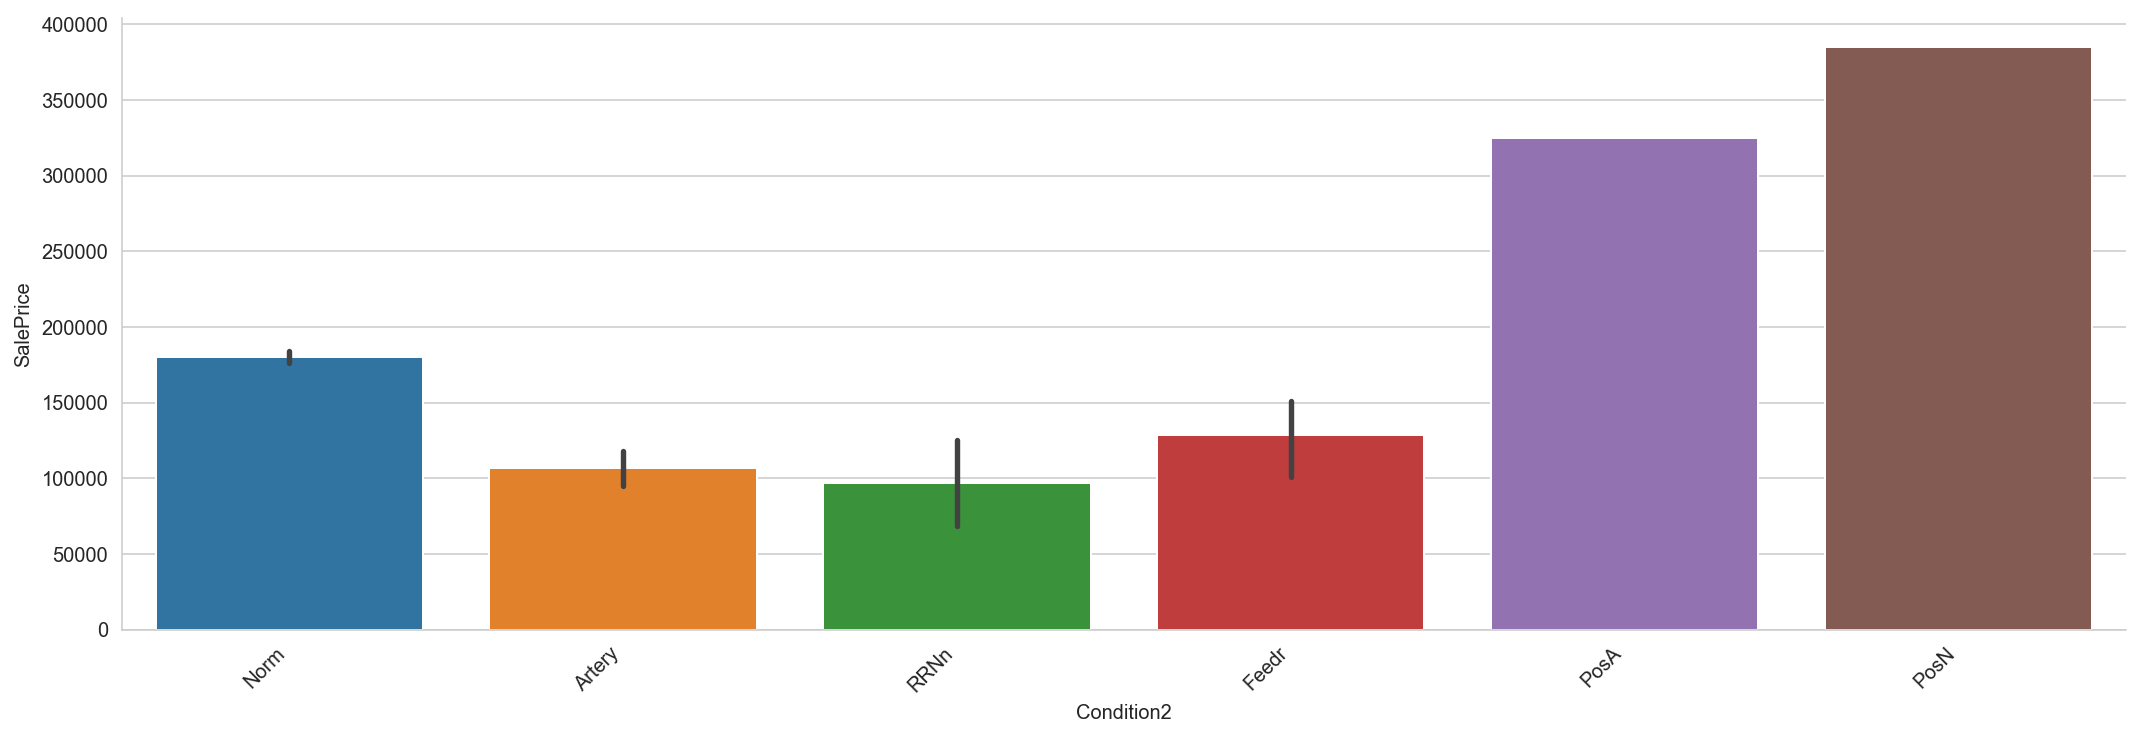

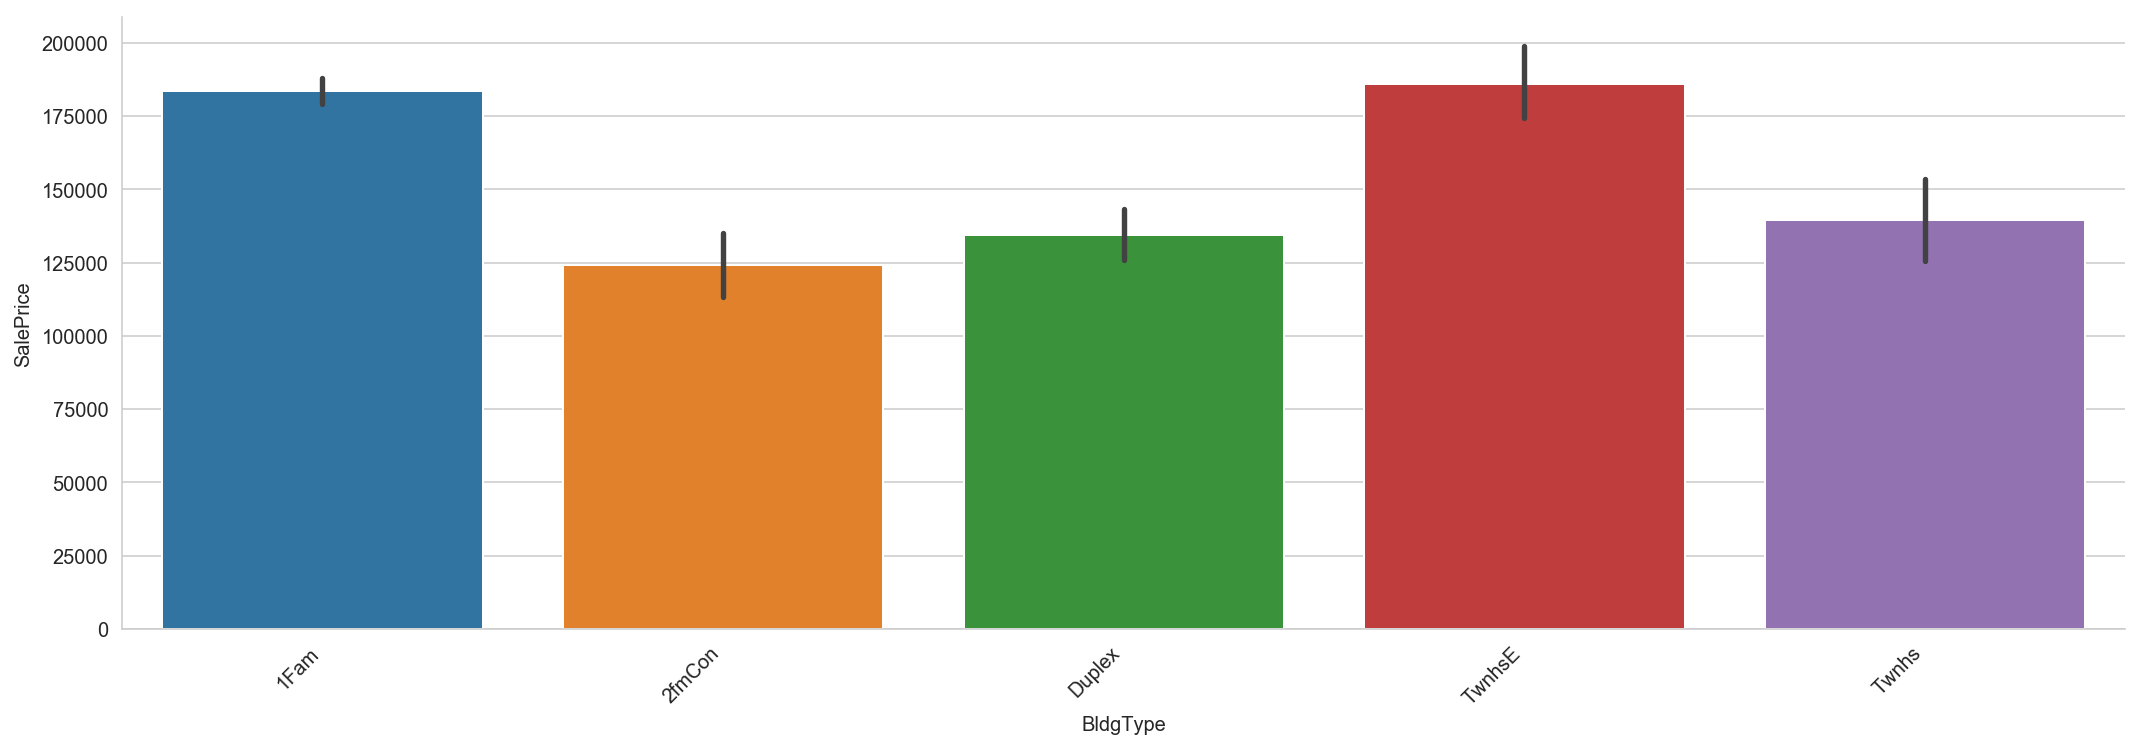

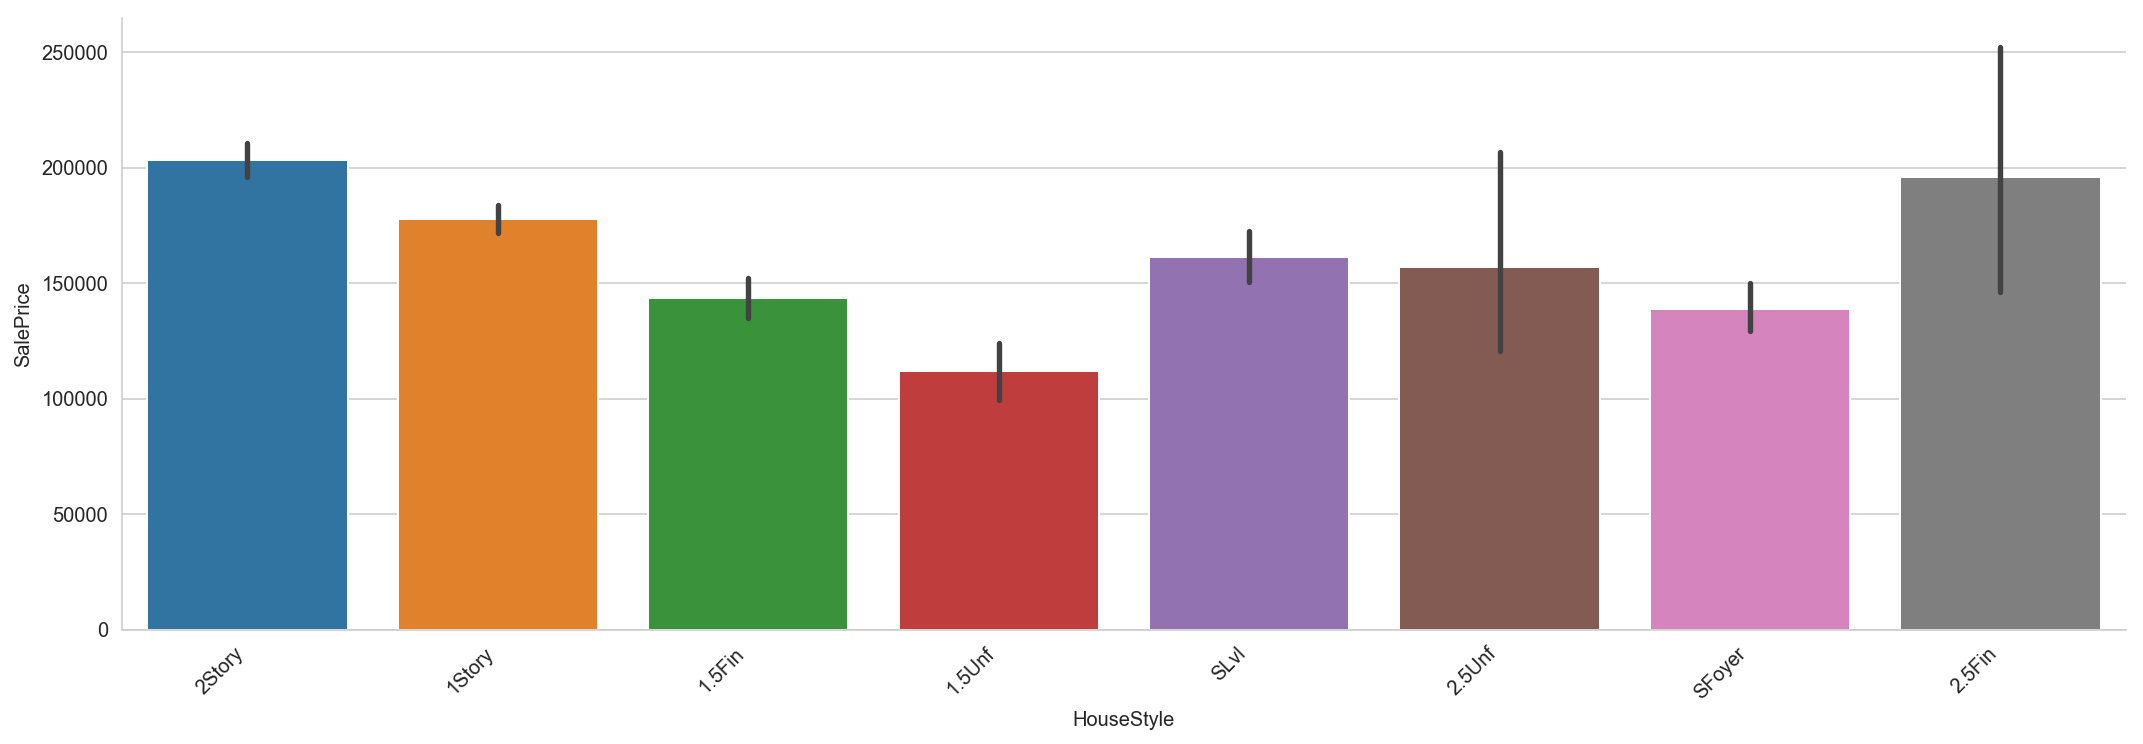

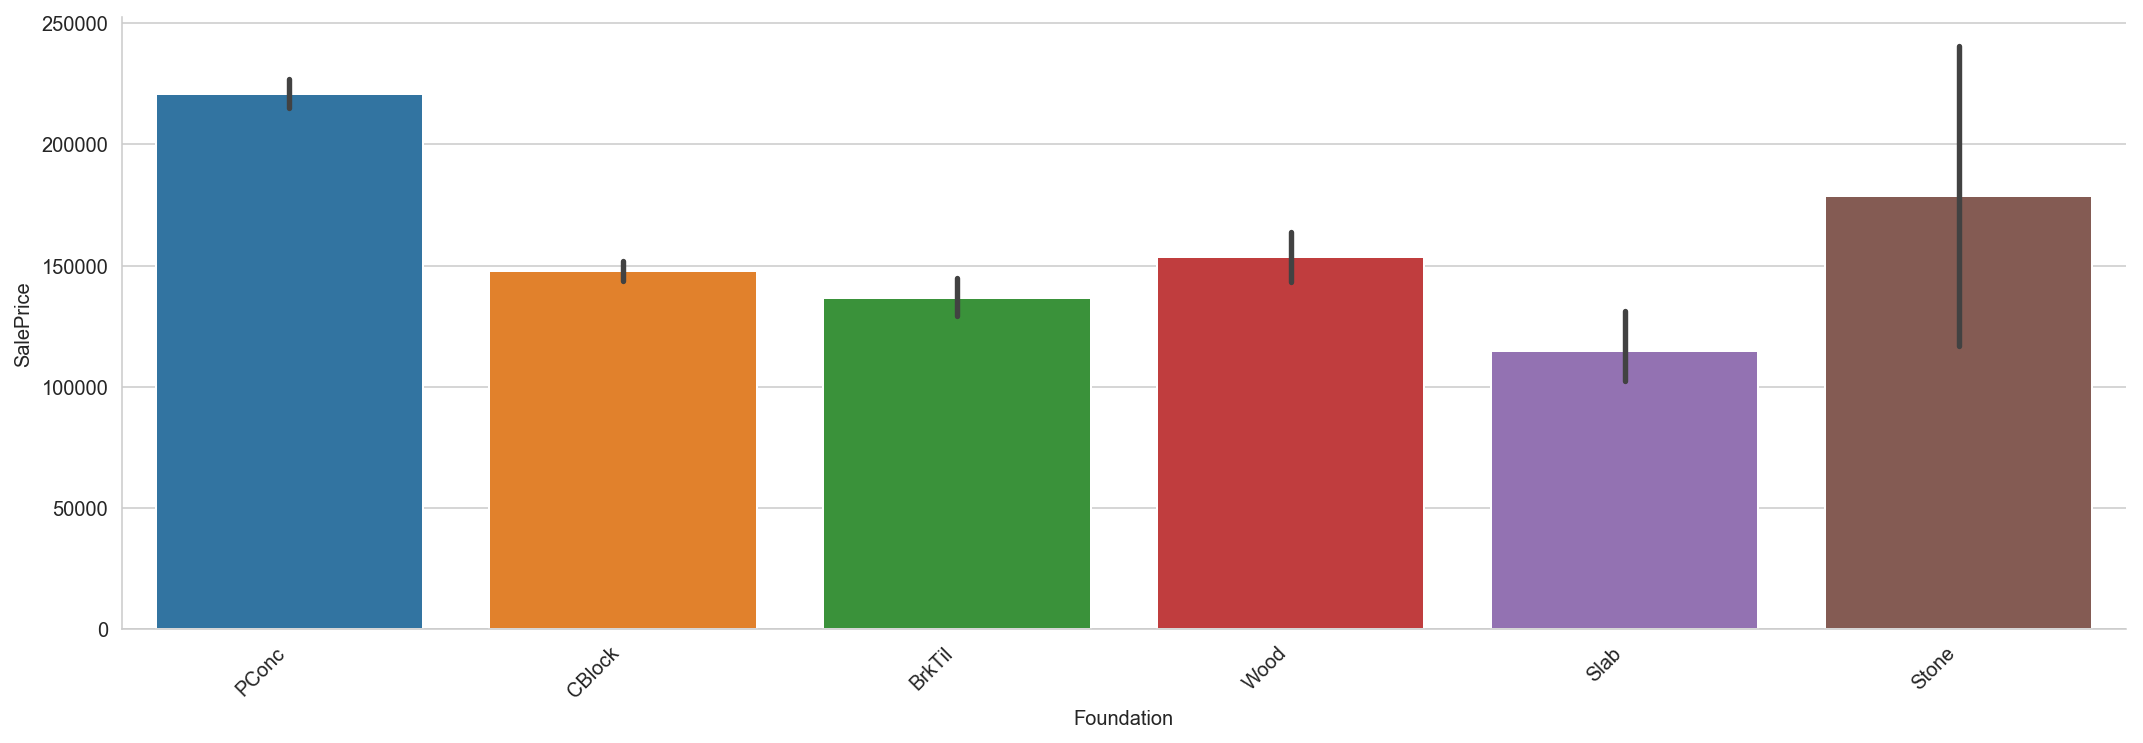

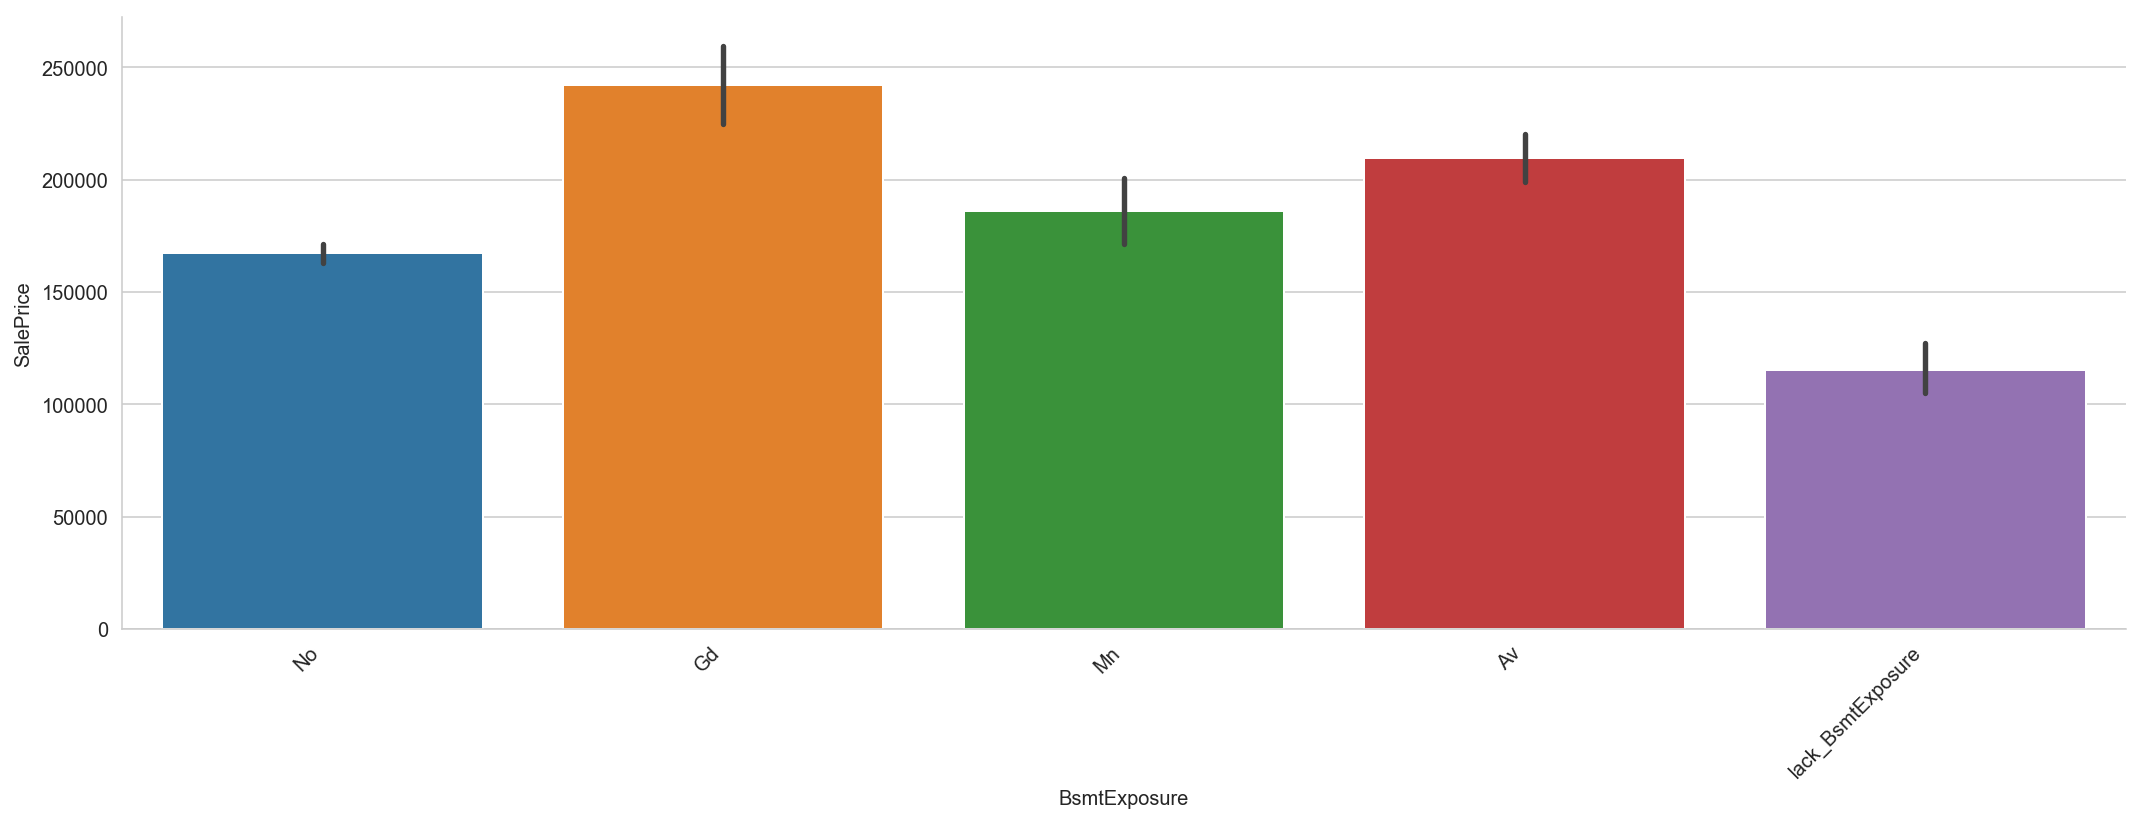

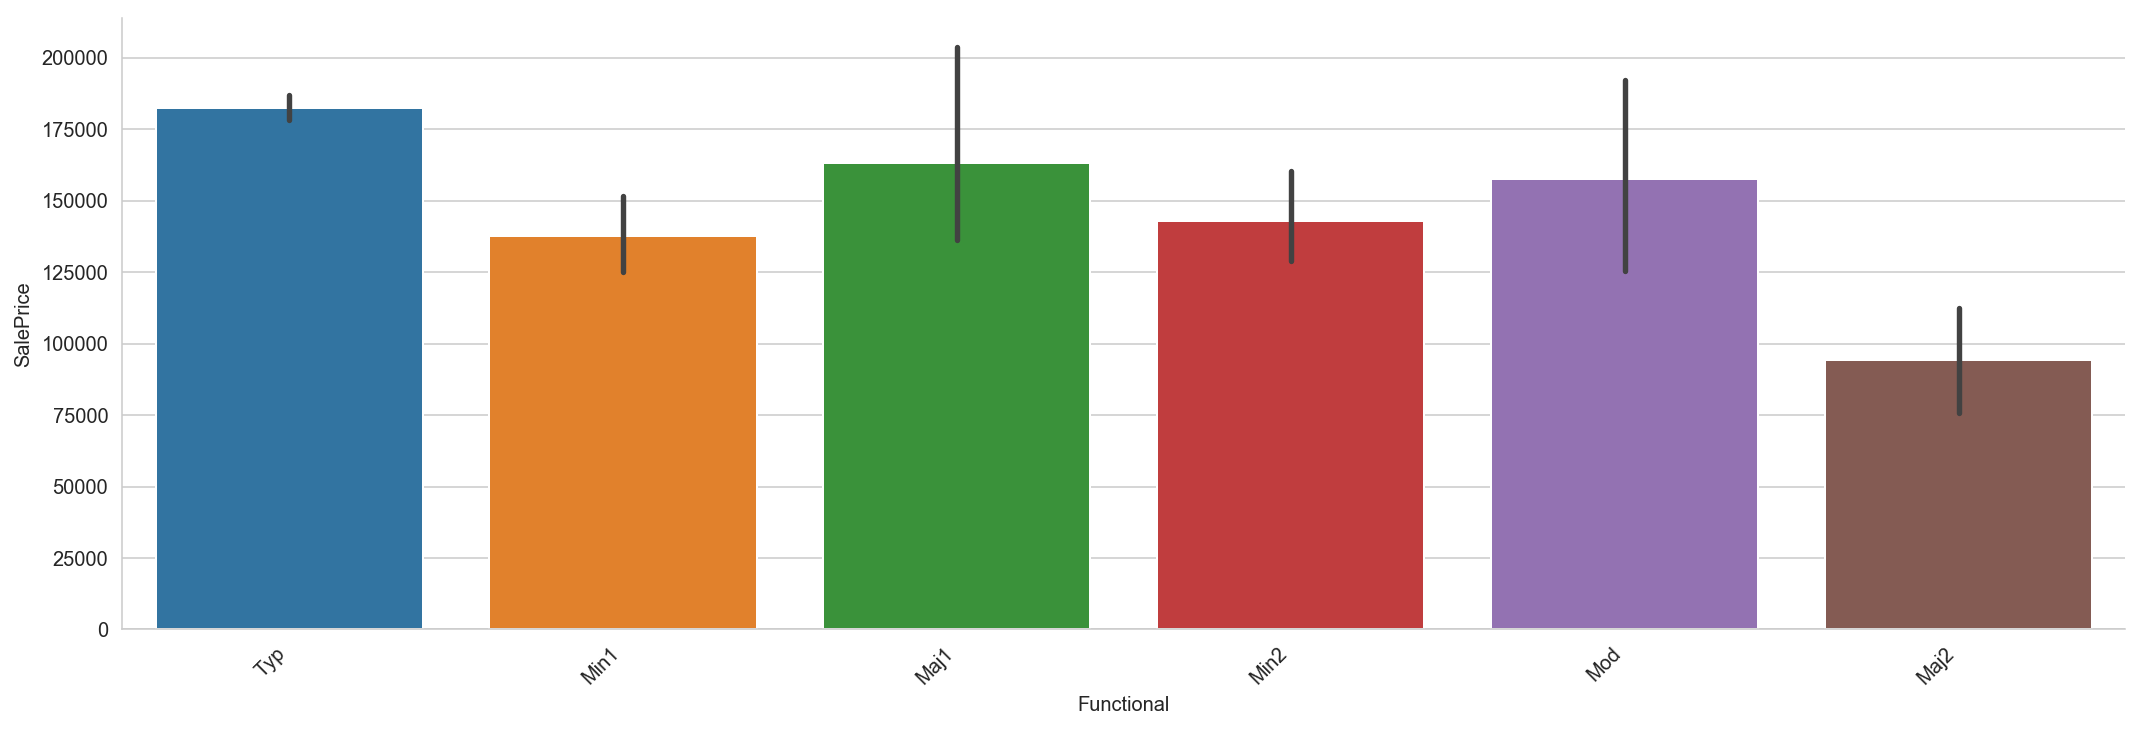

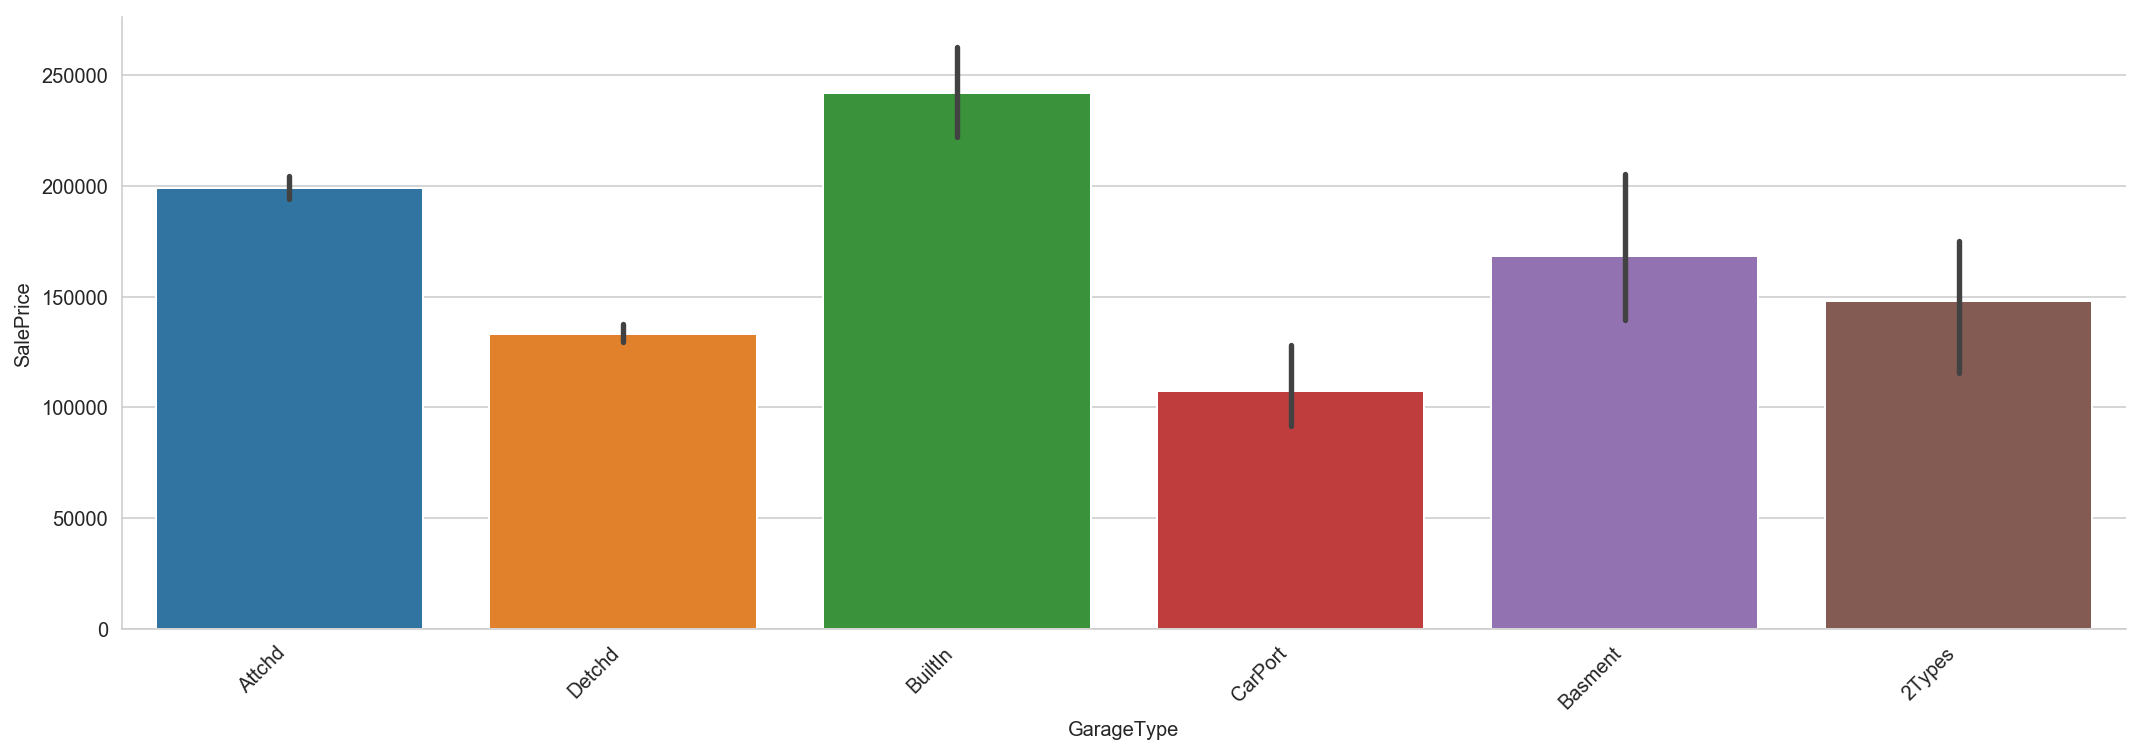

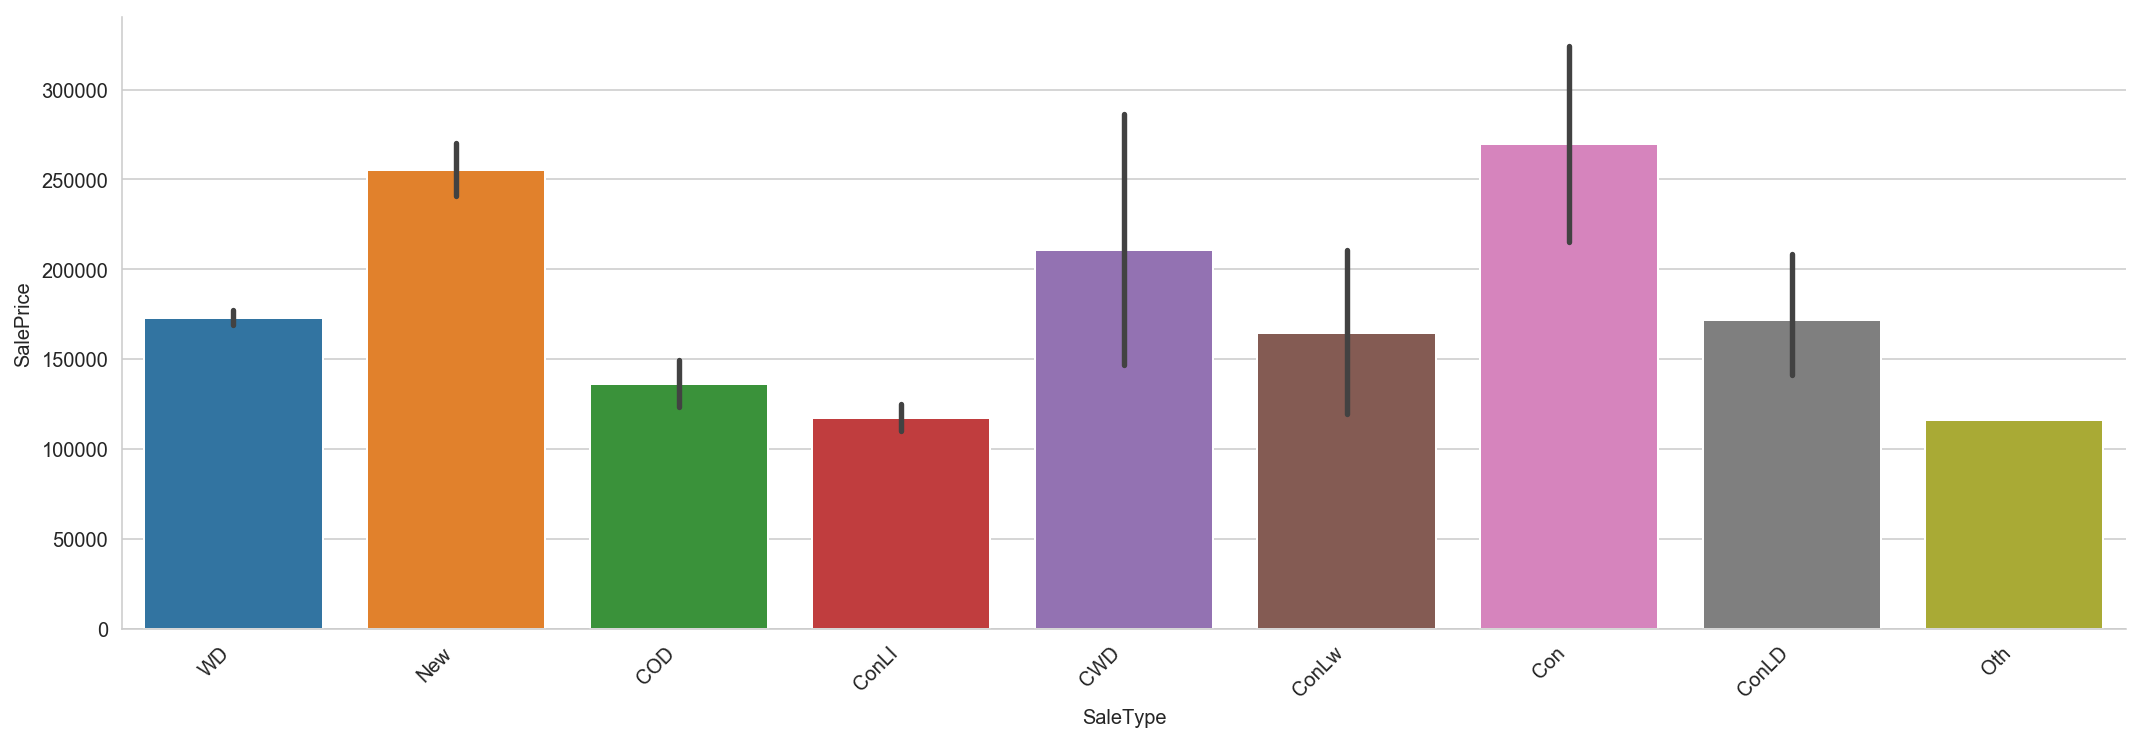

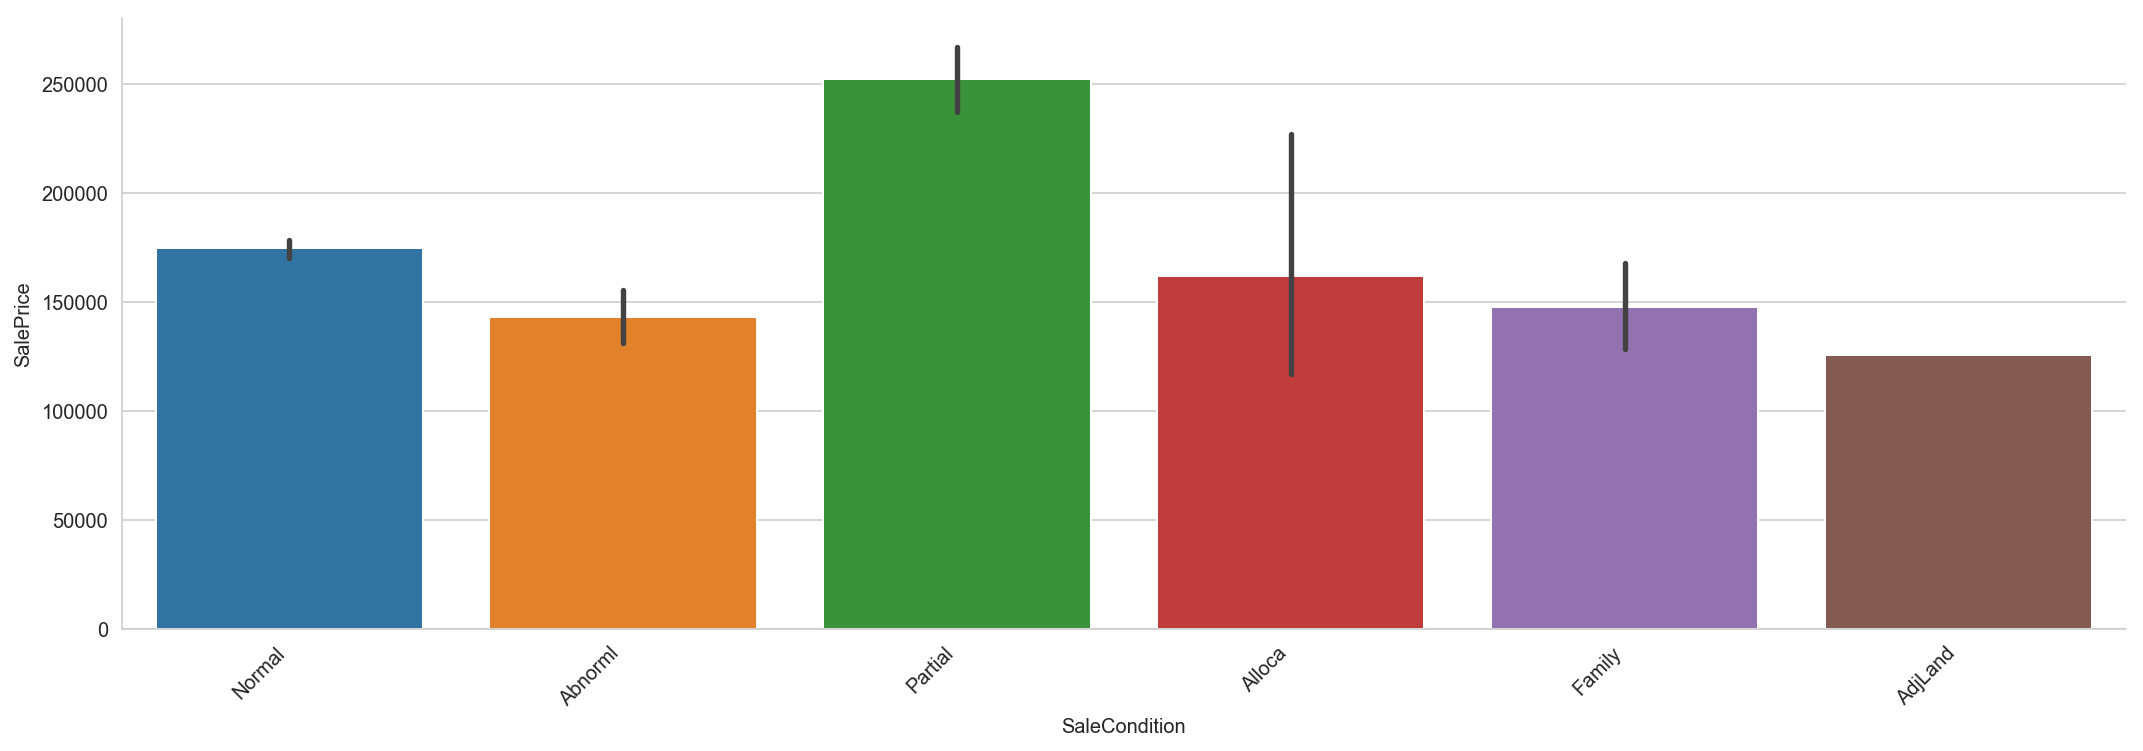

In [52]:
for var in [char for char in cat_char_fixed if not char in cat_but_num]:
    sns.catplot(x = var, y = 'SalePrice', data = house, kind = 'bar',
        aspect = 3).set_xticklabels(rotation = 45, horizontalalignment = 'right')

It seems that these characteristics do not give us much information:
    ['Street', 'LandContour', 'Utilities', 'LotConfig', 'LandSlope', 'SaleCondition']

We group the data by each class of each variable and check mainly two things: number of houses in each class (i.e count) and standard deviation (i.e. std) of SalePrice for each class. This can help us with feature selection later.

In [53]:
for var in [char for char in cat_char_fixed if not char in cat_but_num]:
    if not var in ['Street', 'LandContour', 'Utilities', 'LotConfig', 'LandSlope', 'SaleCondition']:
        print(house.groupby(var)['SalePrice'].describe().sort_values(by = 'count'))

          count           mean           std       min       25%       50%  \
MSZoning                                                                     
RH         10.0  128893.400000  33547.784693   76000.0  107675.0  138500.0   
FV         54.0  218930.814815  55165.134293  144152.0  174500.0  208600.0   
RM        173.0  126944.098266  38710.881102   66500.0  106000.0  124000.0   
RL        850.0  188623.711765  68705.108975   58500.0  138500.0  174950.0   

               75%       max  
MSZoning                      
RH        145000.0  181000.0  
FV        251645.0  370878.0  
RM        140000.0  325000.0  
RL        224975.0  426000.0  
          count           mean           std       min       25%       50%  \
LotShape                                                                     
IR3         5.0  213173.000000  84966.119100   73000.0  192140.0  259000.0   
IR2        21.0  202306.380952  58668.907055  110000.0  174000.0  195000.0   
IR1       290.0  213191.589655  6

             count           mean           std       min       25%       50%  \
Functional                                                                      
Maj2           4.0   94250.000000  22410.934831   67000.0   80500.0   97500.0   
Maj1          10.0  163315.000000  59067.645073  127000.0  130000.0  140750.0   
Mod           11.0  157718.181818  60568.668768   60000.0  115750.0  160000.0   
Min1          24.0  137522.916667  32646.292749   82000.0  117250.0  132225.0   
Min2          26.0  142983.923077  43395.643285   87000.0  124250.0  137500.0   
Typ         1012.0  182450.098814  69126.882974   58500.0  132500.0  167000.0   

                 75%       max  
Functional                      
Maj2        111250.0  115000.0  
Maj1        154100.0  315000.0  
Mod         195000.0  256000.0  
Min1        159725.0  210000.0  
Min2        154625.0  316600.0  
Typ         219500.0  426000.0  
            count           mean           std      min       25%       50%  \
GarageTy

As it is seen, there are not many houses for some classes. Also, the standard deviation of SalePrice is low (in comparison to its mean) for some classes.

In [54]:
# deviding the standard deviation by the mean to better understand the variance of SalePrice in a class
for var in [char for char in cat_char_fixed if not char in cat_but_num]:
    if not var in ['Street', 'LandContour', 'Utilities', 'LotConfig', 'LandSlope', 'SaleCondition']:
        var_table = house.groupby(var)['SalePrice'].describe()
        var_table['std/mean'] = var_table['std']/var_table['mean']
        print(var_table[['count', 'std/mean']].sort_values(by = 'std/mean'), "\n")

          count  std/mean
MSZoning                 
FV         54.0  0.251975
RH         10.0  0.260275
RM        173.0  0.304944
RL        850.0  0.364244 

          count  std/mean
LotShape                 
IR2        21.0  0.290000
IR1       290.0  0.315557
Reg       771.0  0.388137
IR3         5.0  0.398578 

              count  std/mean
Neighborhood                 
NPkVill         7.0  0.060526
BrDale         15.0  0.136608
Blueste         2.0  0.138850
Sawyer         46.0  0.153626
Blmngtn        14.0  0.161361
Gilbert        48.0  0.171111
NoRidge        30.0  0.171891
NWAmes         45.0  0.192773
IDOTRR         20.0  0.201914
Mitchel        32.0  0.217637
NAmes         181.0  0.233126
Somerst        74.0  0.234306
NridgHt        66.0  0.235095
SWISU          19.0  0.235294
StoneBr        14.0  0.235844
CollgCr       123.0  0.249520
Timber         28.0  0.256389
BrkSide        42.0  0.263633
MeadowV        10.0  0.263773
Veenker         7.0  0.287848
ClearCr        12.0  0.2

Now we convert the variables into dummy variables and then decide how to select each one as a features through different techniques.

In [55]:
for var in [char for char in cat_char_fixed if not char in cat_but_num]:
    if not var in ['Street', 'LandContour', 'Utilities', 'LotConfig', 'LandSlope', 'SaleCondition']:
        # converting into dummy variable
        var_dummies = pd.get_dummies(house[var], drop_first = True)

        # adding the dummy variable to the dataframe
        features = features.merge(var_dummies, left_index = True, right_index = True, how = 'outer')

In [56]:
features.head()

SalePrice  YrSold  YearBuilt_binned_(1927, 1980]  \
0     208500    2008                              0   
1     181500    2007                              1   
2     223500    2008                              0   
3     140000    2006                              0   
4     250000    2008                              0   

   YearBuilt_binned_(1980, 2009]  YearRemodAdd_binned_(1985, 2010]  \
0                              1                                 1   
1                              0                                 0   
2                              1                                 1   
3                              0                                 0   
4                              1                                 1   

   GarageYrBlt_binned_(1985, 2010]  MSSubClass_[20, 60, 75, 120]  \
0                                1                             1   
1                                0                             1   
2                                1                             1   
3                                1                             0   
4                                1                             1   

   FullBath_[(0,1), 2, 3]  RH  RL  ...  CarPort  Detchd  CWD  Con  ConLD  \
0                       2   0   1  ...        0       0    0    0      0   
1                       2   0   1  ...        0       0    0    0      0   
2                       2   0   1  ...        0       0    0    0      0   
3                       1   0   1  ...        0       1    0    0      0   
4                       2   0   1  ...        0       0    0    0      0   

   ConLI  ConLw  New  Oth  WD  
0      0      0    0    0   1  
1      0      0    0    0   1  
2      0      0    0    0   1  
3      0      0    0    0   1  
4      0      0    0    0   1  

[5 rows x 89 columns]

Up to this point, we have put all the fixed categorical characteristics in the "features" dataframe and removed some characteristics that we thought might not be good features for our models.
Now we should do some tests and remove more variables from this dataframe.

In [57]:
# selection based on mutual information regression scores
X = features.iloc[:,2:]
y = house.SalePrice

selector = SelectKBest(mutual_info_regression, k = 5)
selector.fit(X,y)

feature_by_mutualinf_catvar = pd.DataFrame(selector.scores_, features.iloc[:,2:].columns, columns = ['score'])
feature_by_mutualinf_catvar.sort_values(by = 'score', ascending = False, inplace = True)
feature_by_mutualinf_catvar.head(10)

score
YearBuilt_binned_(1980, 2009]     0.300616
FullBath_[(0,1), 2, 3]            0.299113
PConc                             0.217903
GarageYrBlt_binned_(1985, 2010]   0.212855
YearRemodAdd_binned_(1985, 2010]  0.206196
YearBuilt_binned_(1927, 1980]     0.184705
Detchd                            0.144019
CBlock                            0.123692
MSSubClass_[20, 60, 75, 120]      0.122449
Attchd                            0.094694

In [58]:
# selection based on F-regression scores
X = features.iloc[:,2:]
y = house.SalePrice

selector = SelectKBest(f_regression, k = 5)
selector.fit(X,y)

feature_by_freg_catvar = pd.DataFrame(selector.scores_, features.iloc[:,2:].columns, columns = ['score'])
feature_by_freg_catvar.sort_values(by = 'score', ascending = False, inplace = True)
feature_by_freg_catvar.head(10)

score
YearBuilt_binned_(1980, 2009]     727.747397
FullBath_[(0,1), 2, 3]            540.548354
GarageYrBlt_binned_(1985, 2010]   507.738639
PConc                             477.954547
YearRemodAdd_binned_(1985, 2010]  438.719077
YearBuilt_binned_(1927, 1980]     324.596894
Detchd                            278.825455
MSSubClass_[20, 60, 75, 120]      239.193861
NridgHt                           229.753017
CBlock                            196.932132

In [59]:
# RFECV
X = features.iloc[:,2:]
y = house.SalePrice

rfecv = RFECV(estimator = LinearRegression(), step = 1, cv = 5)
rfecv.fit(X, y)

RFECV(cv=5,
      estimator=LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None,
                                 normalize=False),
      min_features_to_select=1, n_jobs=None, scoring=None, step=1, verbose=0)

In [60]:
print("Optimal number of features according to RFECV is %d" % rfecv.n_features_)

Optimal number of features according to RFECV is 50


In [61]:
# a list of best features according to RFECV (all of them are ranked 1 so there is no priority here)
feature_by_rfecv_catvar = [val for ind, val in enumerate(features.iloc[:,2:].columns) if rfecv.ranking_[ind] == 1]

In [62]:
# using Lasso to rank the features selected through RFECV
X = features[feature_by_rfecv_catvar]
y = house.SalePrice

lasso = Lasso(alpha = 0.025)
lasso.fit(X, y)

Lasso(alpha=0.025, copy_X=True, fit_intercept=True, max_iter=1000,
      normalize=False, positive=False, precompute=False, random_state=None,
      selection='cyclic', tol=0.0001, warm_start=False)

In [63]:
# a list of ranked features according to Lasso
feature_by_rfecv_ranked_catvar = pd.DataFrame(abs(lasso.coef_), feature_by_rfecv_catvar,
                                columns = ['coefficient']).sort_values(by = 'coefficient', ascending = False)
feature_by_rfecv_ranked_catvar.head(10)

coefficient
PosA_y   159599.184788
PosN_y    86554.560826
NridgHt   84434.434847
StoneBr   83734.175569
NoRidge   79049.308028
Veenker   71284.568733
Twnhs     60179.839944
Blueste   52474.768903
Crawfor   51004.740764
BrDale    44255.662891

In [64]:
# Lasso
X = features.iloc[:,2:]
y = house.SalePrice

lasso = Lasso(alpha = 0.025)
lasso.fit(X, y)


# a list of best features according to Lasso
feature_by_lasso_catvar = pd.DataFrame(abs(lasso.coef_), features.iloc[:,2:].columns,
                                columns = ['coefficient']).sort_values(by = 'coefficient', ascending = False)
feature_by_lasso_catvar.head(10)

coefficient
PosA_y             156883.315166
NridgHt             68606.839543
StoneBr             67918.976225
PosN_y              65874.598448
NoRidge             62366.079571
Twnhs               61445.299887
Veenker             60340.875961
Blueste             46841.842844
Gilbert             46414.504619
lack_BsmtExposure   42486.326880

In [65]:
# making a model based on different number of featres, starting from 1 and stopping at 51 features
for num_feat in range(1, 52):
    predictors = [feature_by_rfecv_ranked_catvar.index[0:num_feat], feature_by_freg_catvar.index[0:num_feat]]

    print("\nUsing", num_feat, "features the scores are:")
    for pred in predictors:
        X_train = features[features.YrSold != 2010][pred]
        X_test = features[features.YrSold == 2010][pred]
        y_train = house[house.YrSold != 2010].SalePrice
        y_test = house[house.YrSold == 2010].SalePrice

        lr = LinearRegression()
        lr.fit(X_train, y_train)
        print(lr.score(X_test, y_test))


Using 1 features the scores are:
-0.00023424785482006882
0.3778432481297589

Using 2 features the scores are:
-0.0001490910879553553
0.4588958818112204

Using 3 features the scores are:
0.08124856173523243
0.458931729635116

Using 4 features the scores are:
0.07712298260119177
0.4659769836999799

Using 5 features the scores are:
0.24497773134702894
0.4979520878953022

Using 6 features the scores are:
0.24536956229105977
0.5123896586747422

Using 7 features the scores are:
0.2636271684803351
0.5393347727127571

Using 8 features the scores are:
0.26362423555635284
0.5438574805806515

Using 9 features the scores are:
0.29175564404419885
0.5416931679256741

Using 10 features the scores are:
0.29276346835561395
0.5412397043165624

Using 11 features the scores are:
0.33728859148850976
0.5410967459472529

Using 12 features the scores are:
0.3367933373085251
0.538475775795058

Using 13 features the scores are:
0.3400775285501163
0.5497141849385382

Using 14 features the scores are:
0.36893516

Each of the above methos, gives us a different list of features. The overlaps can be a good starting point for feature selection.

In [66]:
overlap = []
for var in feature_by_rfecv_ranked_catvar.index:
    if var in feature_by_freg_catvar.index[0:52]:
        if var in feature_by_lasso_catvar.index[0:52]:
            if var in feature_by_mutualinf_catvar.index[0:52]:
                overlap.append(var)

overlap

['NridgHt',
 'NoRidge',
 'Twnhs',
 'BrDale',
 'Gd',
 'Maj2',
 'Somerst',
 'BuiltIn',
 'Min1',
 'Attchd',
 'FullBath_[(0,1), 2, 3]',
 'lack_BsmtExposure',
 'MSSubClass_[20, 60, 75, 120]',
 'YearBuilt_binned_(1980, 2009]',
 'Detchd',
 '1.5Unf',
 'New',
 'YearRemodAdd_binned_(1985, 2010]']

Now it is time to put the numerical and categorical characteristics together and select features using more tests and the results above.

Let's standardize the numerical characteristics here

In [67]:
# # standardizing numerical features
# house_standardized = house.copy()
# house_standardized[num_char] = StandardScaler().fit_transform(house_standardized[num_char])

In [68]:
# standardizing numerical features
house_standardized = house.copy()
house_standardizer = StandardScaler().fit(house_standardized[num_char])
house_standardized[num_char] = house_standardizer.transform(house_standardized[num_char])

In [69]:
# adding the candidate numerical features to the features dataframe
numerical_features = house_standardized[['GrLivArea', 'TotalBsmtSF', 'OpenPorchSF', 'MasVnrArea', 'LotFrontage']]

features = features.merge(numerical_features, left_index = True, right_index = True, how = 'outer')

We make a model only based on the candidates.

In [111]:
# making a model based on the features that were common among all lists of features (the overlap)
predictors = overlap.copy()
predictors.extend(numerical_features.columns)

X_train = features[features.YrSold != 2010][predictors]
X_test = features[features.YrSold == 2010][predictors]
y_train = house[house.YrSold != 2010].SalePrice
y_test = house[house.YrSold == 2010].SalePrice

lr = LinearRegression()
lr.fit(X_train, y_train)
print(lr.score(X_test, y_test))

0.8554828845835561


The model is predicting much better than the baseline. Let's compare the predicted values with the true values in a plot.

[Text(0, 0.5, 'True SalePrice'),
 Text(0.5, 0, 'Predicted SalePrice'),
 Text(0.5, 1.0, 'Ideal Line (Green) vs The Line by the Model')]

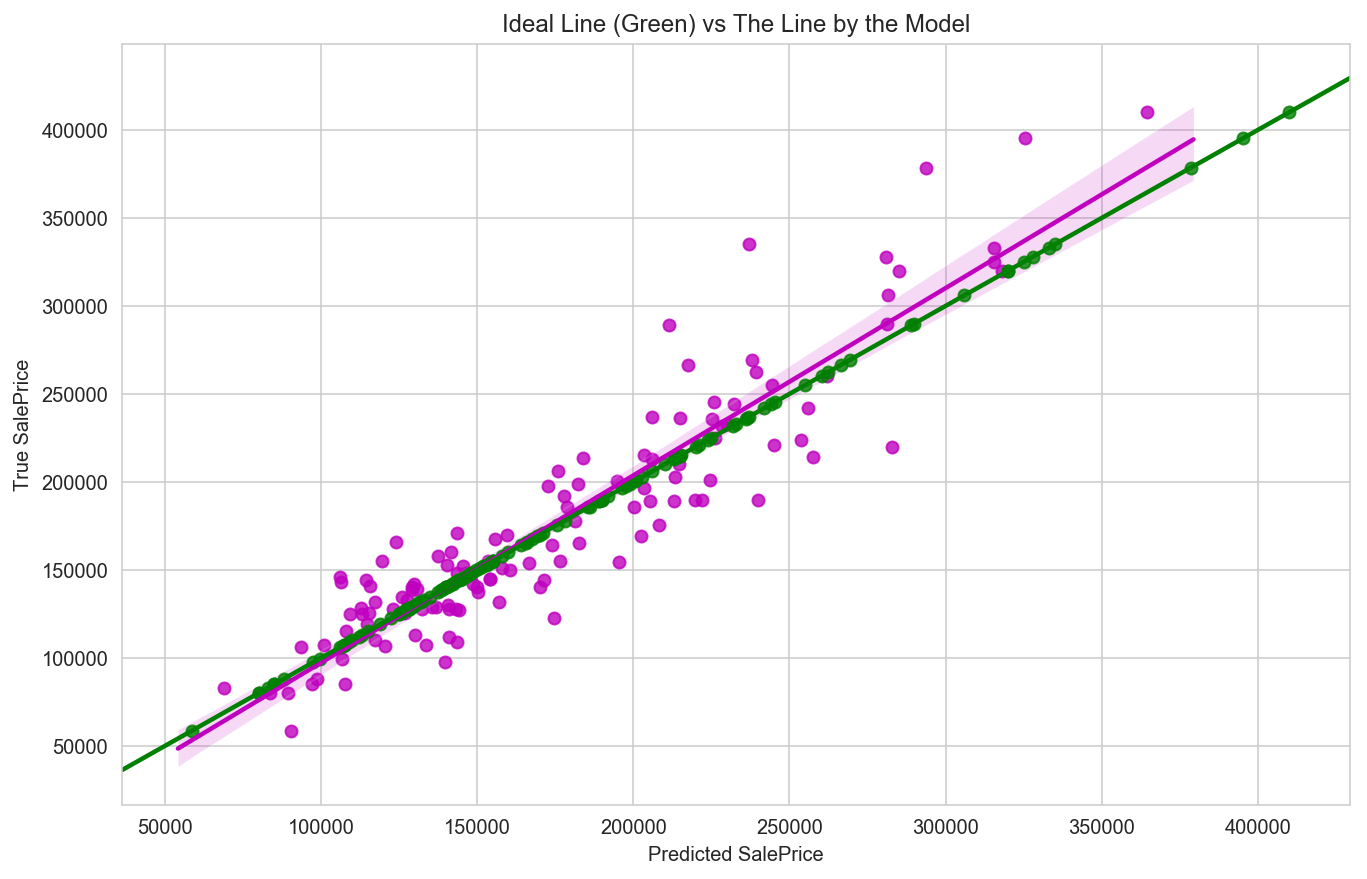

In [112]:
y_hat = lr.predict(X_test)
fig, ax = plt.subplots(figsize = (11,7))
sns.regplot(y_hat, y_test, color = 'm', ax = ax)
sns.regplot(y_test, y_test, color = 'g', ax = ax)
ax.set(xlabel = 'Predicted SalePrice', ylabel = 'True SalePrice', title =  "Ideal Line (Green) vs The Line by the Model")

Let's check the residual for the houses sold in 2010.

In [72]:
pd.DataFrame(pd.array(y_test - y_hat), columns = ['residual']).describe().T

count         mean           std           min           25%  \
residual  126.0  2191.703642  26302.216141 -62966.175487 -12881.568207   

                  50%           75%           max  
residual  1655.702853  14135.238911  98096.940648

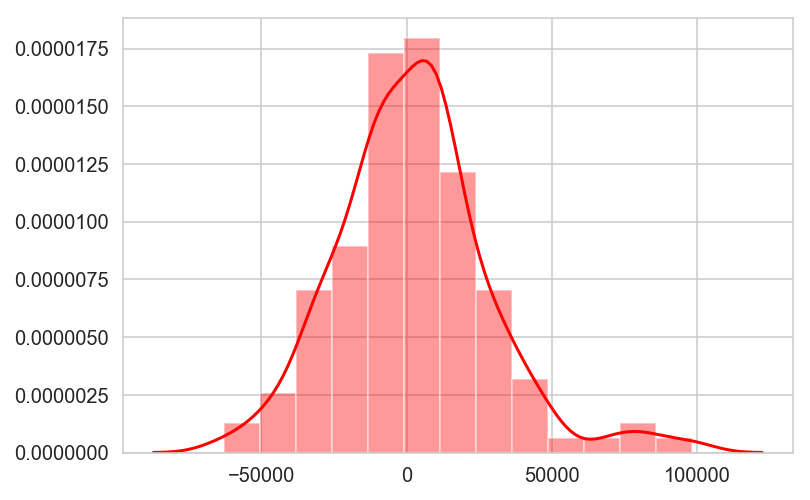

In [120]:
sns.distplot(pd.DataFrame(pd.array(y_test - y_hat), columns = ['residual']), bins = 13, color = 'r')

In [ ]:
Based on this model the most important features are:
    - categorical: Neighborhood, BldgType, BsmtExposure, GarageType, SaleType, Condition1 and Condition2
    - numerical: GrLivArea, TotalBsmtSF, OpenPorchSF, MasVnrArea and LotFrontage

<img src="http://imgur.com/l5NasQj.png" style="float: left; margin: 25px 15px 0px 0px; height: 25px">

## 2. Determine any value of *changeable* property characteristics unexplained by the *fixed* ones.

---

Now that you have a model that estimates the price of a house based on its static characteristics, we can move forward with part 2 and 3 of the plan: what are the costs/benefits of quality, condition, and renovations?

There are two specific requirements for these estimates:
1. The estimates of effects must be in terms of dollars added or subtracted from the house value. 
2. The effects must be on the variance in price remaining from the first model.

The residuals from the first model (training and testing) represent the variance in price unexplained by the fixed characteristics. Of that variance in price remaining, how much of it can be explained by the easy-to-change aspects of the property?

---

**Your goals:**
1. Evaluate the effect in dollars of the renovate-able features. 
- How would your company use this second model and its coefficients to determine whether they should buy a property or not? Explain how the company can use the two models you have built to determine if they can make money. 
- Investigate how much of the variance in price remaining is explained by these features.
- Do you trust your model? Should it be used to evaluate which properties to buy and fix up?

In [74]:
# In this part, the residual (difference between predicted and true values) is the target. We want to predict the residual with the changeable characteristics.

[Text(0, 0.5, 'True SalePrice'), Text(0.5, 0, 'Predicted SalePrice')]

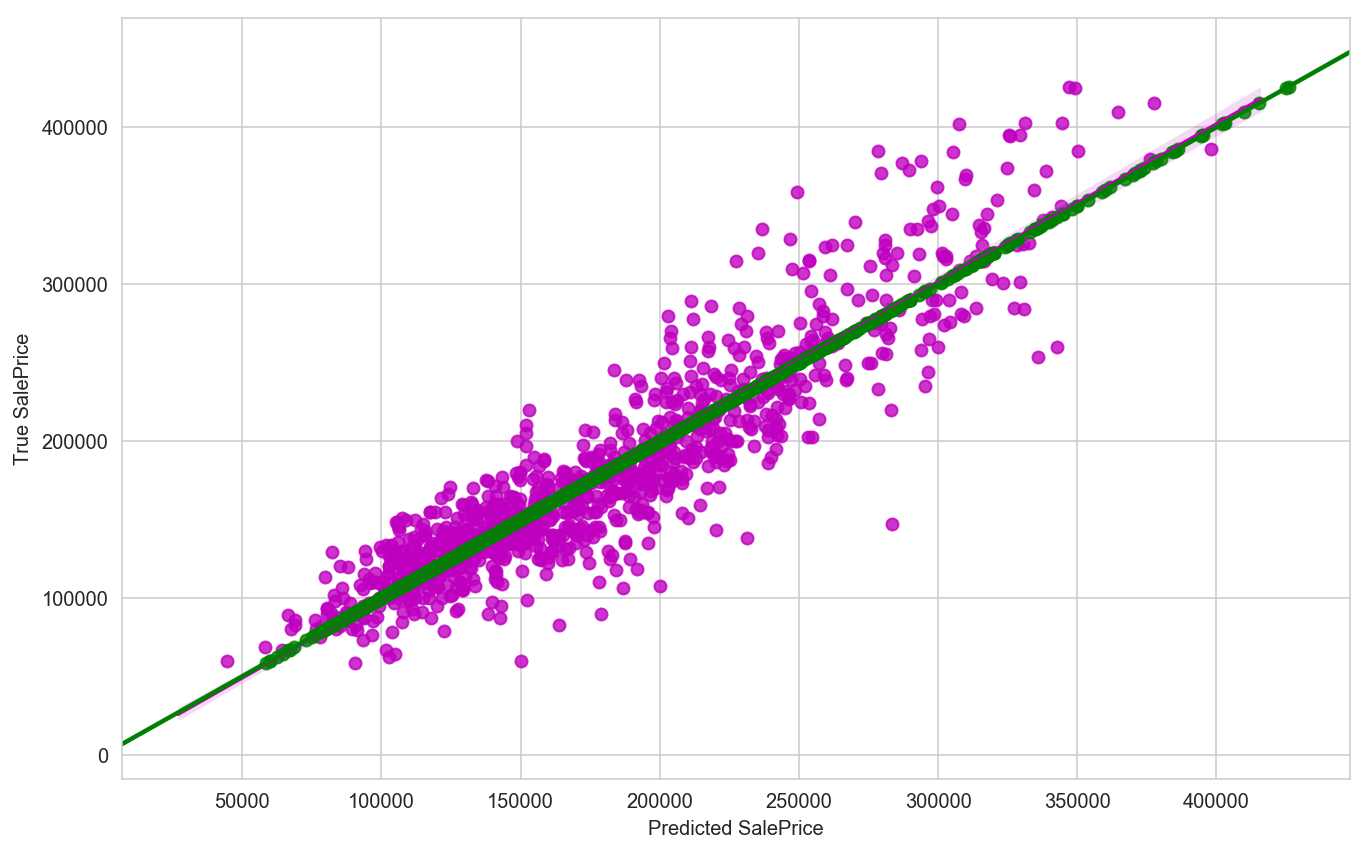

In [75]:
fig, ax = plt.subplots(figsize = (11,7))
sns.regplot(lr.predict(features[predictors]), features.SalePrice, color = 'm', ax = ax)
sns.regplot(features.SalePrice, features.SalePrice, color = 'g', ax = ax)
ax.set(xlabel = 'Predicted SalePrice', ylabel = 'True SalePrice')

In [76]:
pd.DataFrame(pd.array(features.SalePrice - lr.predict(features[predictors])), columns = ['residual']).describe().T

count        mean           std          min           25%  \
residual  1087.0  254.052124  27444.500218 -136479.8736 -16202.534695   

                 50%           75%           max  
residual -392.245489  14672.250937  109859.57529

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x00000161BE4F0390>]],
      dtype=object)

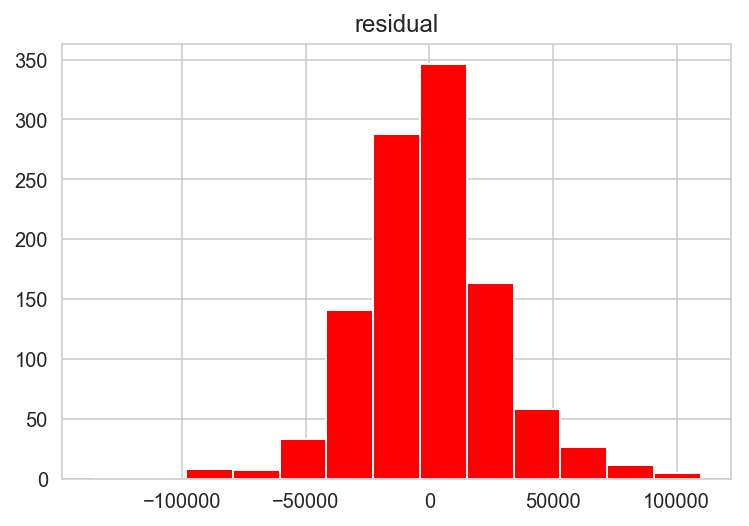

In [77]:
pd.DataFrame(pd.array(features.SalePrice - lr.predict(features[predictors])), columns = ['residual']).hist(bins = 13, color = 'r')

We repeat the same procedure from part 1, but this time with the changeable characteristics.
First, we calculate SalePrice with the model we have from part 1.

We creat a dataframe, called 'features_renov' and add the residual and YrSold to its first two columns.

In [78]:
features_renov = pd.DataFrame()
features_renov['SalePrice'] = features.SalePrice
features_renov['residual'] = pd.array(features.SalePrice - lr.predict(features[predictors]))
features_renov['YrSold'] = house.YrSold
features_renov.drop('SalePrice', axis = 1, inplace = True)

In [79]:
features_renov.head()

residual  YrSold
0   9720.277179641766    2008
1   4213.363782844186    2007
2  18196.625275225728    2008
3 -3812.7696018664865    2006
4 -25979.405631970963    2008

We also add 'residual' column to our 'house' dataframe.

In [80]:
house['residual'] = features_renov.residual

In [81]:
# list of renovatable characteristics
renov_char = [k for k, v in fixability.items() if v == 'renovatable']

num_char_renov = [char for char in renov_char if char in num_char]
cat_char_renov = [char for char in renov_char if char in cat_char]

At this stage we start looking for important characteristics. We start with the numerical variables first.

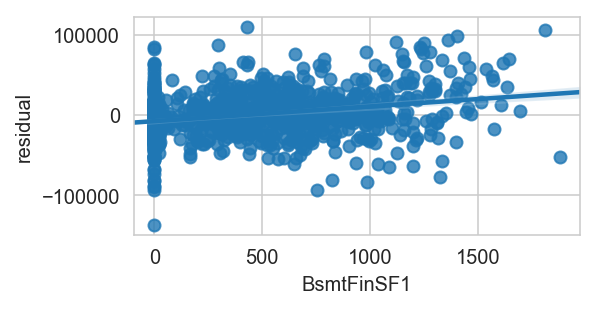

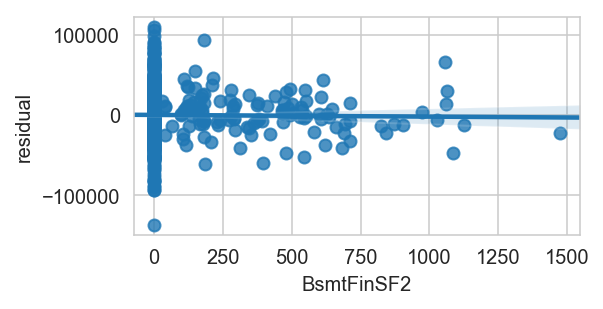

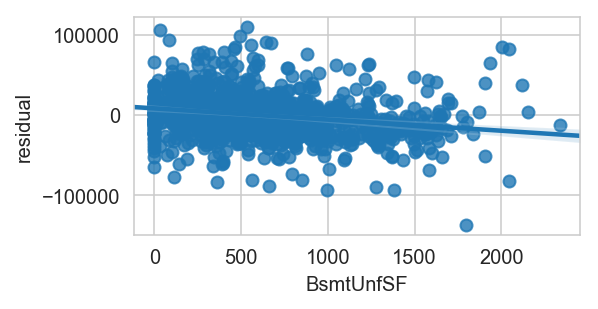

In [82]:
# checking the relation between the residual and each of the fixed numerical characteristics
for i in num_char_renov:
    fig, ax = plt.subplots(figsize = (4,2))
    sns.regplot(x = house[i], y = house.residual, ax = ax)

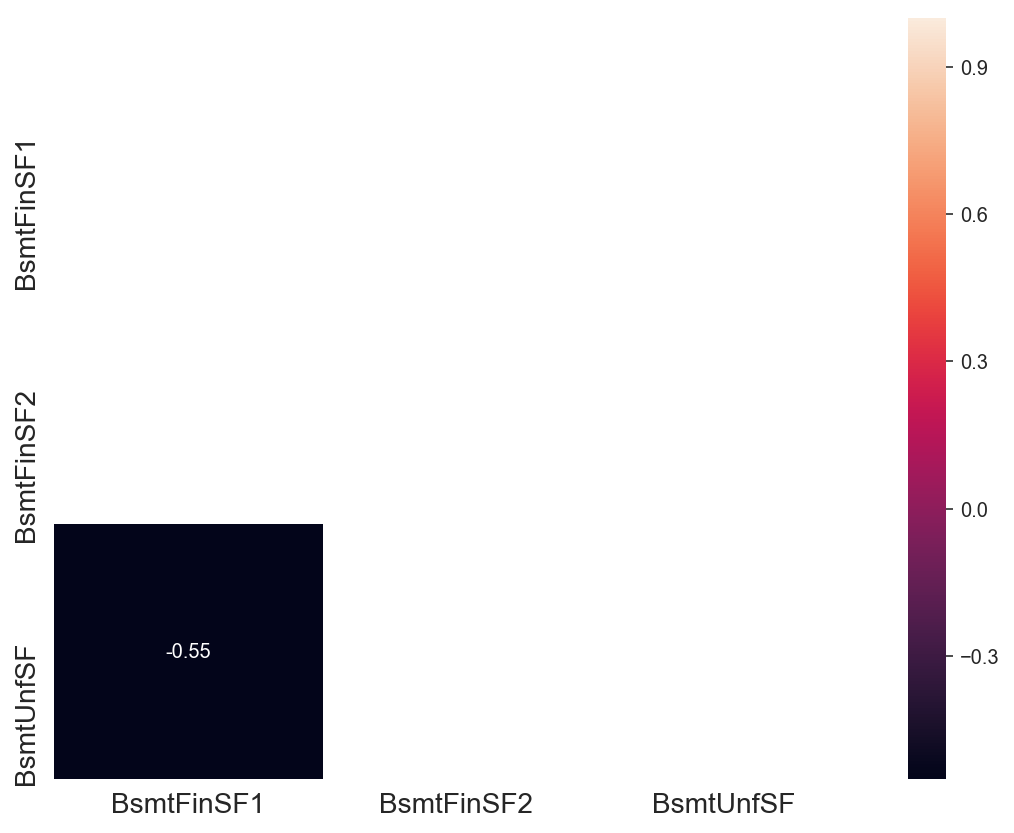

In [83]:
# correlation matrix for the numerical characteristics based on Pearson method (only highly correlated ones are shown)
corrPear = house[num_char_renov].corr()

fig, ax = plt.subplots(figsize = (9,7))

mask = np.zeros_like(corrPear, dtype = np.bool)
mask[np.triu_indices_from(mask)] = True

ax = sns.heatmap(corrPear[np.abs(corrPear) > 0.4], mask = mask, ax = ax, annot = True)

ax.set_xticklabels(ax.xaxis.get_ticklabels(), fontsize = 14)
ax.set_yticklabels(ax.yaxis.get_ticklabels(), fontsize = 14)

plt.show()

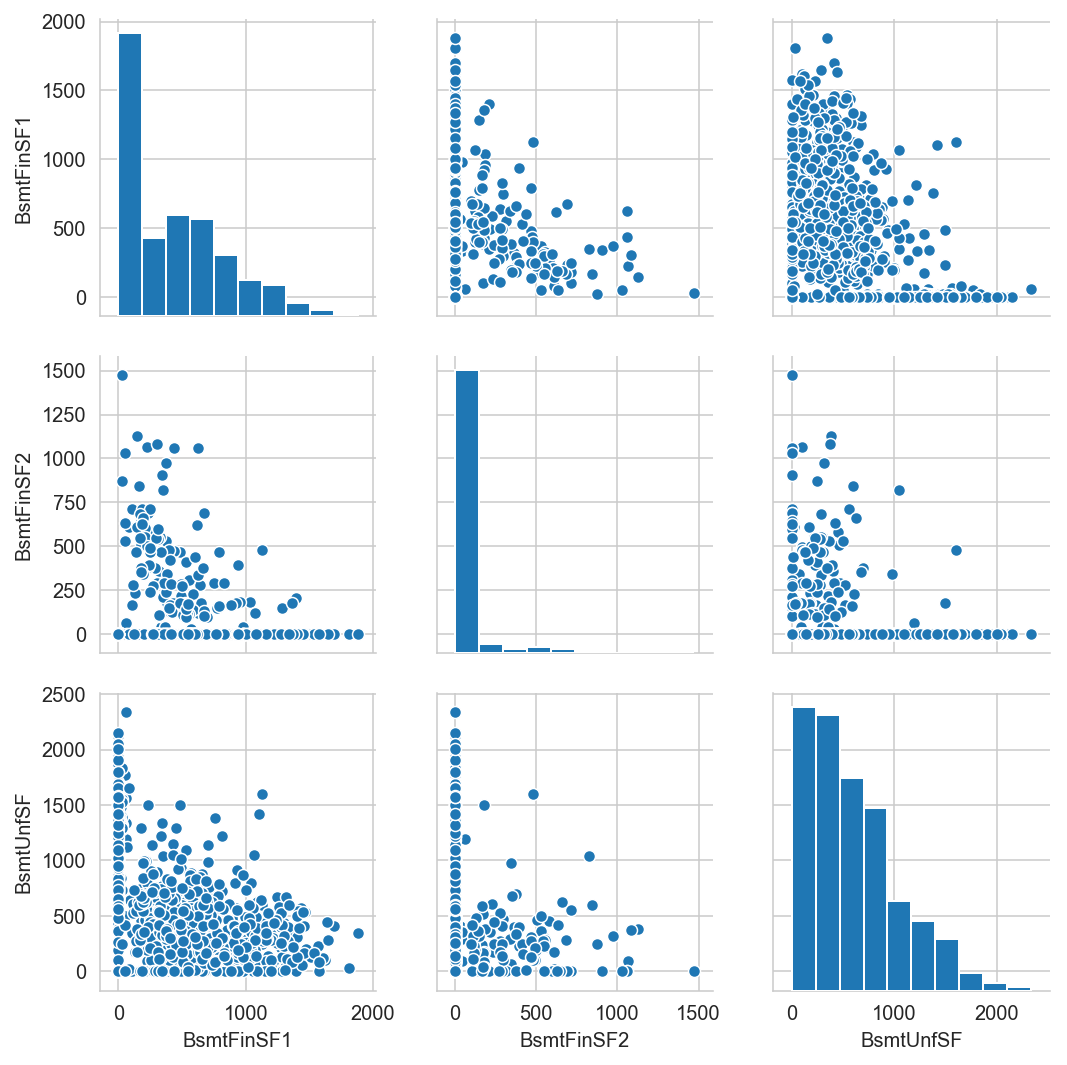

In [84]:
# checking the relation of fixed numerical characteristics with each other
sns.pairplot(house[num_char_renov])

In [85]:
# selection based on mutual information regression scores
X = house[num_char_renov]
y = house.residual

# standardizing data
Xs = StandardScaler().fit_transform(X)

selector = SelectKBest(mutual_info_regression, k = 1)
selector.fit(Xs,y)

feature_by_mutualinf_numvar_renov = pd.DataFrame(selector.scores_, num_char_renov, columns = ['score'])
feature_by_mutualinf_numvar_renov.sort_values(by = 'score', ascending = False, inplace = True)
feature_by_mutualinf_numvar_renov

score
BsmtUnfSF   0.076250
BsmtFinSF1  0.055682
BsmtFinSF2  0.000000

Using the above scores and taking the correlation matrix and the plots into account, we do not select any of the three characteristics as features.

Now we look at the categorical variables. We will check:
    - how many datapoints we have for each unique values of each categorical variable.
    - the percentage of the data corresponding to each category to find out if each category has an effect on the result.
    - define useful categories for each categorical variable before encoding them.

In [86]:
# a dictionary with the categorical characteristic as the key and the classes of the characteristic as a list of values
cat_char_dict = {}
for var in cat_char:
    cat_char_dict[var] = list(house[var].unique())

Let's start with the variables that are represented by numbers but we want them to be categorical. These variables are OverallQual and OverallCond. We have already checked these variables in part 1 so we do not need to make any changes.

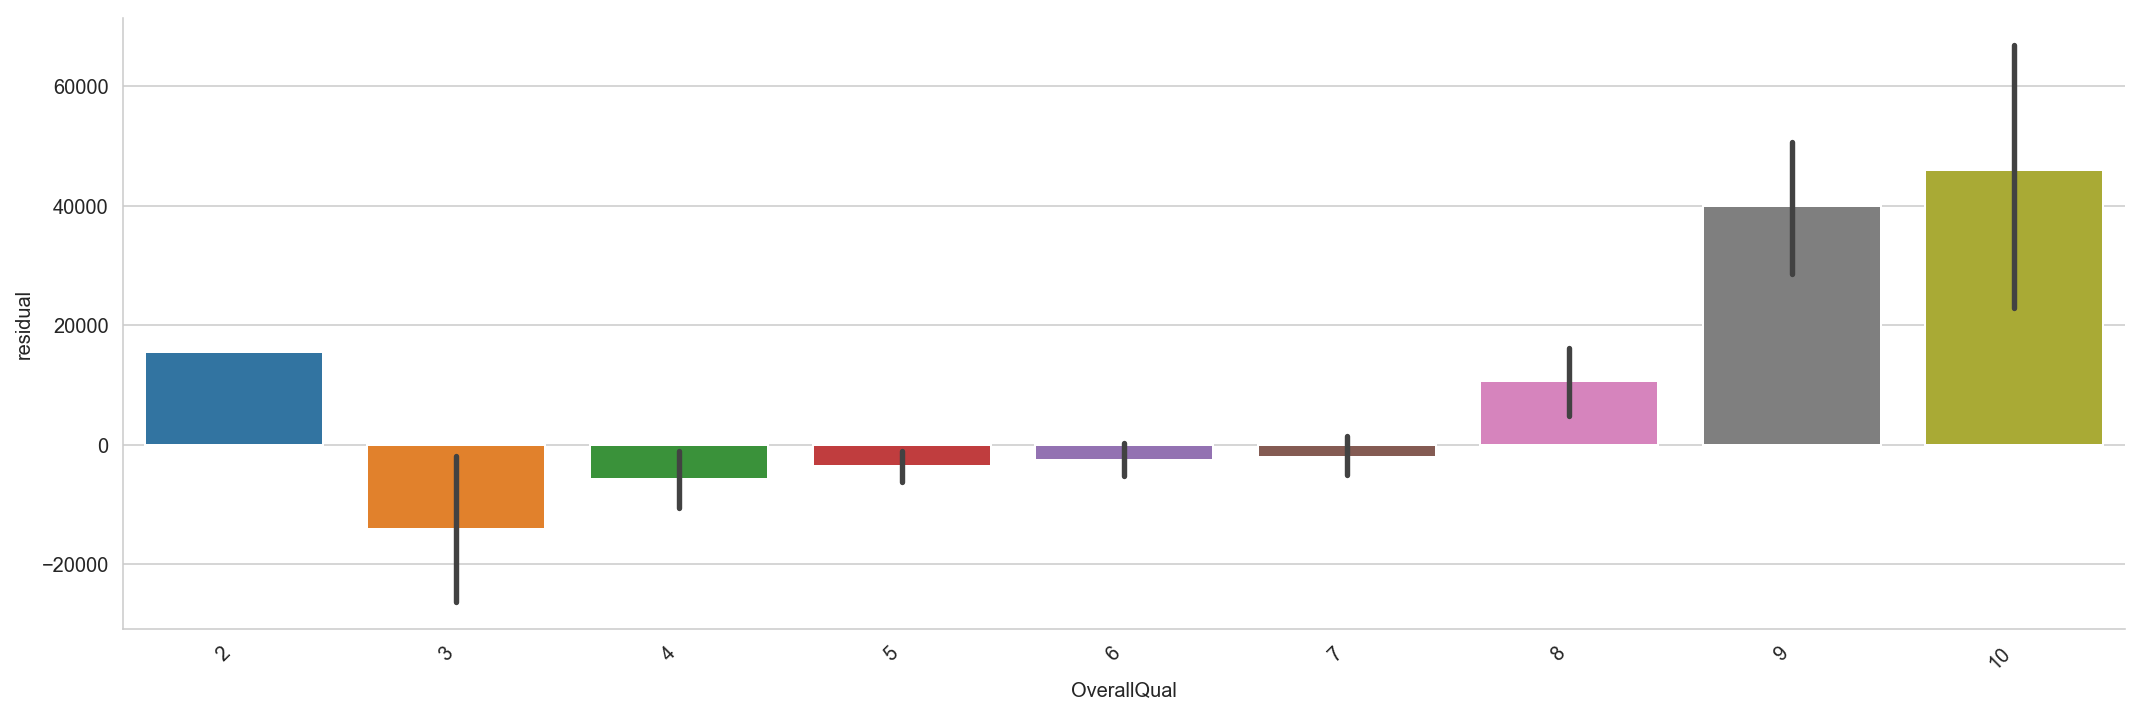

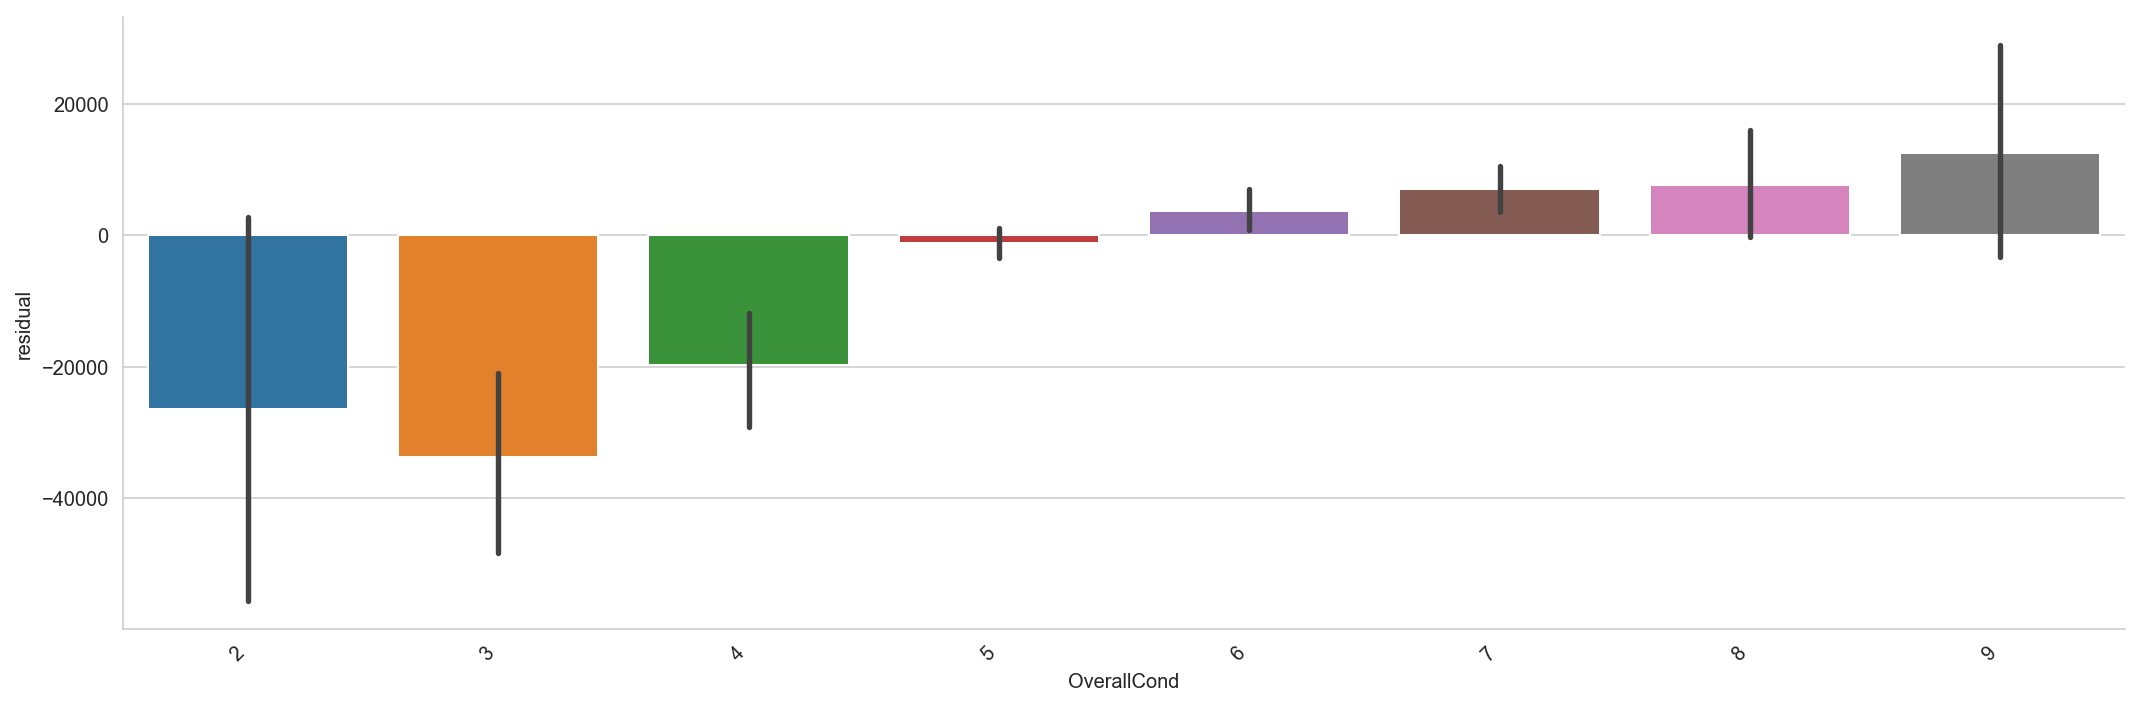

In [87]:
for var in ['OverallQual', 'OverallCond']:
    sns.catplot(x = var, y = 'residual', data = house, kind = 'bar',
        aspect = 3).set_xticklabels(rotation = 45, horizontalalignment = 'right')

It seems that OverallQual and OverallCond have great effects.

Let's check other changeable categorical variables.

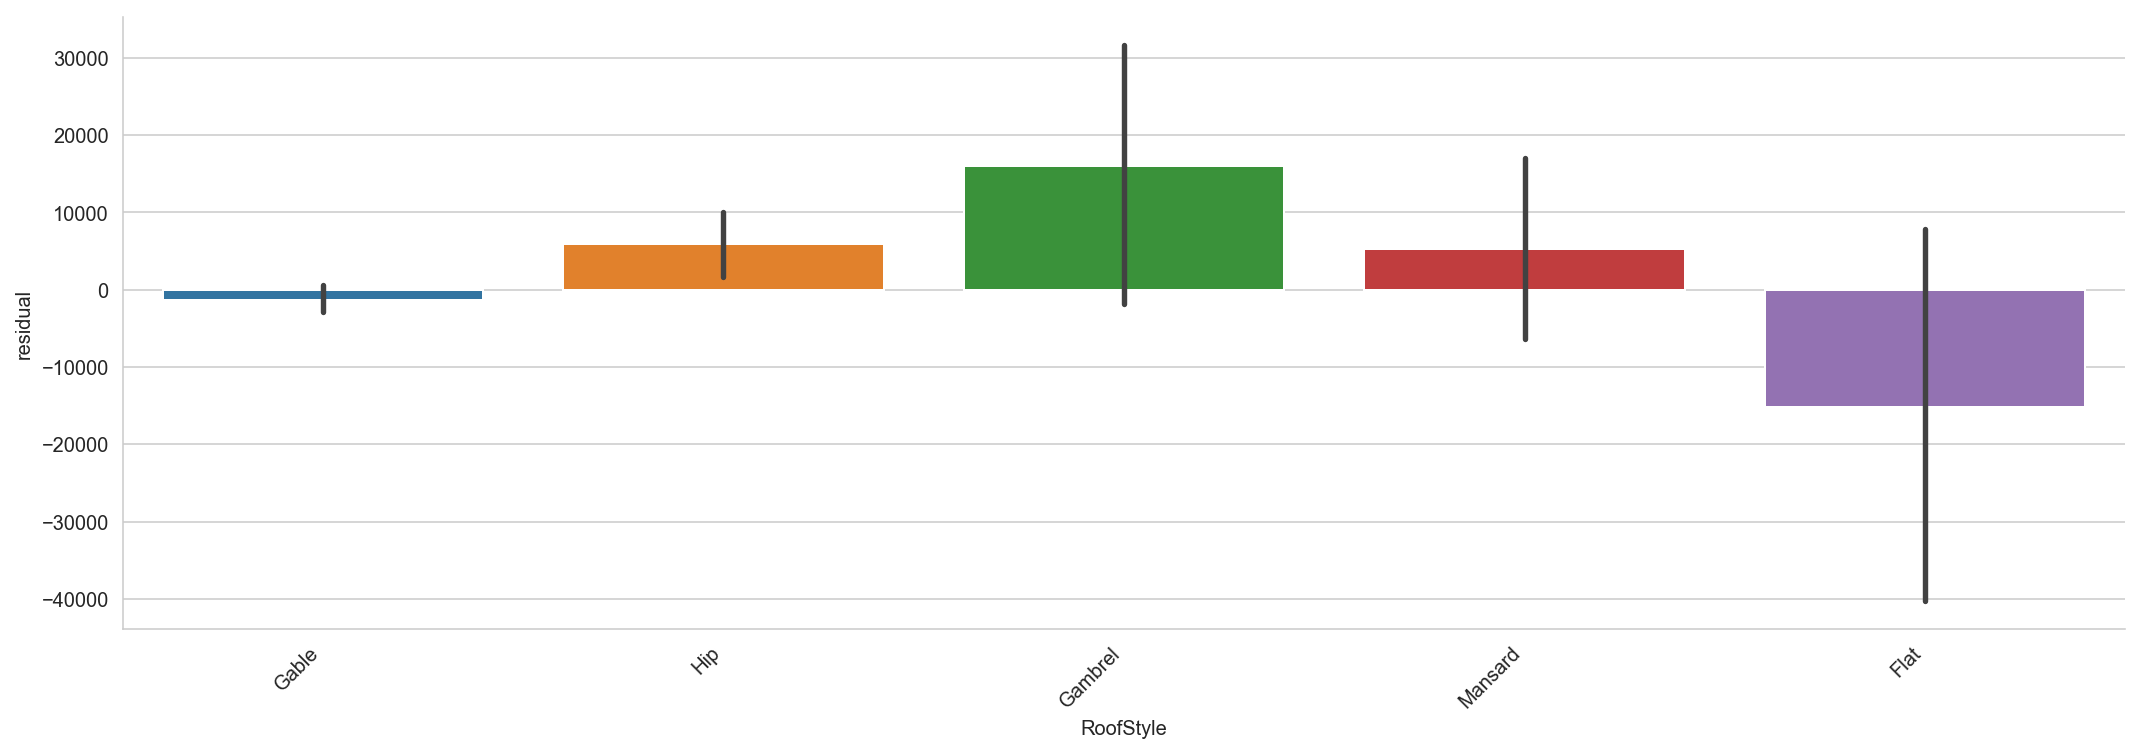

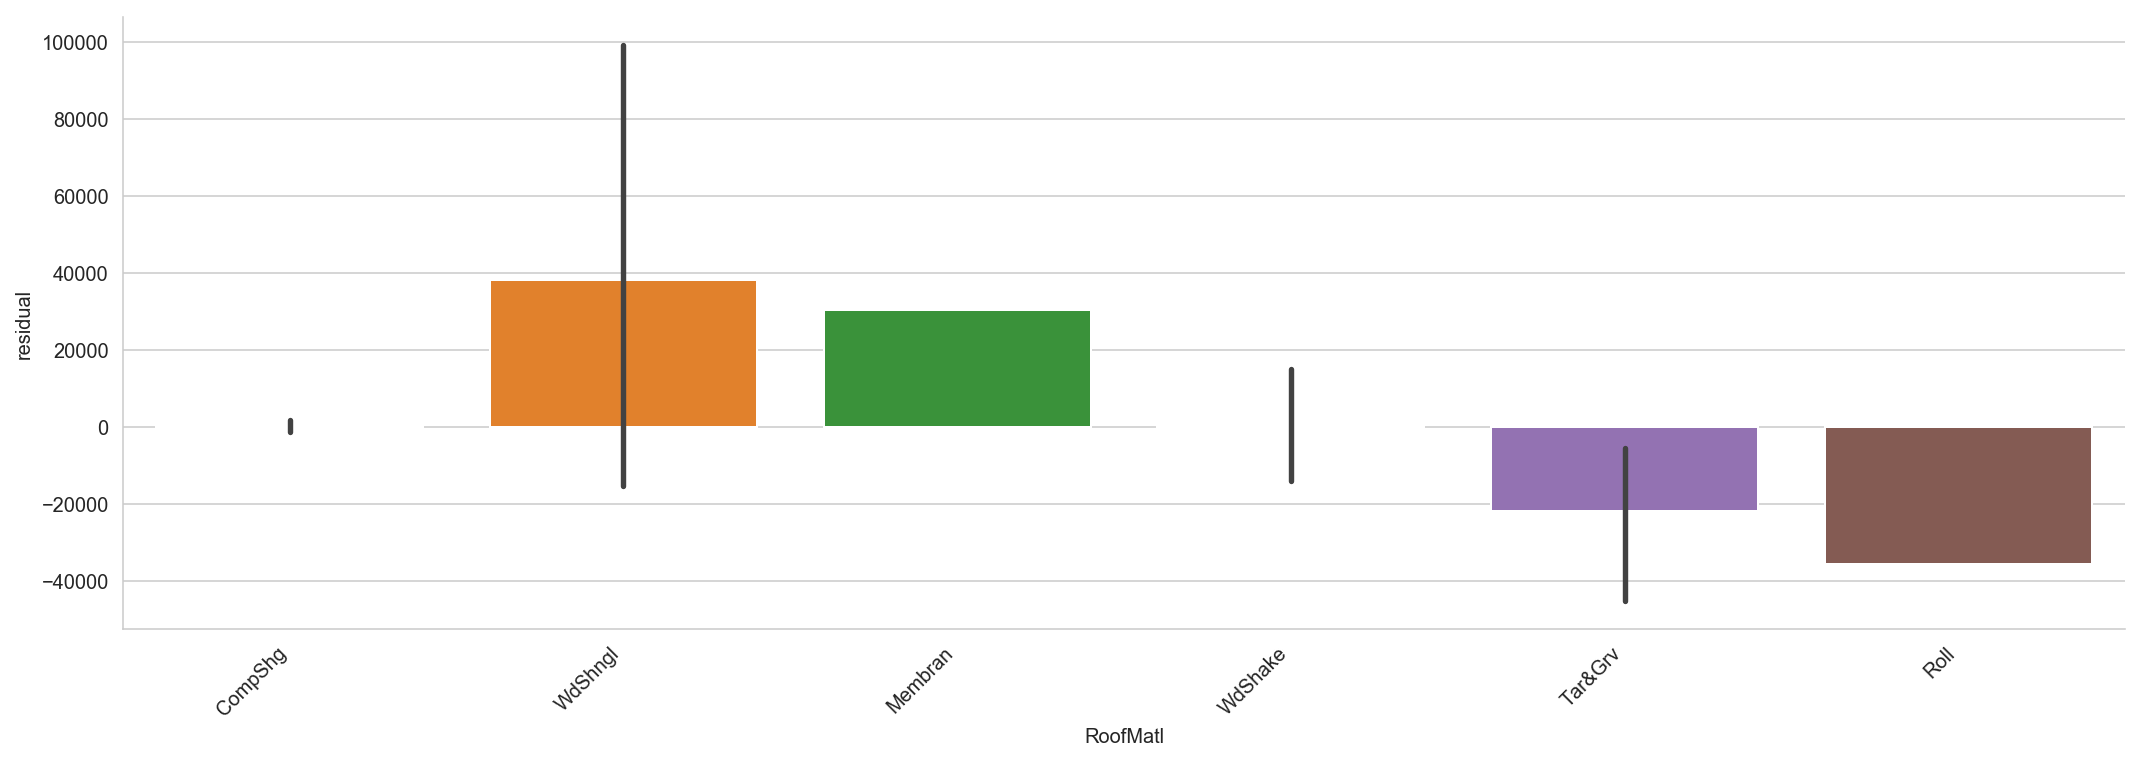

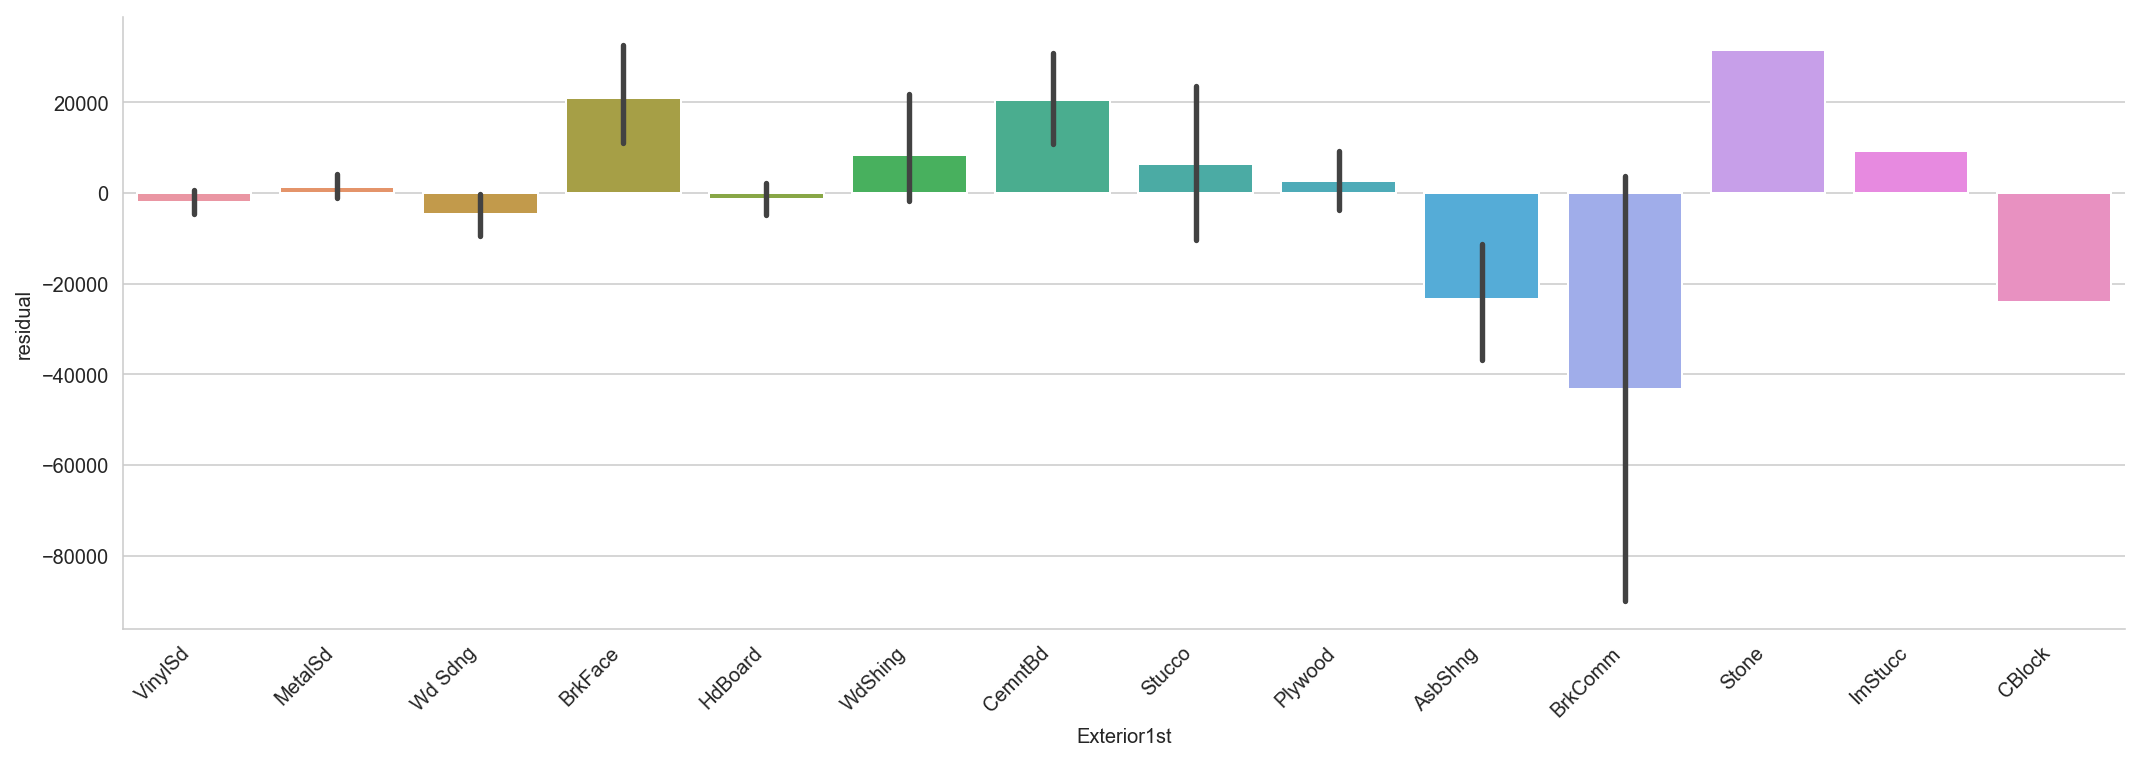

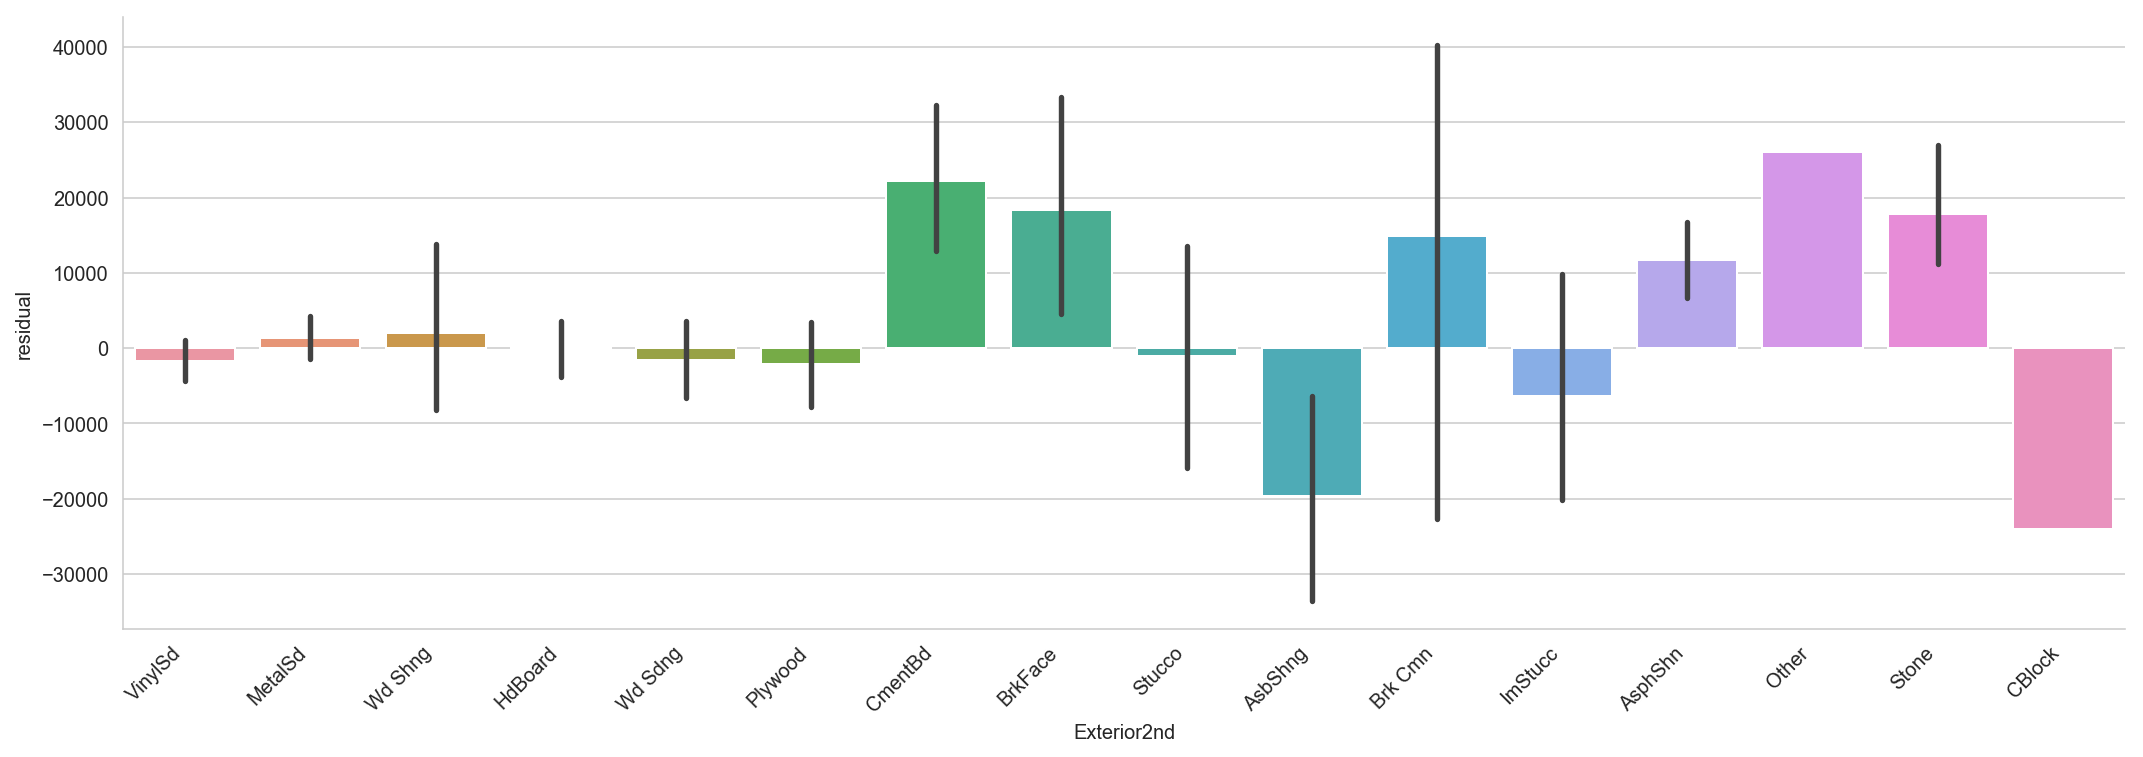

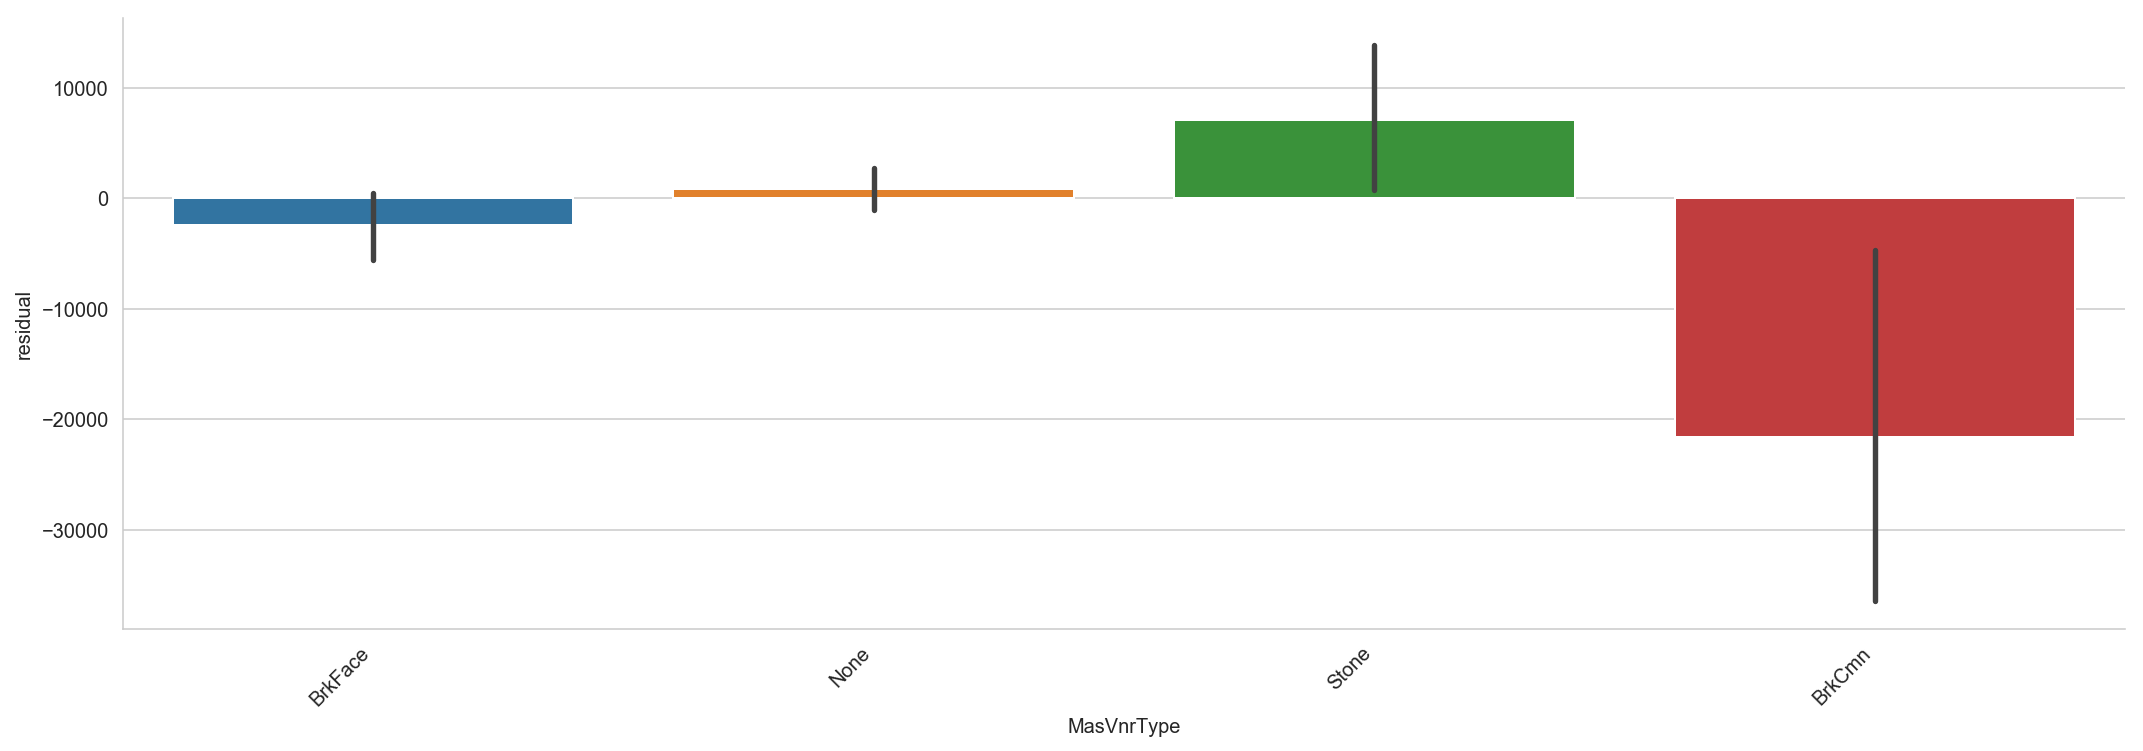

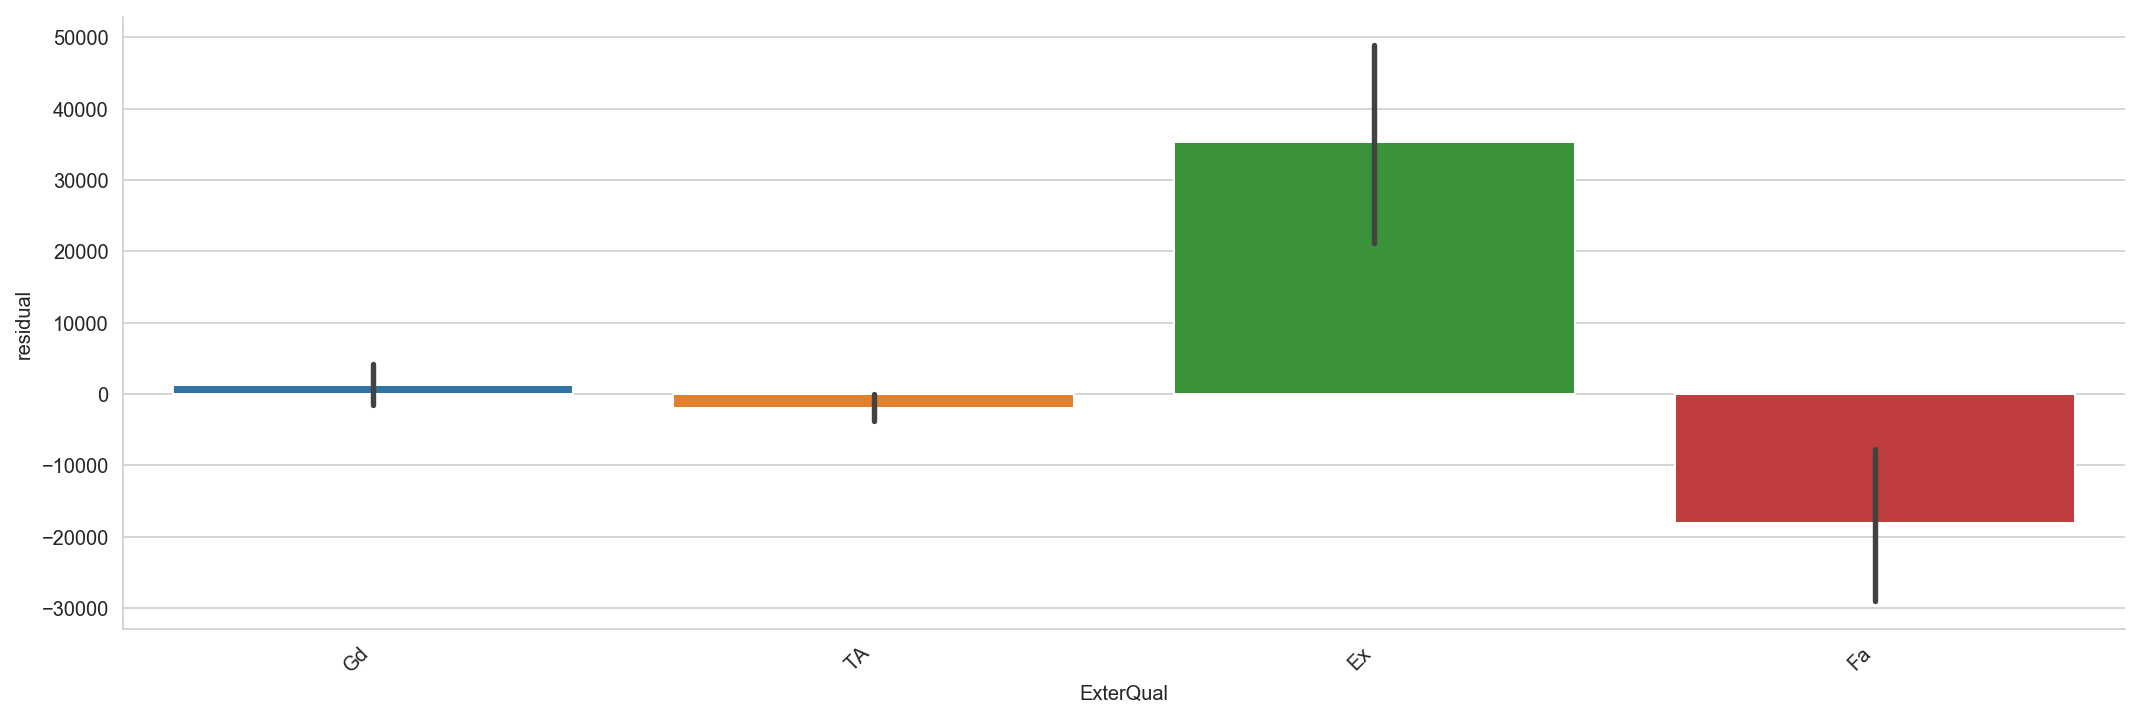

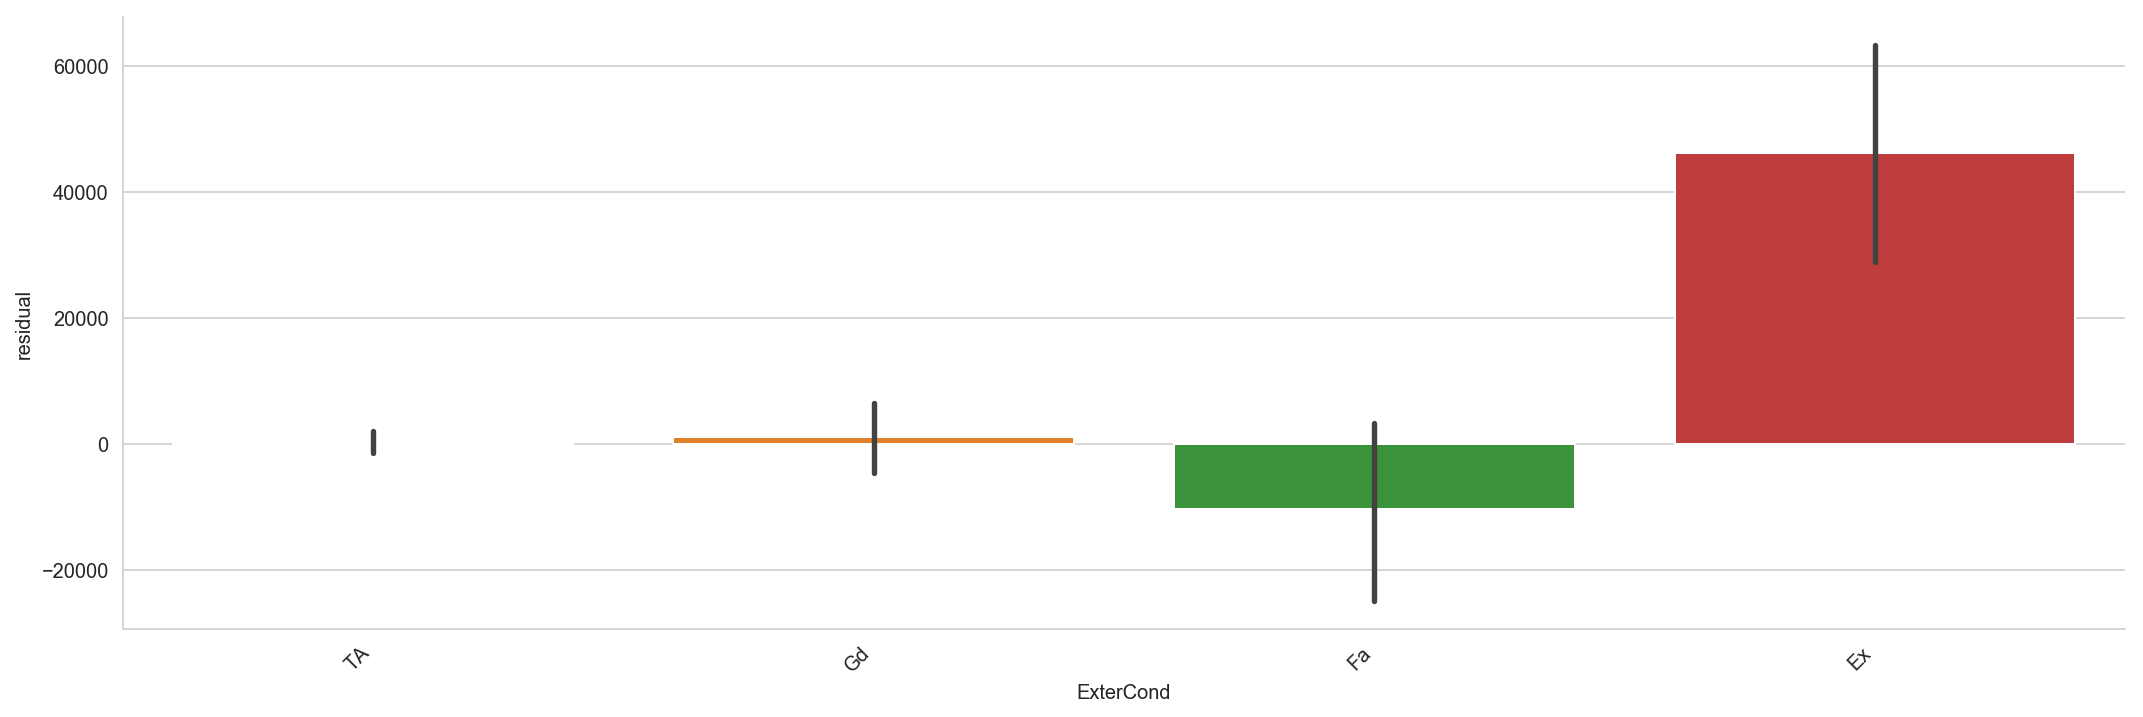

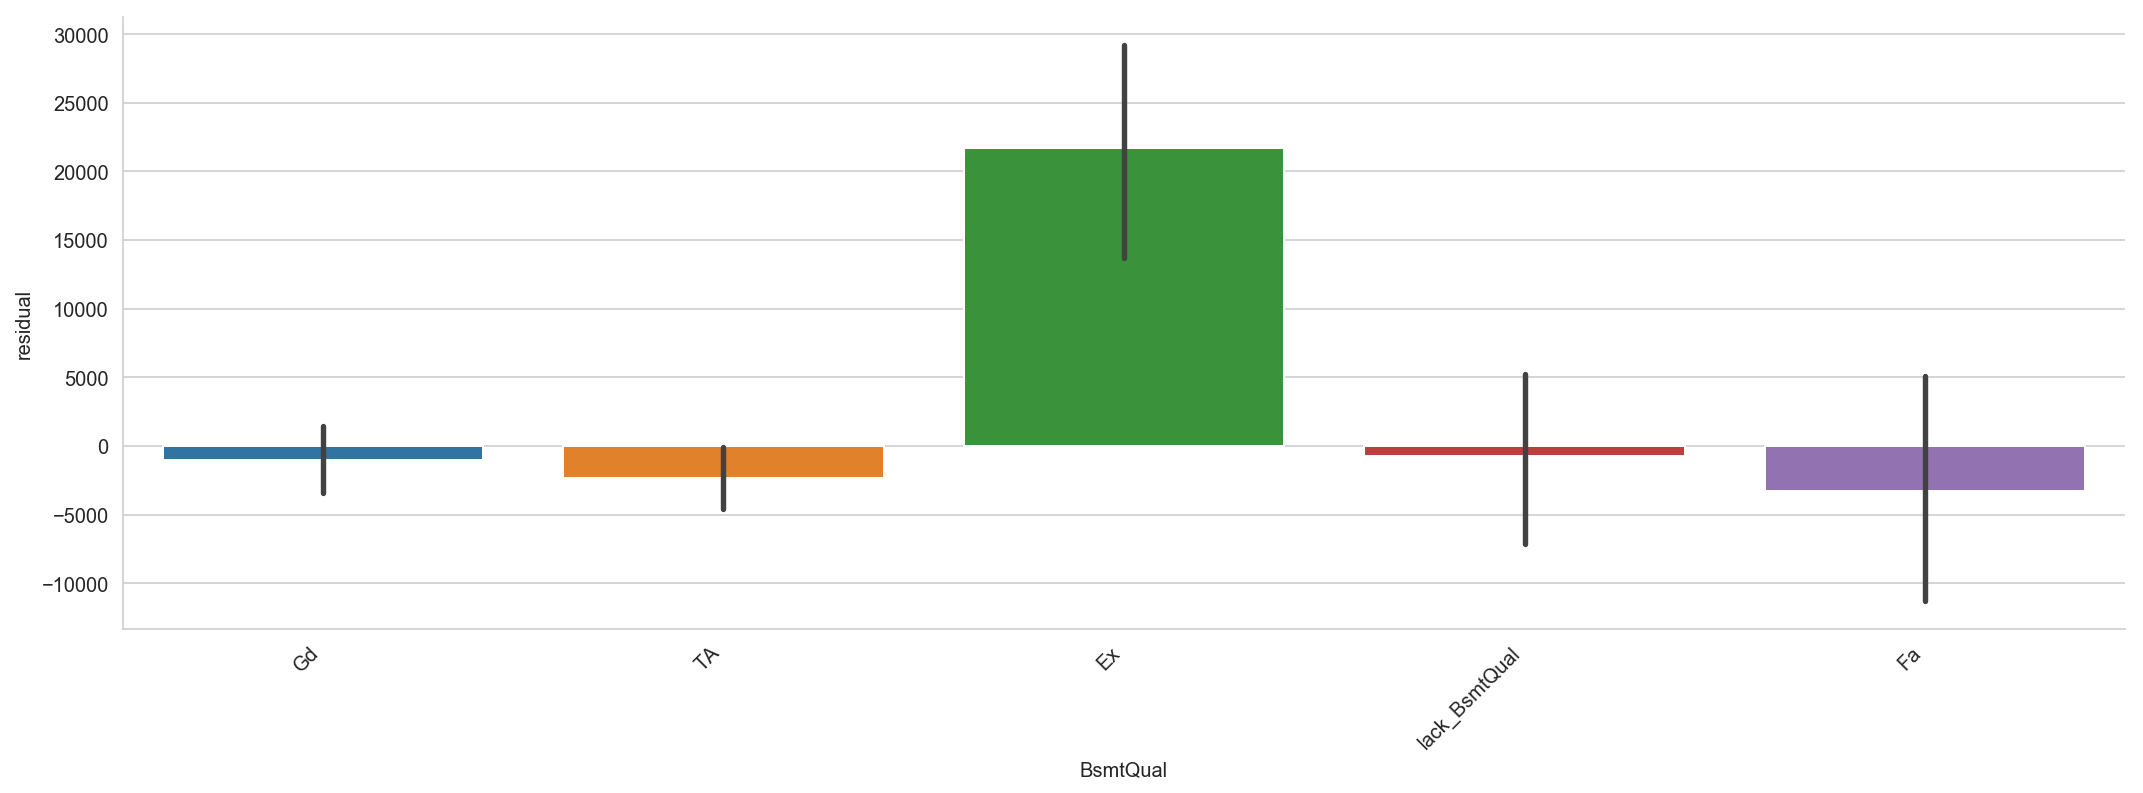

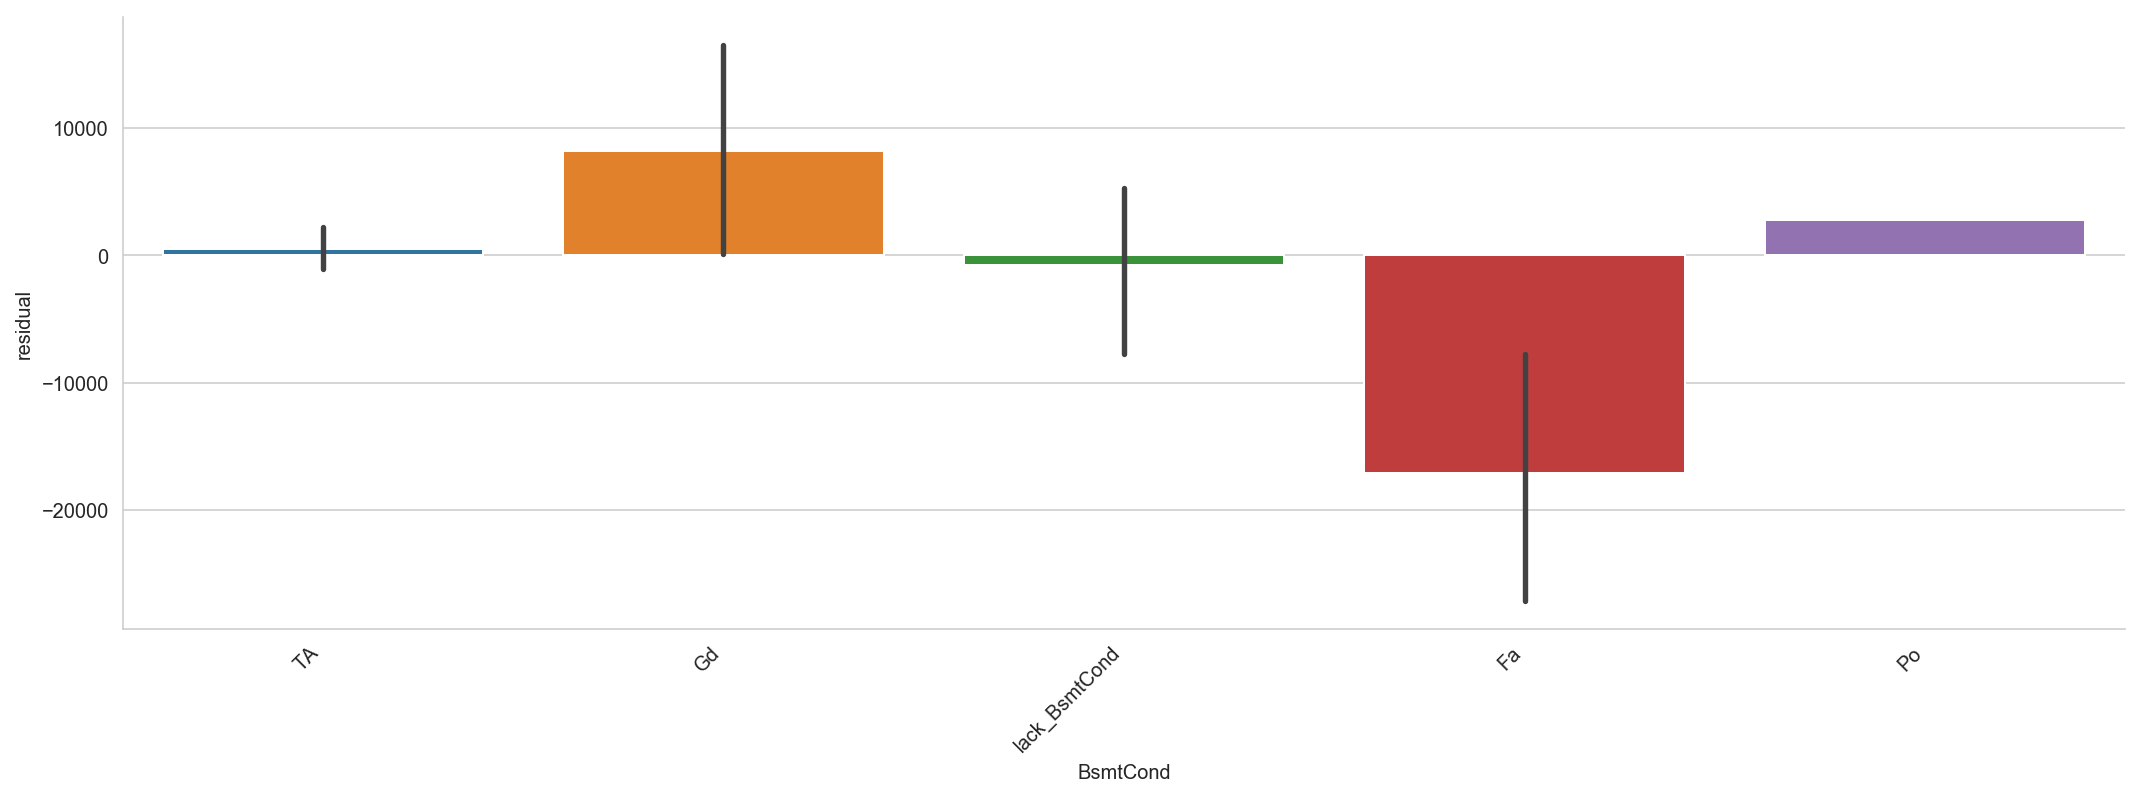

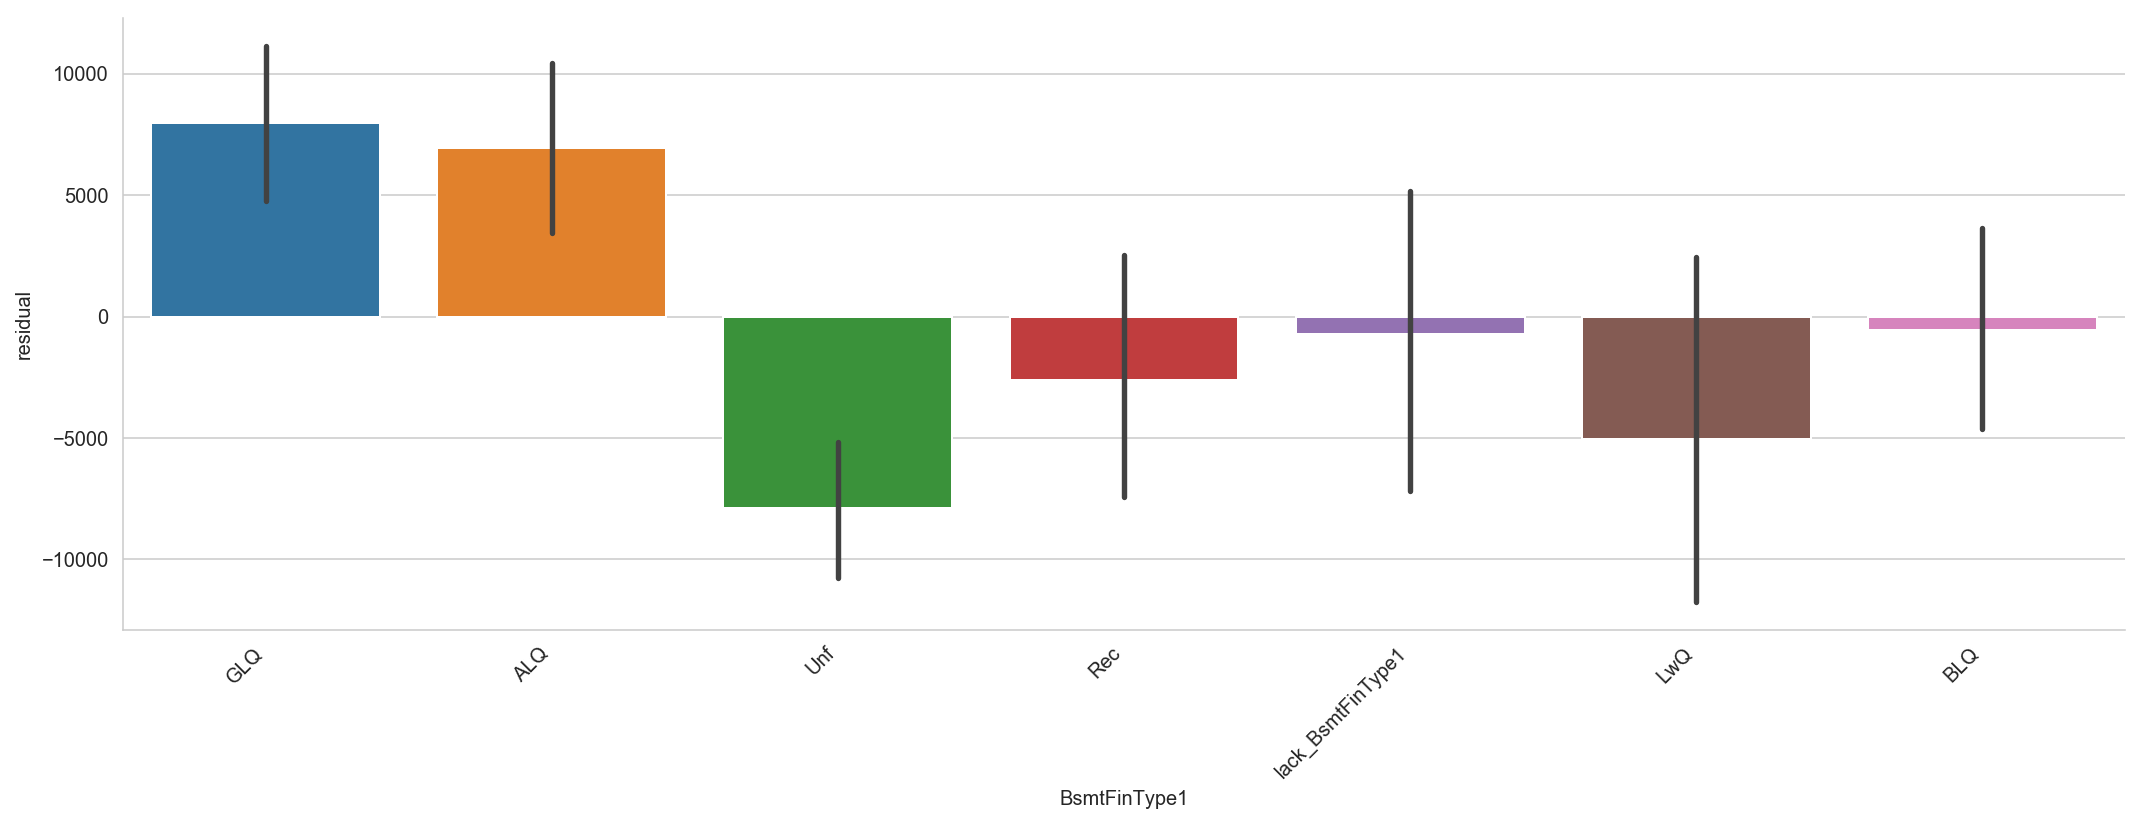

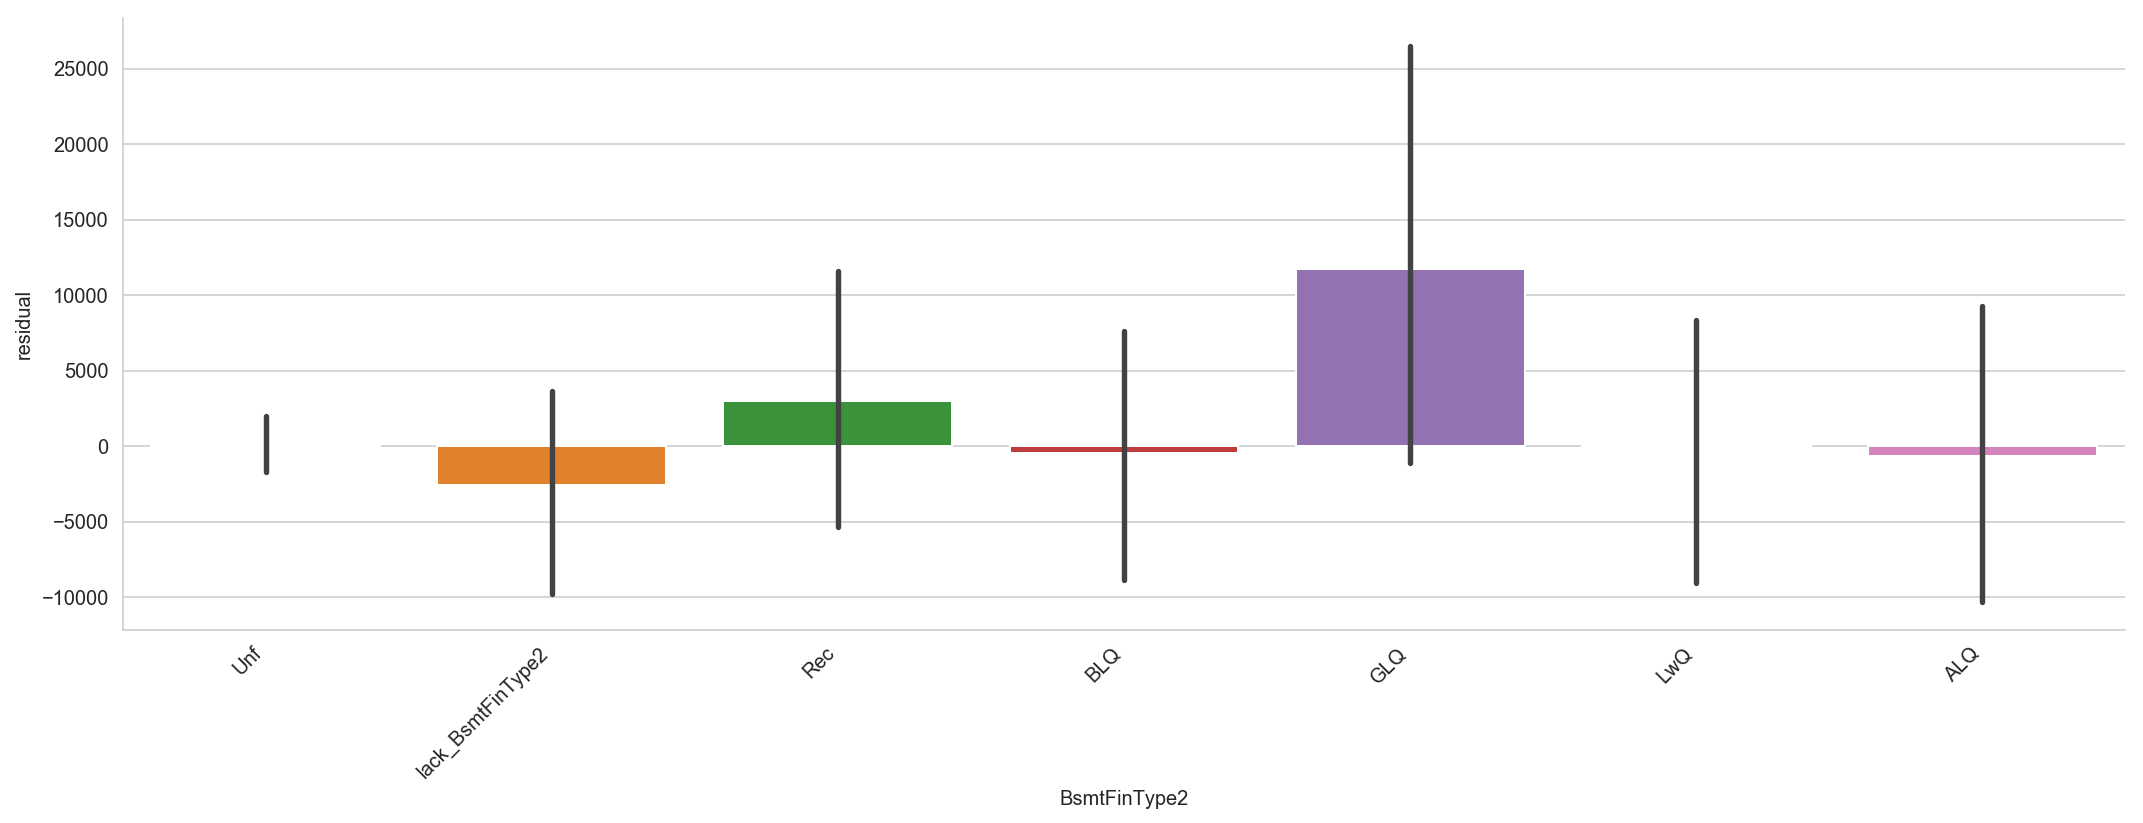

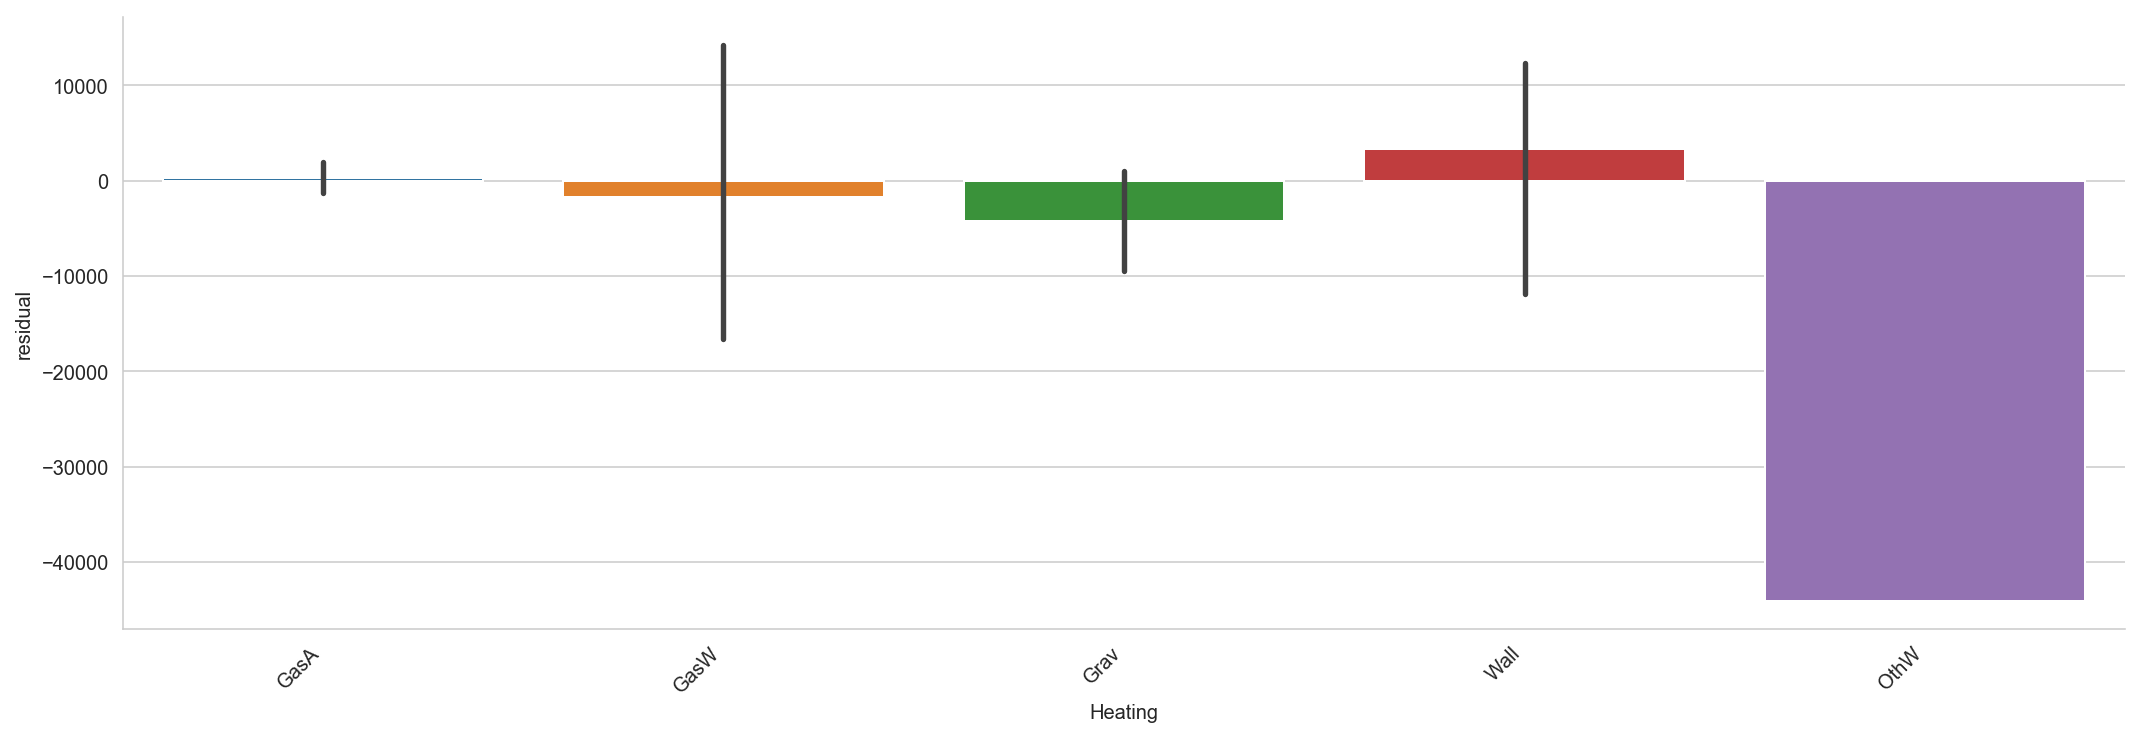

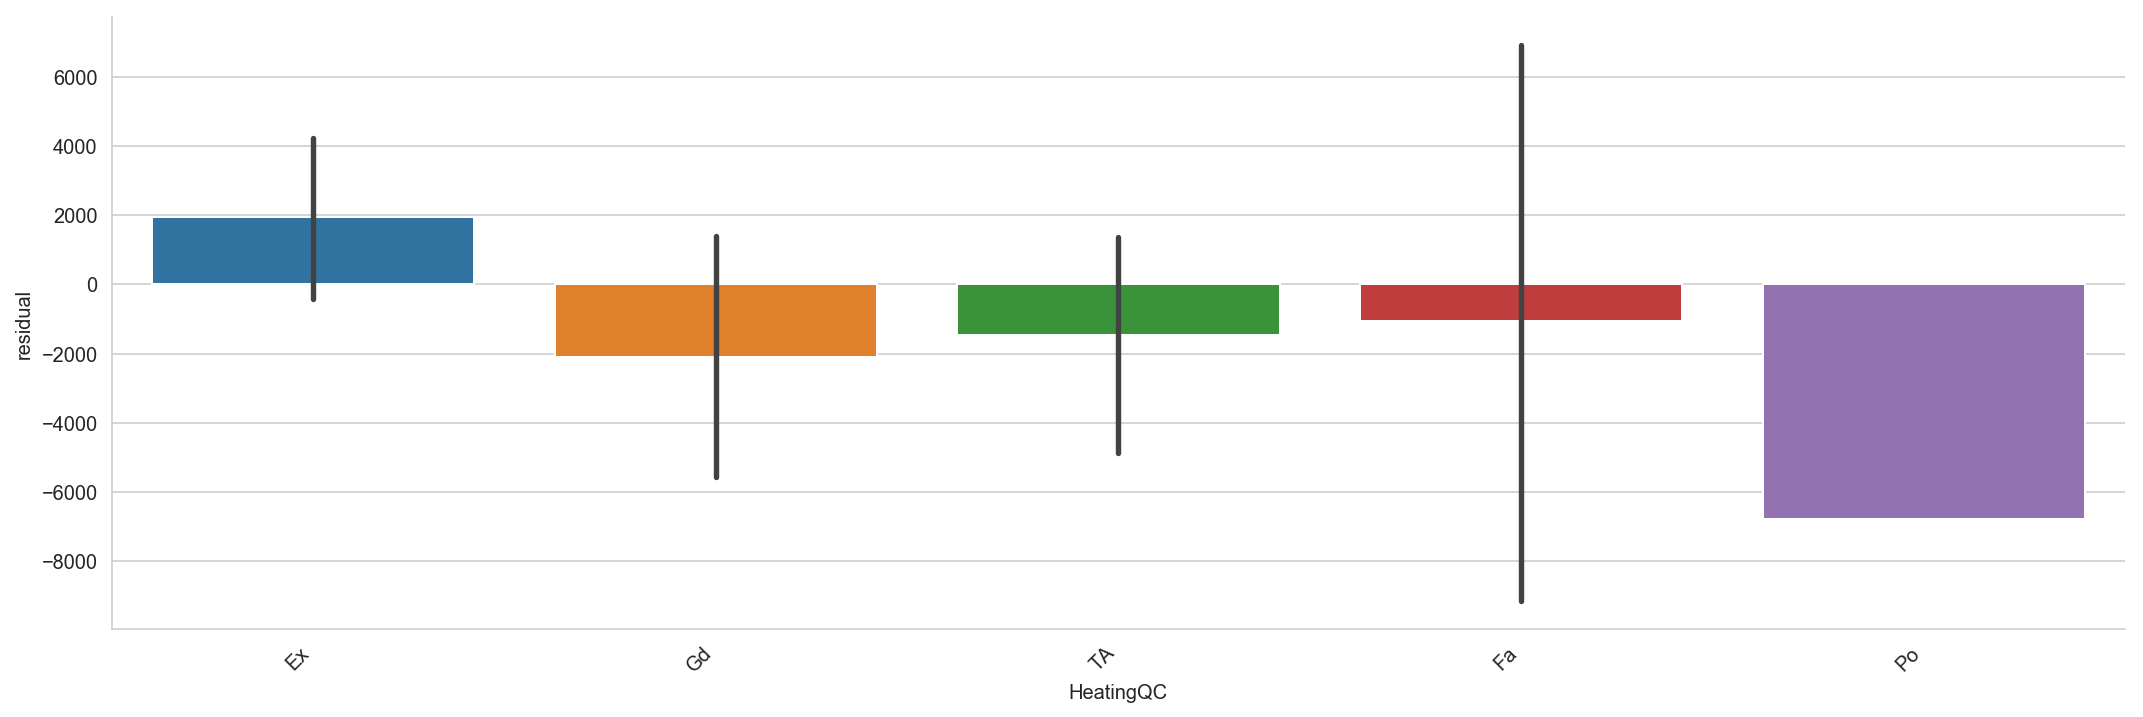

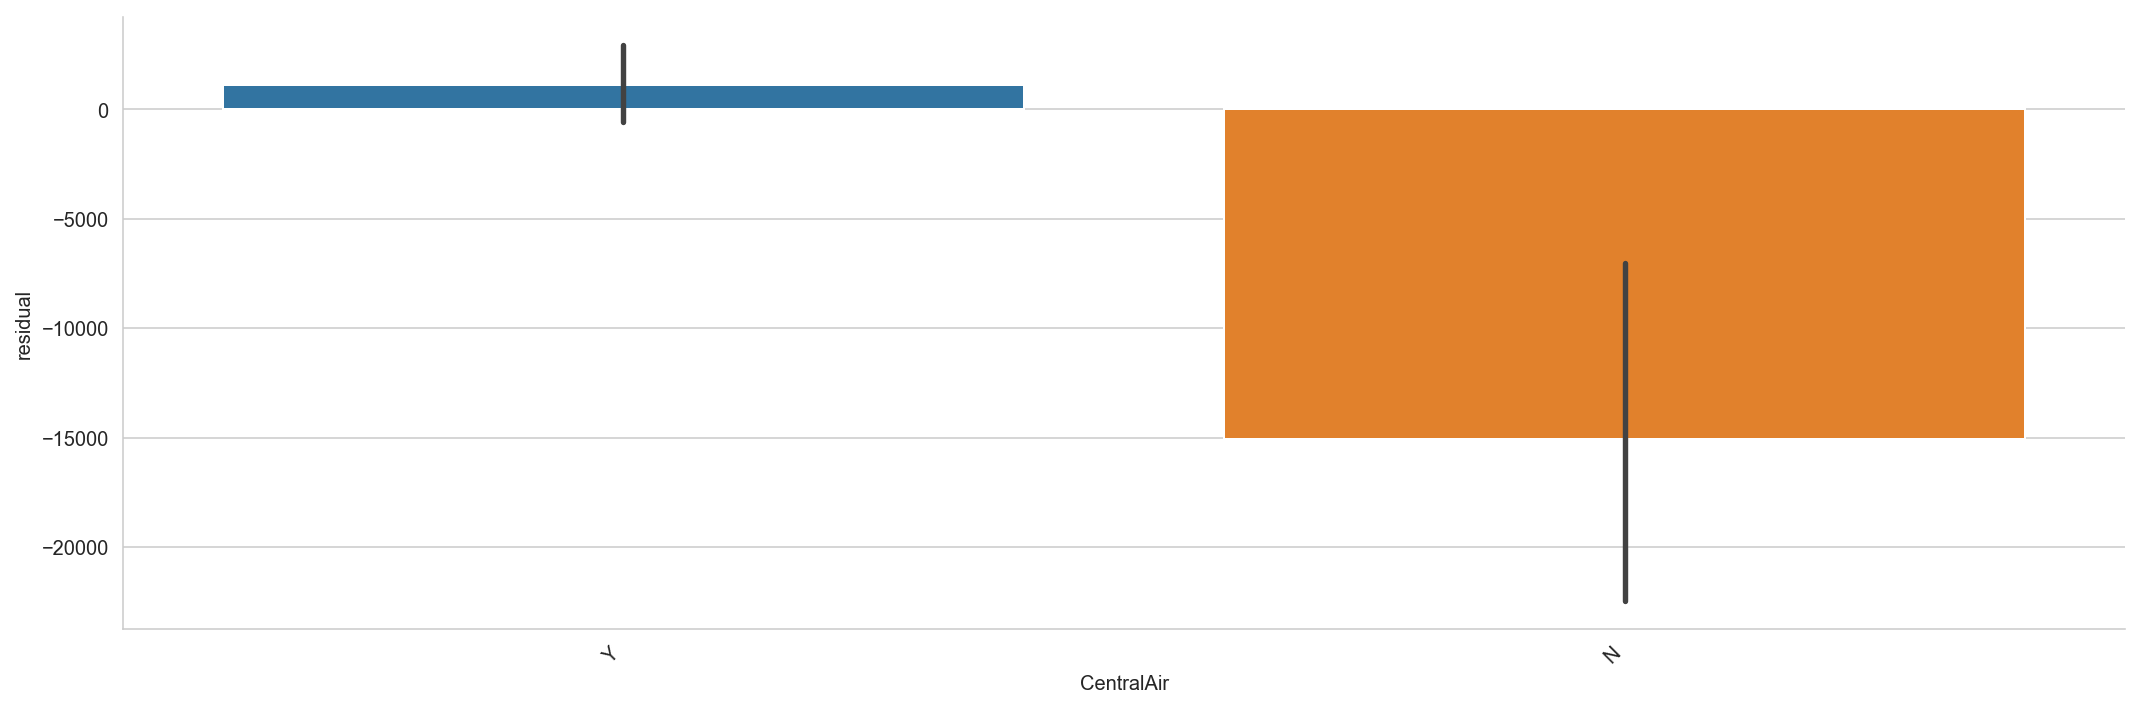

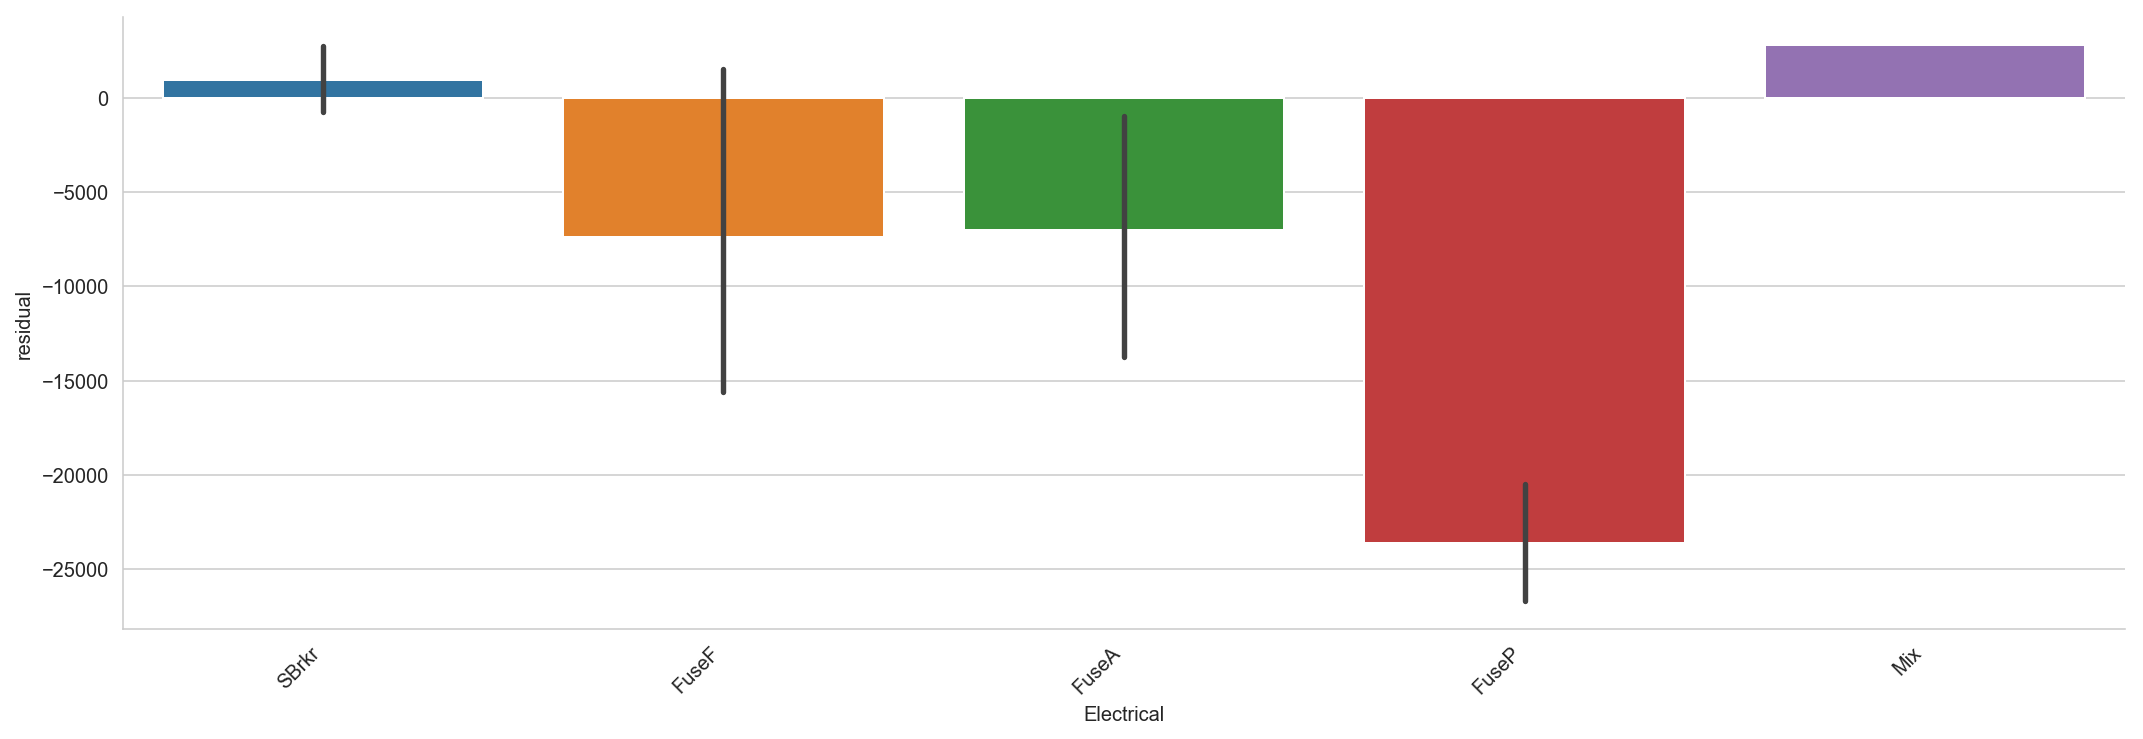

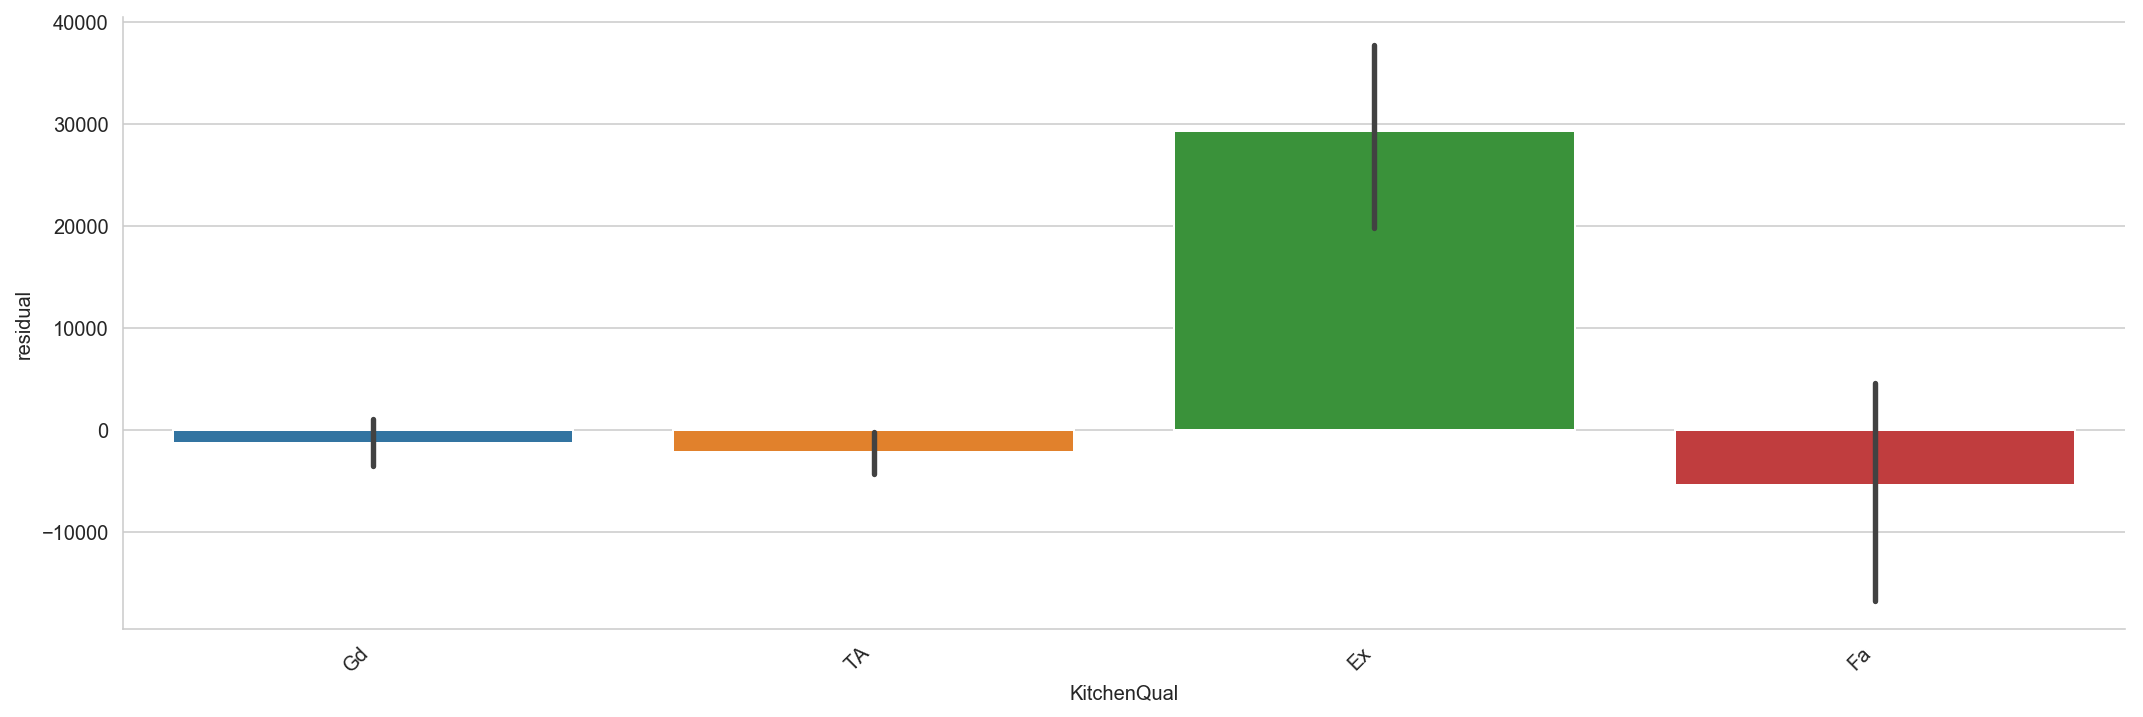

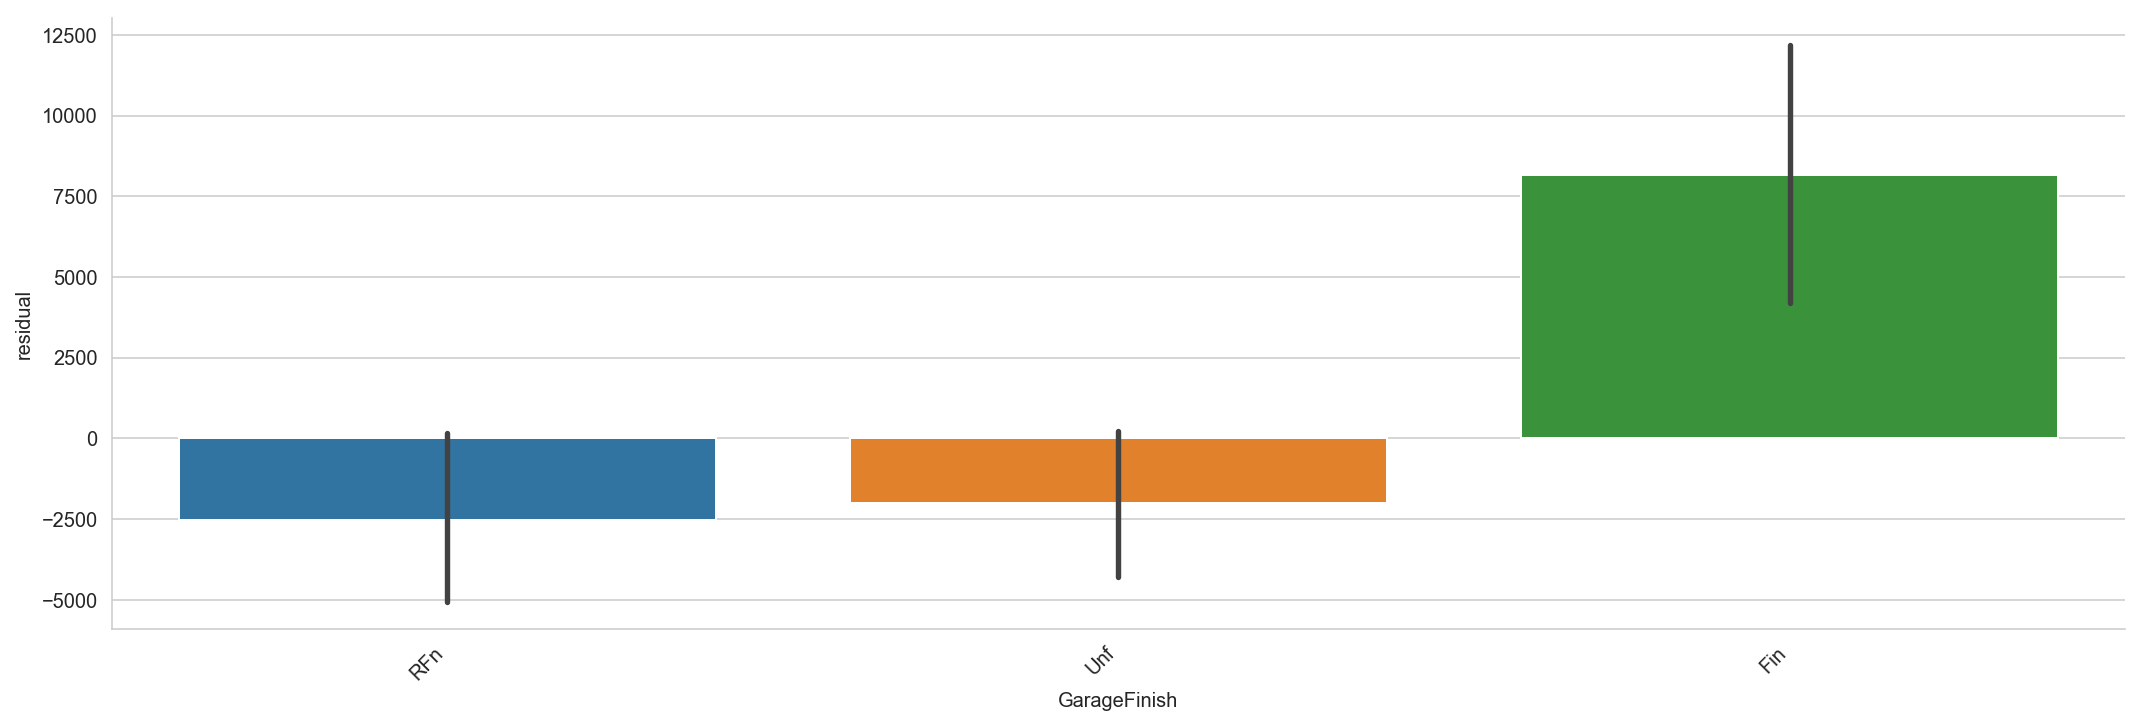

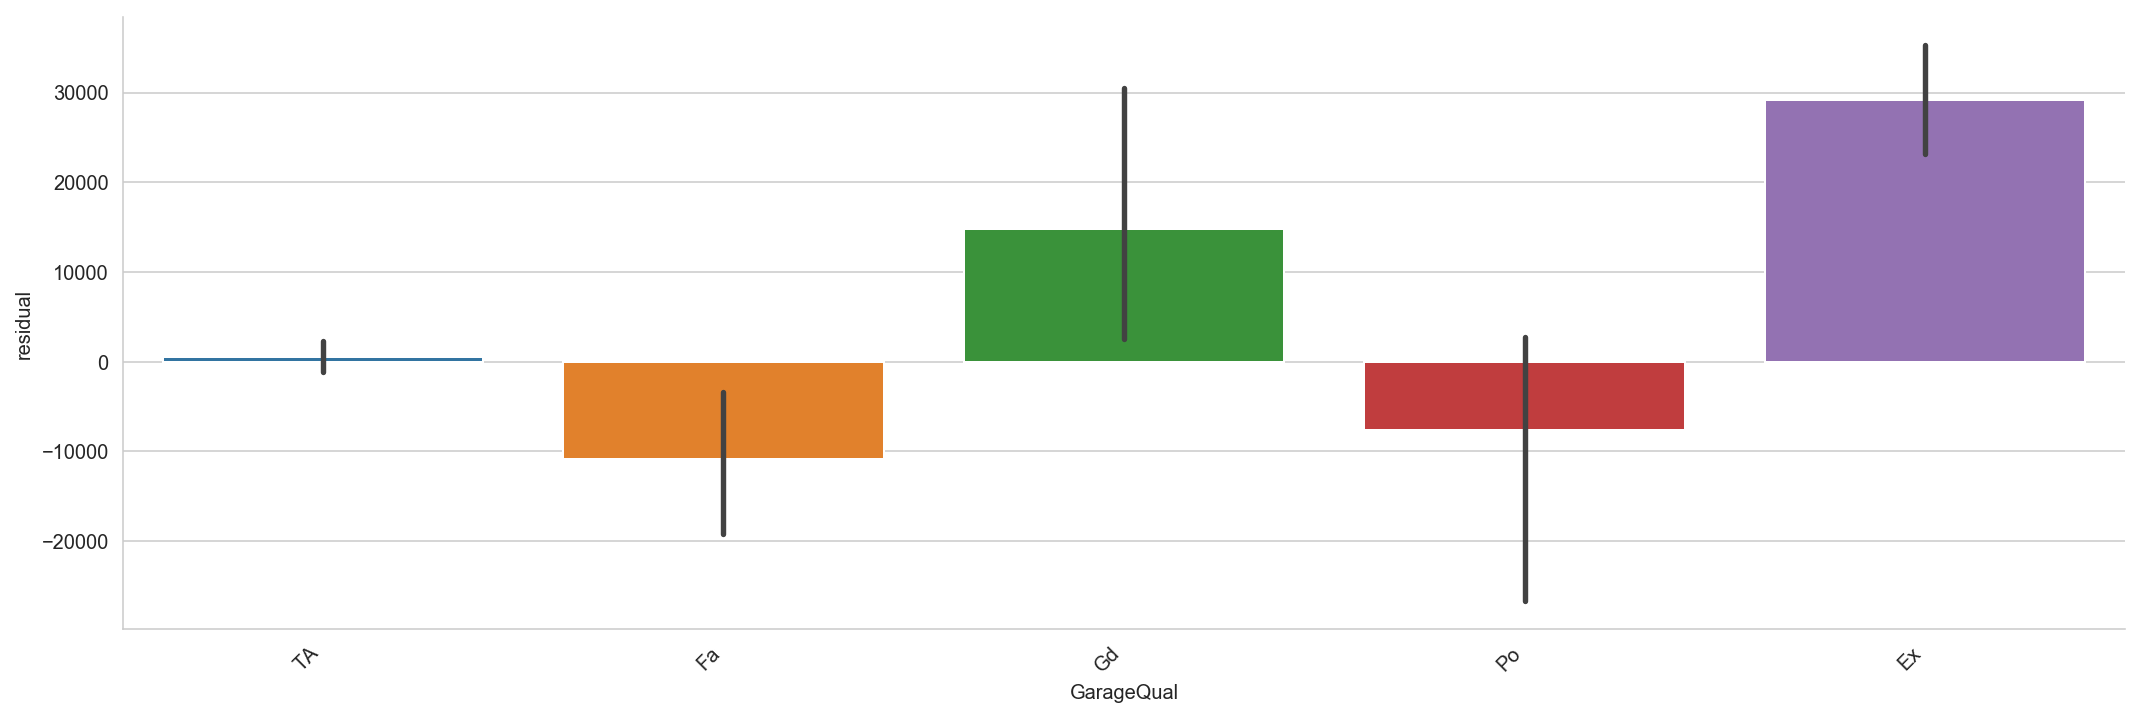

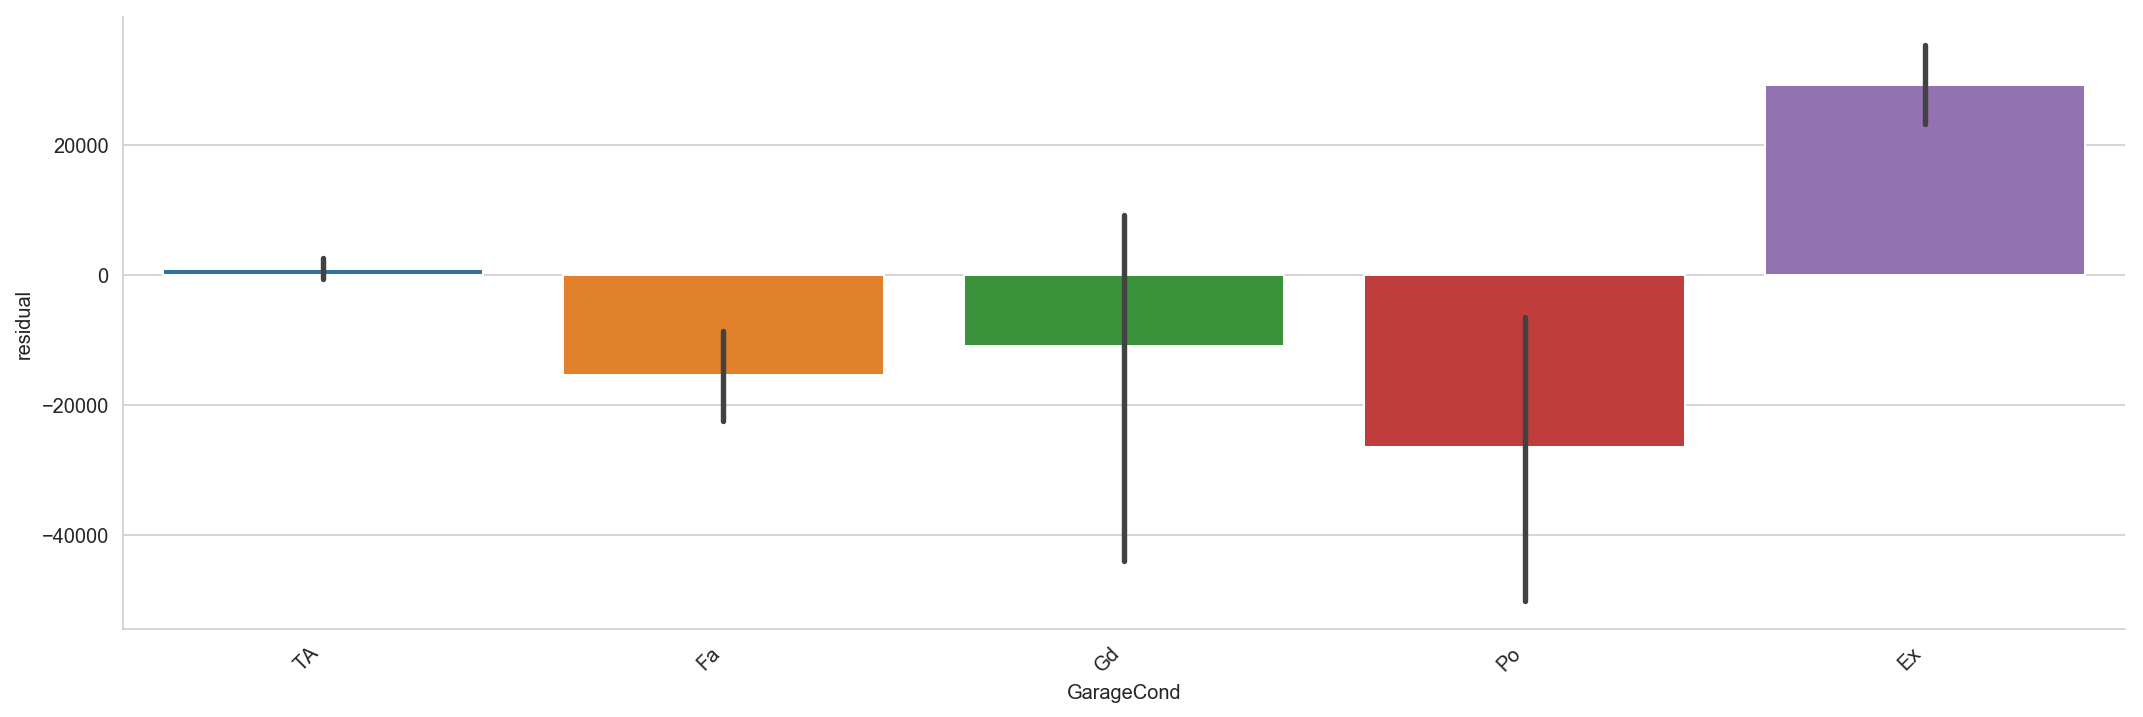

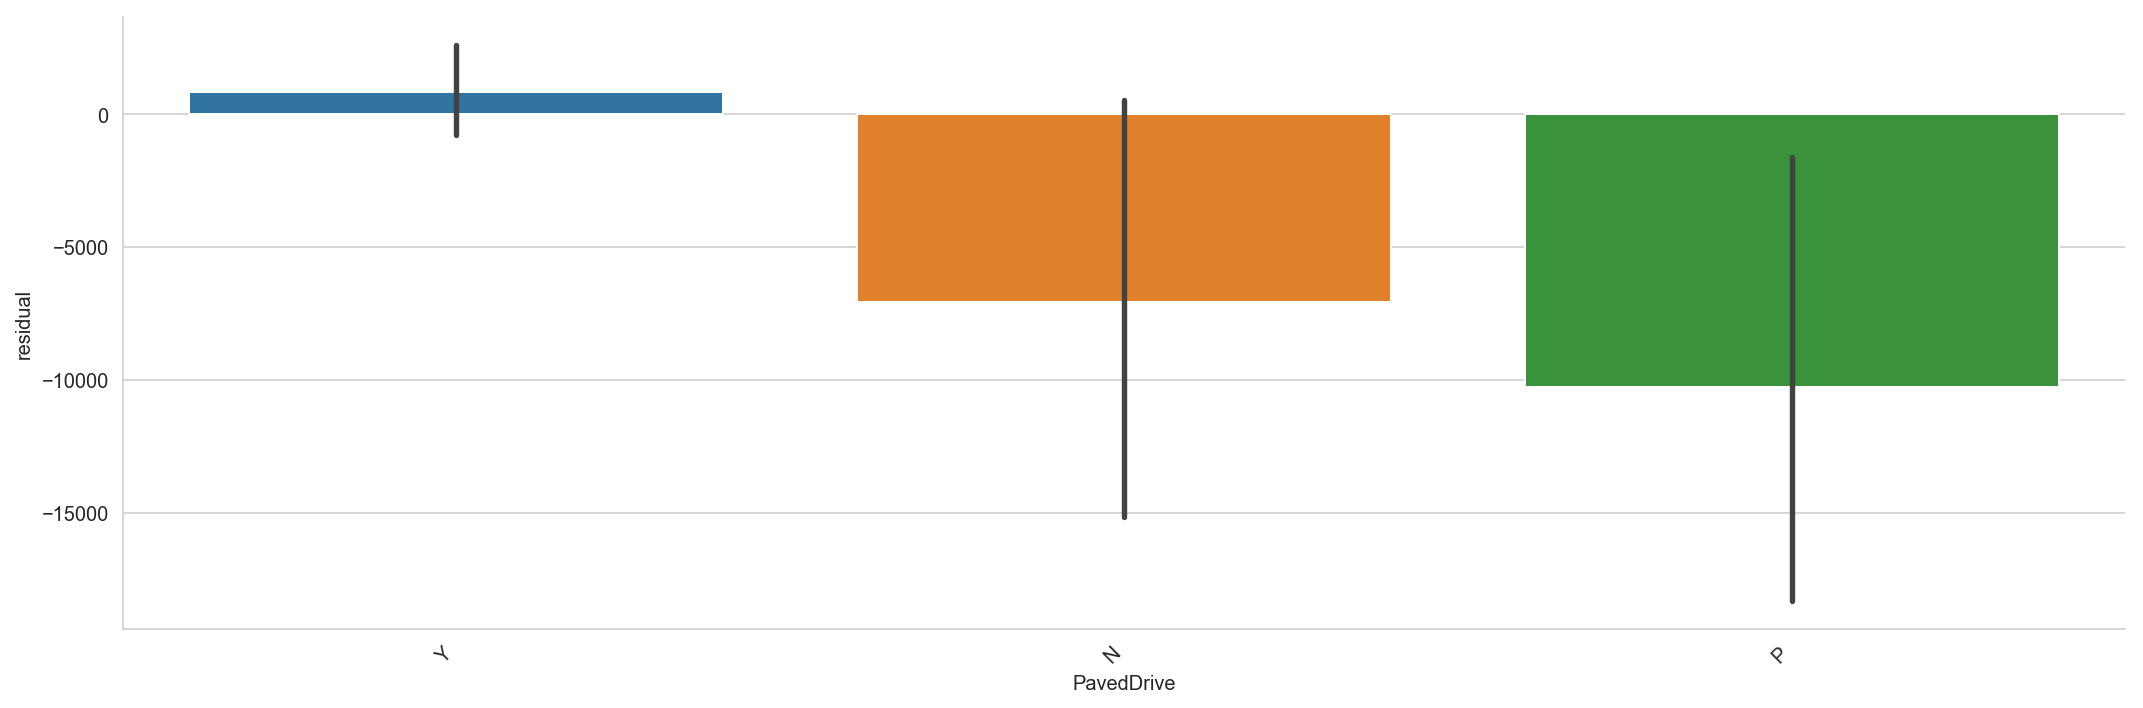

In [88]:
for var in [char for char in cat_char_renov if not char in ['OverallQual', 'OverallCond']]:
    sns.catplot(x = var, y = 'residual', data = house, kind = 'bar',
        aspect = 3).set_xticklabels(rotation = 45, horizontalalignment = 'right')

We group the data by each class of each variable and check mainly two things: number of houses in each class (i.e count) and standard deviation (i.e. std) of SalePrice for each class. This can help us with feature selection later.

In [89]:
# deviding the standard deviation by the mean to better understand the variance of SalePrice in a class
for var in cat_char_renov:
        var_table = house.groupby(var)['residual'].describe()
        var_table['std/mean'] = var_table['std']/var_table['mean']
        print(var_table[['count', 'std/mean']].sort_values(by = 'std/mean'), "\n")

             count   std/mean
OverallQual                  
7            260.0 -13.360889
6            270.0  -8.899759
5            302.0  -6.798454
4             70.0  -3.643959
3             10.0  -1.479046
10             7.0   0.706751
9             32.0   0.844822
8            135.0   3.301812
2              1.0        NaN 

             count   std/mean
OverallCond                  
5            631.0 -23.152085
2              2.0  -1.563024
4             38.0  -1.377716
3             14.0  -0.841967
9             12.0   2.278114
7            147.0   3.156767
8             57.0   4.189087
6            186.0   5.921091 

           count   std/mean
RoofStyle                  
Gable      851.0 -20.402349
Flat         6.0  -2.328129
Gambrel      9.0   1.717274
Mansard      6.0   3.180231
Hip        215.0   5.545638 

           count    std/mean
RoofMatl                    
Tar&Grv      6.0   -1.297690
WdShngl      4.0    1.645312
WdShake      2.0   36.157384
CompShg   1073.0  113.0

As it is seen, there are not many houses for some classes. Also, the standard deviation of SalePrice is low (in comparison to its mean) for some classes.

Now we convert the variables into dummy variables and then decide how to select each one as a features through different techniques.

In [90]:
for var in [char for char in cat_char_renov if not char in ['OverallQual', 'OverallCond']]:
    # converting into dummy variable
    var_dummies = pd.get_dummies(house[var], drop_first = True)

    # adding the dummy variable to the dataframe
    features_renov = features_renov.merge(var_dummies, left_index = True, right_index = True, how = 'outer')

In [91]:
features_renov.head()

residual  YrSold  Gable  Gambrel  Hip  Mansard  Membran  Roll  \
0   9720.277179641766    2008      1        0    0        0        0     0   
1   4213.363782844186    2007      1        0    0        0        0     0   
2  18196.625275225728    2008      1        0    0        0        0     0   
3 -3812.7696018664865    2006      1        0    0        0        0     0   
4 -25979.405631970963    2008      1        0    0        0        0     0   

   Tar&Grv  WdShake  ...  Fa_y  Gd_x  Po_x  TA_x  Fa  Gd_y  Po_y  TA_y  P  Y_y  
0        0        0  ...     0     0     0     1   0     0     0     1  0    1  
1        0        0  ...     0     0     0     1   0     0     0     1  0    1  
2        0        0  ...     0     0     0     1   0     0     0     1  0    1  
3        0        0  ...     0     0     0     1   0     0     0     1  0    1  
4        0        0  ...     0     0     0     1   0     0     0     1  0    1  

[5 rows x 96 columns]

In [92]:
# selection based on mutual information regression scores
X = features_renov.iloc[:,2:]
y = features_renov.residual

selector = SelectKBest(mutual_info_regression, k = 5)
selector.fit(X,y)

feature_by_mutualinf_catvar_renov = pd.DataFrame(selector.scores_, features_renov.iloc[:,2:].columns, columns = ['score'])
feature_by_mutualinf_catvar_renov.sort_values(by = 'score', ascending = False, inplace = True)
feature_by_mutualinf_catvar_renov.head(10)

score
MetalSd_x  0.030898
Gable      0.029372
Unf_x      0.029107
MetalSd_y  0.023793
Hip        0.023297
TA_x       0.023200
Stone      0.021323
TA_x       0.020194
VinylSd_y  0.012895
TA_y       0.012514

In [93]:
# find the corresponding characteristics of certain classes
char_list_mutualinf = []
for k, v in cat_char_dict.items():
    for cls in v:
        if cls in feature_by_mutualinf_catvar_renov.index[0:25]:
            char_list_mutualinf.append(k)
char_list = pd.unique(char_list_mutualinf)
print(char_list_mutualinf)
print('number of corresponding characteristics:', len(char_list_mutualinf))

['RoofStyle', 'RoofStyle', 'RoofStyle', 'Exterior1st', 'Exterior2nd', 'MasVnrType', 'MasVnrType', 'Foundation', 'BsmtCond', 'BsmtFinType1', 'GarageFinish']
number of corresponding characteristics: 11


In [94]:
# selection based on F-regression scores
X = features_renov.iloc[:,2:]
y = features_renov.residual

selector = SelectKBest(f_regression, k = 5)
selector.fit(X,y)

feature_by_freg_catvar_renov = pd.DataFrame(selector.scores_, features_renov.iloc[:,2:].columns, columns = ['score'])
feature_by_freg_catvar_renov.sort_values(by = 'score', ascending = False, inplace = True)
feature_by_freg_catvar_renov.head(10)

score
Unf_x      44.162259
GLQ_x      34.476646
CmentBd    27.154548
BrkFace_x  23.000615
CemntBd    22.626978
Y_x        19.720279
TA_y       13.077716
Gable      12.081153
Hip        11.410224
TA_x       10.389562

In [95]:
# find the corresponding characteristics of certain classes
char_list_freg = []
for k, v in cat_char_dict.items():
    for cls in v:
        if cls in feature_by_freg_catvar_renov.index[0:15]:
            char_list_freg.append(k)
char_list_freg = pd.unique(char_list_freg)
print(char_list_freg)
print('number of corresponding characteristics:', len(char_list_freg))

['RoofStyle' 'Exterior1st' 'Exterior2nd' 'ExterQual' 'ExterCond'
 'BsmtQual' 'BsmtCond' 'HeatingQC' 'KitchenQual' 'GarageQual' 'GarageCond']
number of corresponding characteristics: 11


In [96]:
# RFECV
X = features_renov.iloc[:,2:]
y = features_renov.residual

rfecv = RFECV(estimator = LinearRegression(), step = 1, cv = 5)
rfecv.fit(X, y)

RFECV(cv=5,
      estimator=LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None,
                                 normalize=False),
      min_features_to_select=1, n_jobs=None, scoring=None, step=1, verbose=0)

In [97]:
print("Optimal number of features according to RFECV is %d" % rfecv.n_features_)

Optimal number of features according to RFECV is 41


In [98]:
# a list of best features according to RFECV (all of them are ranked 1 so there is no priority here)
feature_by_rfecv_catvar_renov = [val for ind, val in enumerate(features_renov.iloc[:,2:].columns) if rfecv.ranking_[ind] == 1]

print(feature_by_rfecv_catvar_renov)

['Gable', 'Gambrel', 'Hip', 'Mansard', 'Membran', 'Roll', 'WdShngl', 'BrkComm', 'BrkFace_x', 'CBlock_x', 'CemntBd', 'ImStucc_x', 'Brk Cmn', 'CBlock_y', 'CmentBd', 'Other', 'Stone_y', 'BrkFace', 'None', 'Stone', 'Fa_y', 'Gd_y', 'TA_y', 'Gd_x', 'TA_x', 'lack_BsmtQual', 'lack_BsmtCond', 'LwQ_x', 'Unf_x', 'lack_BsmtFinType2', 'Grav', 'OthW', 'Y_x', 'Fa_x', 'Gd_y', 'TA_y', 'Fa_y', 'Po_x', 'TA_x', 'Gd_y', 'Po_y']


In [99]:
# find the corresponding characteristics of certain classes
char_list_rfecv = []
for k, v in cat_char_dict.items():
    for cls in v:
        if cls in feature_by_rfecv_catvar_renov:
            char_list_rfecv.append(k)
char_list_rfecv = pd.unique(char_list_rfecv)
print(char_list_rfecv)
print('number of corresponding characteristics:', len(char_list_rfecv))

['RoofStyle' 'RoofMatl' 'Exterior1st' 'Exterior2nd' 'MasVnrType'
 'Foundation' 'BsmtQual' 'BsmtCond' 'BsmtFinType2' 'Heating']
number of corresponding characteristics: 10


In [100]:
# Lasso
X = features_renov.iloc[:,2:]
y = features_renov.residual

lasso = Lasso(alpha = 0.025)
lasso.fit(X, y)


# a list of best features according to Lasso
feature_by_lasso_catvar_renov = pd.DataFrame(abs(lasso.coef_), features_renov.iloc[:,2:].columns,
                                columns = ['coefficient']).sort_values(by = 'coefficient', ascending = False)
feature_by_lasso_catvar_renov.head(10)

C:\Users\arman\Anaconda3\lib\site-packages\sklearn\linear_model\coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 255430178602.8098, tolerance: 81797584.31732725
  positive)


coefficient
Membran            60118.434903
CmentBd            49575.180245
Gambrel            47453.494926
lack_BsmtFinType2  44734.962893
Mansard            43682.447492
Po_y               41801.357095
Other              40910.586532
CemntBd            38742.752938
BrkComm            32260.348798
Fa_y               31202.670165

In [101]:
# find the corresponding characteristics of certain classes
char_list_lasso = []
for k, v in cat_char_dict.items():
    for cls in v:
        if cls in feature_by_lasso_catvar_renov.index[0:25]:
            char_list_lasso.append(k)
char_list_lasso = pd.unique(char_list_lasso)
print(char_list_lasso)
print('number of corresponding characteristics:', len(char_list_lasso))

['RoofStyle' 'RoofMatl' 'Exterior1st' 'Exterior2nd' 'MasVnrType'
 'Foundation' 'BsmtQual' 'BsmtFinType2']
number of corresponding characteristics: 8


Each of the above methos, gives us a different list of features. The overlaps can be a good starting point for feature selection.

In [102]:
overlap_renov = []
for var in char_list_freg:
    if var in char_list_mutualinf:
        if var in char_list_rfecv:
            if var in char_list_lasso:
                overlap_renov.append(var)

overlap_renov

['RoofStyle', 'Exterior1st', 'Exterior2nd']

Putting together the overlap of the different ranking lists, the plots and our domain knowlege, we select these characteristics: OverallQual, OverallCond, Electrical, RoofStyle, Exterior1st, BsmtQual

Now it is time to put all the categorical characteristics together and select features using more tests and the results above.

In [103]:
predictors_renov = ['OverallQual', 'OverallCond', 'Electrical', 'RoofStyle', 'Exterior1st', 'BsmtQual']

In [104]:
# cleaning the dataframe for new feature selection
features_renov.drop(features_renov.iloc[:, 2:].columns, axis = 1, inplace = True)

In [105]:
features_renov[['OverallQual', 'OverallCond']] = house[['OverallQual', 'OverallCond']]

In [106]:
for var in ['Electrical', 'RoofStyle', 'Exterior1st', 'BsmtQual']:
    # converting into dummy variable
    var_dummies = pd.get_dummies(house[var], drop_first = True)

    # adding the dummy variable to the dataframe
    features_renov = features_renov.merge(var_dummies, left_index = True, right_index = True, how = 'outer')

We make a model only based on the candidates.

In [107]:
X_train = features_renov[features_renov.YrSold != 2010].iloc[:, 2:]
X_test = features_renov[features_renov.YrSold == 2010].iloc[:, 2:]
y_train = features_renov[features_renov.YrSold != 2010].residual
y_test = features_renov[features_renov.YrSold == 2010].residual

model = RFECV(Ridge())
model.fit(X_train, y_train)
print(model.score(X_test, y_test))

C:\Users\arman\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:1978: FutureWarning: The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.
  warnings.warn(CV_WARNING, FutureWarning)


0.2169799383073796


[Text(0, 0.5, 'True SalePrice'), Text(0.5, 0, 'Predicted SalePrice')]

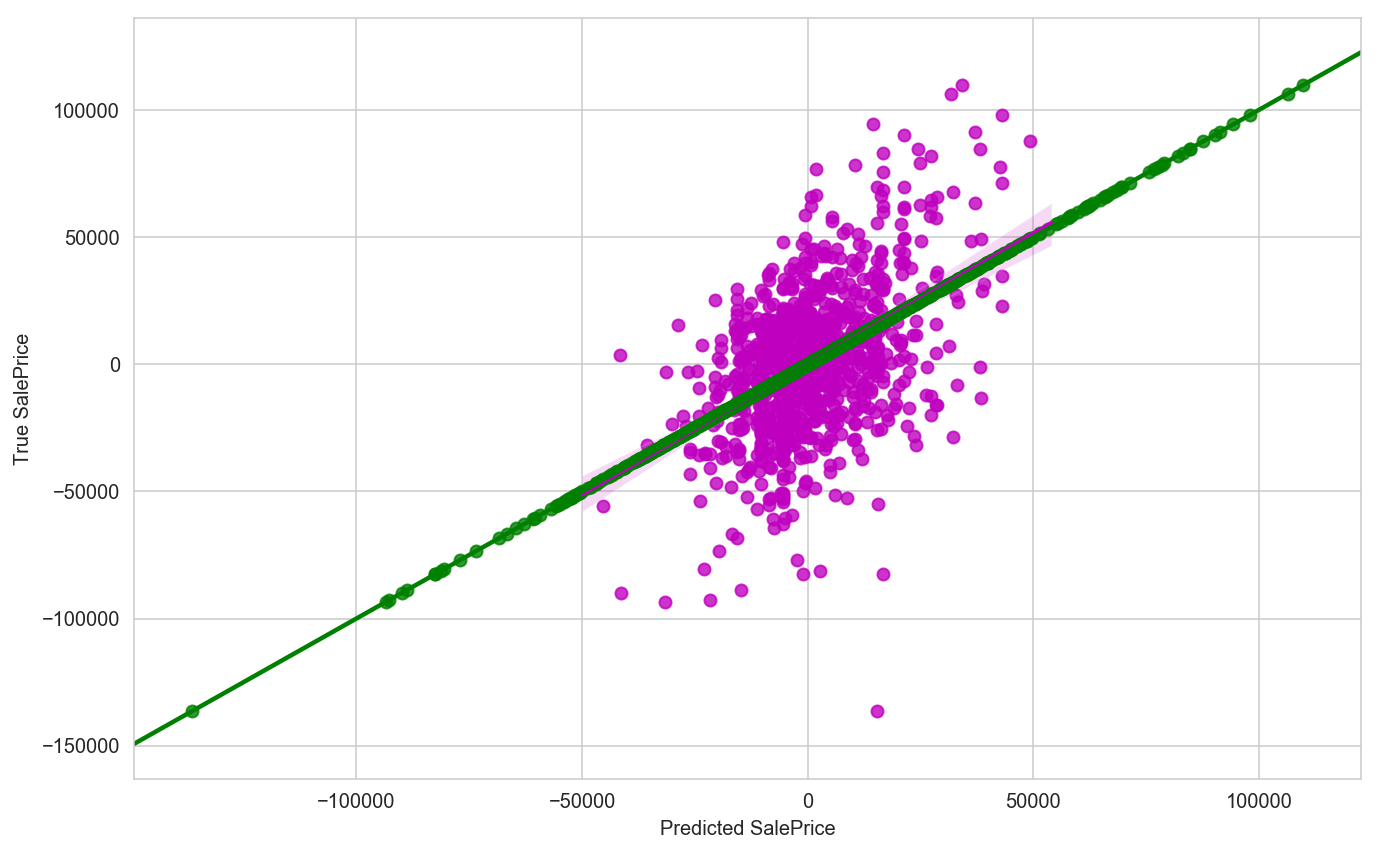

In [108]:
fig, ax = plt.subplots(figsize = (11,7))
sns.regplot(model.predict(features_renov.iloc[:, 2:]), features_renov.residual, color = 'm', ax = ax)
sns.regplot(features_renov.residual, features_renov.residual, color = 'g', ax = ax)
ax.set(xlabel = 'Predicted SalePrice', ylabel = 'True SalePrice')

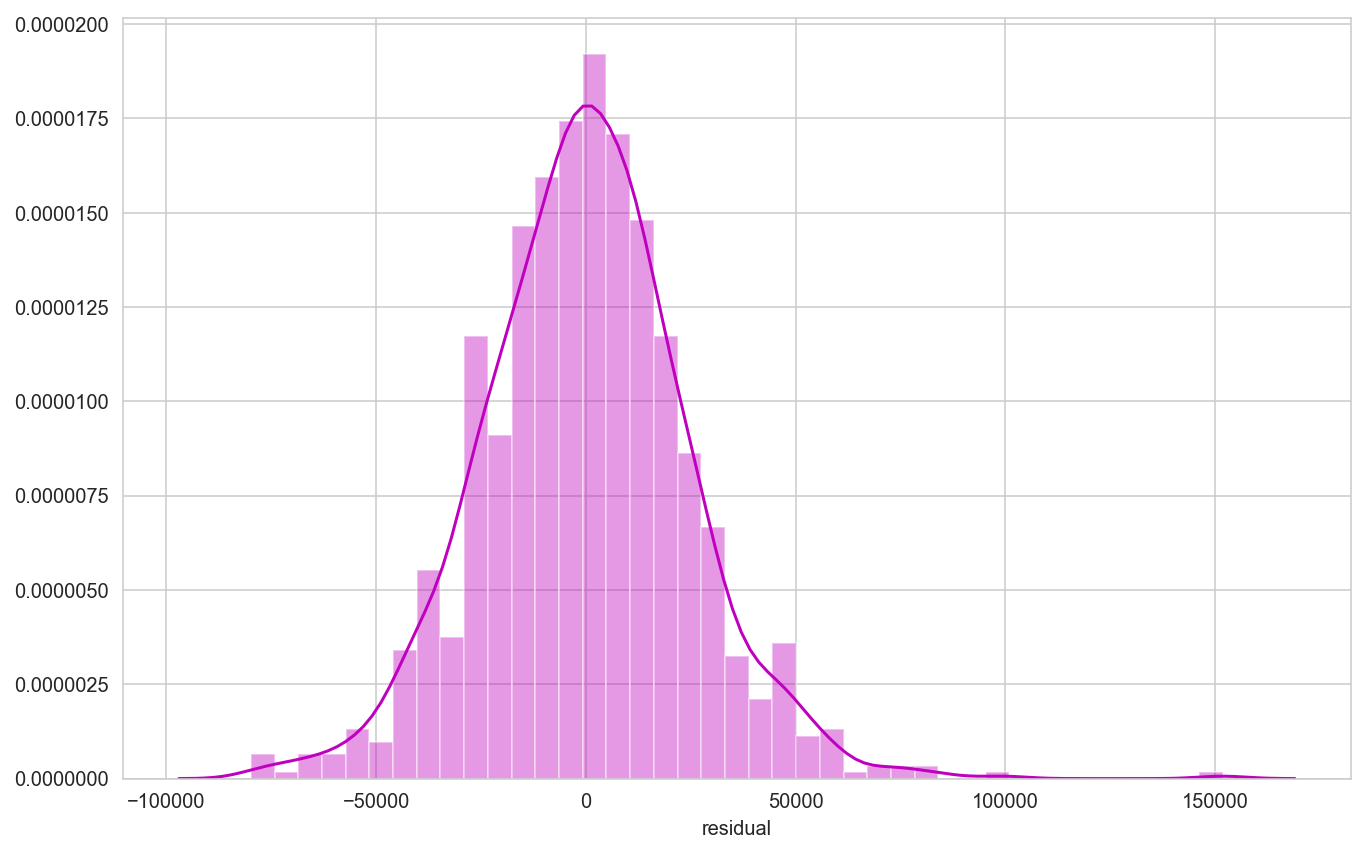

In [110]:
fig, ax = plt.subplots(figsize = (11,7))
sns.distplot(model.predict(features_renov.iloc[:, 2:]) - features_renov.residual, color = 'm', ax = ax)

Now let's do a brute-force search as well. We pick different combinations of variables and try them (except OverallQual and OverallCond)

Warning: It takes a lot of time to execute the next bit!

In [179]:
# a dictionary to keep track of the different scores for each combination
score_dict = {}

for r in range(4,7):
    # different combinations of features
    comb = combinations(cat_char_renov[2:], r)
    
    for variable_group in list(comb):
        
        # cleaning the dataframe for new feature selection
        features_renov.drop(features_renov.iloc[:, 2:].columns, axis = 1, inplace = True)

        for var in variable_group:
            # converting into dummy variable
            var_dummies = pd.get_dummies(house[var], drop_first = True)

            # adding the dummy variable to the dataframe
            features_renov = features_renov.merge(var_dummies, left_index = True, right_index = True, how = 'outer')
            
        # making the model based on the features
        X_train = features_renov[features_renov.YrSold != 2010].iloc[:, 2:]
        X_test = features_renov[features_renov.YrSold == 2010].iloc[:, 2:]
        y_train = features_renov[features_renov.YrSold != 2010].residual
        y_test = features_renov[features_renov.YrSold == 2010].residual

        model = RFECV(Ridge())
        model.fit(X_train, y_train)

        score_dict[model.score(X_test, y_test)] = variable_group
        
print("The highest score is", max(score_dict),
      "and it is corresponding to this set of features:", score_dict[max(score_dict)])

The highest score is 0.2696656791751888 and it is corresponding to this set of features: ('Exterior1st', 'Exterior2nd', 'ExterQual', 'BsmtCond', 'BsmtFinType1', 'KitchenQual')


As we see, the result is similar to the rankings we had before. So we make the final model with all the above results.

In [190]:
# cleaning the dataframe for new feature selection
features_renov.drop(features_renov.iloc[:, 2:].columns, axis = 1, inplace = True)

In [191]:
features_renov[['OverallQual', 'OverallCond']] = house[['OverallQual', 'OverallCond']]

In [192]:
for var in ['Exterior1st', 'Exterior2nd', 'ExterQual', 'BsmtCond', 'BsmtFinType1', 'KitchenQual']:
    # converting into dummy variable
    var_dummies = pd.get_dummies(house[var], drop_first = True)

    # adding the dummy variable to the dataframe
    features_renov = features_renov.merge(var_dummies, left_index = True, right_index = True, how = 'outer')

In [193]:
X_train = features_renov[features_renov.YrSold != 2010].iloc[:, 2:]
X_test = features_renov[features_renov.YrSold == 2010].iloc[:, 2:]
y_train = features_renov[features_renov.YrSold != 2010].residual
y_test = features_renov[features_renov.YrSold == 2010].residual

model = RFECV(Ridge())
model.fit(X_train, y_train)
print(model.score(X_test, y_test))

0.29806052427805485


[Text(0, 0.5, 'True SalePrice'), Text(0.5, 0, 'Predicted SalePrice')]

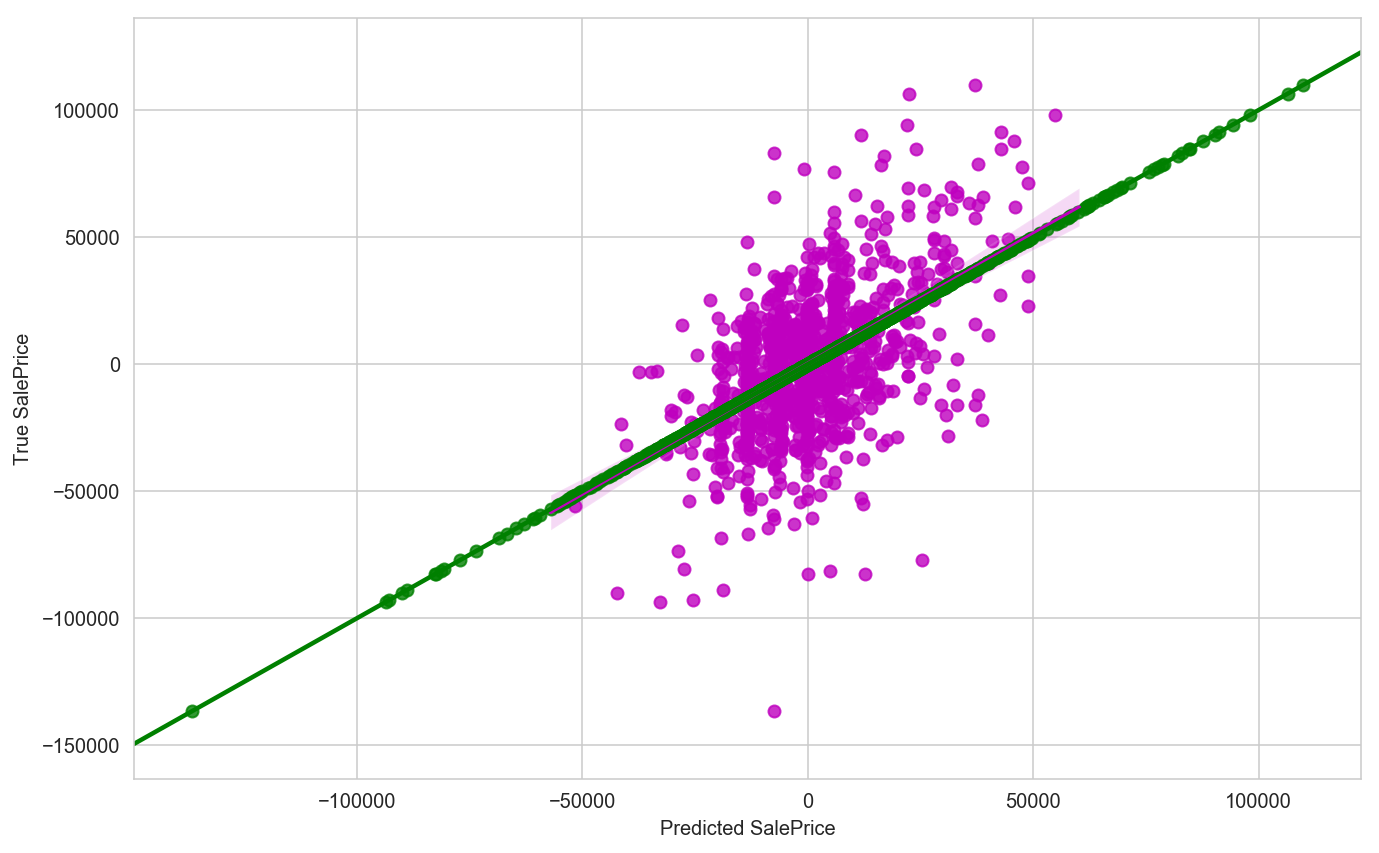

In [194]:
fig, ax = plt.subplots(figsize = (11,7))
sns.regplot(model.predict(features_renov.iloc[:, 2:]), features_renov.residual, color = 'm', ax = ax)
sns.regplot(features_renov.residual, features_renov.residual, color = 'g', ax = ax)
ax.set(xlabel = 'Predicted SalePrice', ylabel = 'True SalePrice')

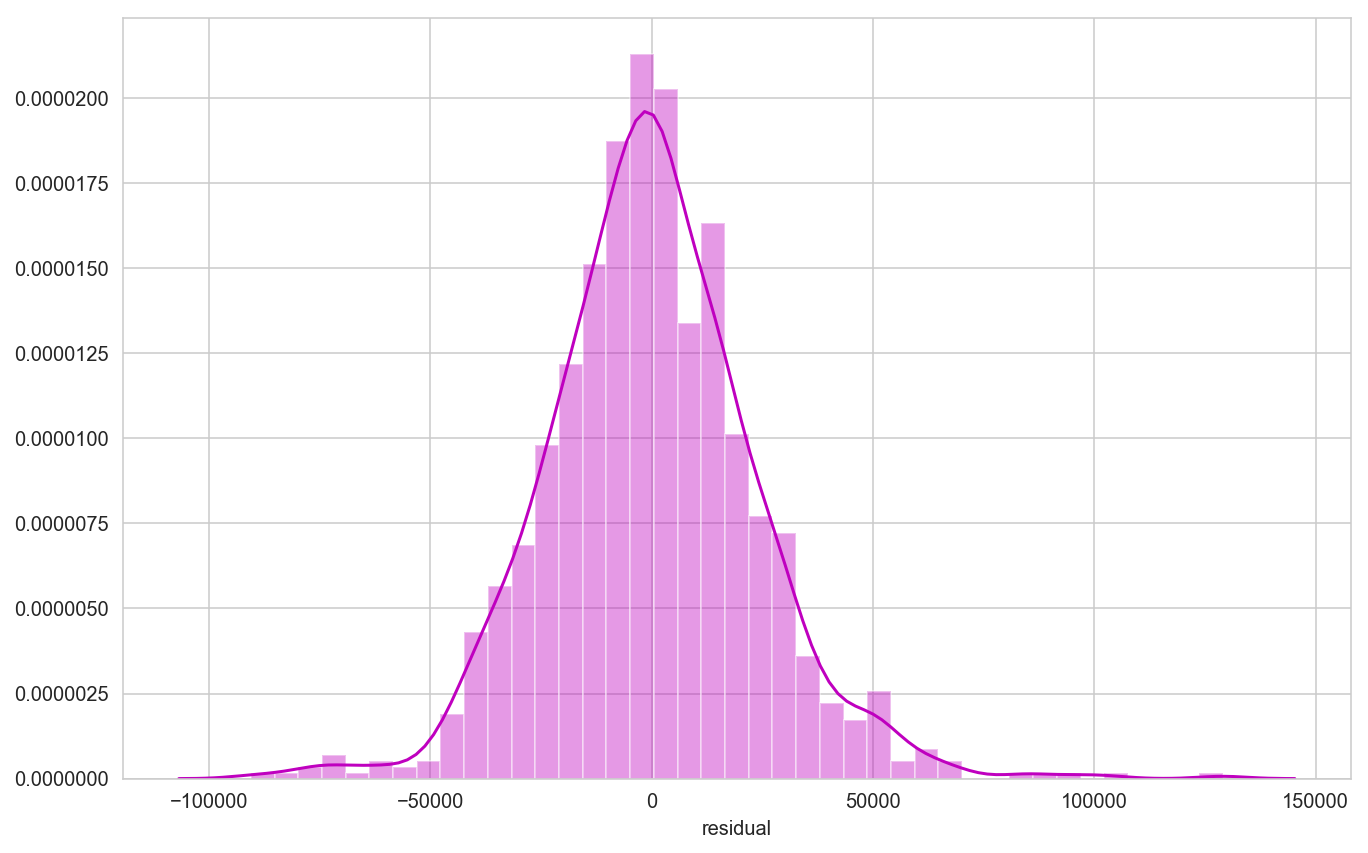

In [195]:
fig, ax = plt.subplots(figsize = (11,7))
sns.distplot(model.predict(features_renov.iloc[:, 2:]) - features_renov.residual, color = 'm', ax = ax)

If a set of features results in a good model that predicts the residual, it is the set of features that the company should fix/renovate to be able to make money by selling the house. The bigger the magnitude of the coefficient of a variable, the more effective it is to change the final selling price of the house. The difference between the residual of part 1 and the predicted value of part 2, is the amount of money that is changed by fixing/renovating the corresponding features.

<img src="http://imgur.com/GCAf1UX.png" style="float: left; margin: 25px 15px 0px 0px; height: 25px">

## 3. What property characteristics predict an "abnormal" sale?

---

The `SaleCondition` feature indicates the circumstances of the house sale. From the data file, we can see that the possibilities are:

       Normal	Normal Sale
       Abnorml	Abnormal Sale -  trade, foreclosure, short sale
       AdjLand	Adjoining Land Purchase
       Alloca	Allocation - two linked properties with separate deeds, typically condo with a garage unit	
       Family	Sale between family members
       Partial	Home was not completed when last assessed (associated with New Homes)
       
One of the executives at your company has an "in" with higher-ups at the major regional bank. His friends at the bank have made him a proposal: if he can reliably indicate what features, if any, predict "abnormal" sales (foreclosures, short sales, etc.), then in return the bank will give him first dibs on the pre-auction purchase of those properties (at a dirt-cheap price).

He has tasked you with determining (and adequately validating) which features of a property predict this type of sale. 

---

**Your task:**
1. Determine which features predict the `Abnorml` category in the `SaleCondition` feature.
- Justify your results.

This is a challenging task that tests your ability to perform classification analysis in the face of severe class imbalance. You may find that simply running a classifier on the full dataset to predict the category ends up useless: when there is bad class imbalance classifiers often tend to simply guess the majority class.

It is up to you to determine how you will tackle this problem. I recommend doing some research to find out how others have dealt with the problem in the past. Make sure to justify your solution. Don't worry about it being "the best" solution, but be rigorous.

Be sure to indicate which features are predictive (if any) and whether they are positive or negative predictors of abnormal sales.